# Train Log 20181103

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *
import model_opt5 as MODEL

In [5]:
""" Path """

data_train_path_list = []
data_test_path_list = []
data_vali_path_list = []

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_500_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

data_train_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020_rs2/train.h5')
data_vali_path = os.path.abspath('../../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020_rs2/vali.h5')
data_train_path_list.append(data_train_path)
data_vali_path_list.append(data_vali_path)

log_path = os.path.abspath('./train_log_20181101.txt')

model_save_path = os.path.abspath('./model')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 256
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 250

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 100

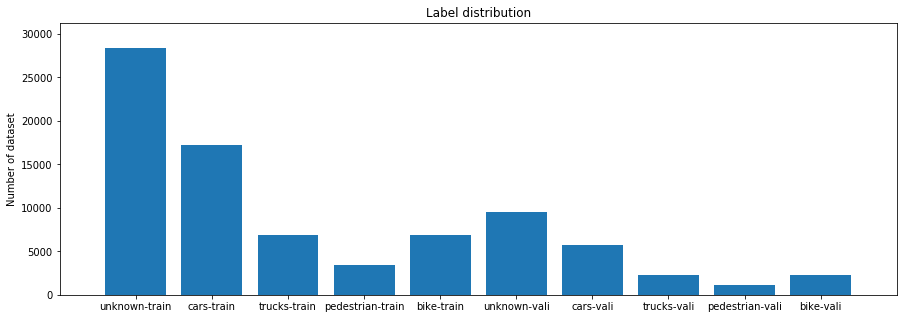

In [6]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path_list[0])
data_vali, label_vali = load_h5(data_vali_path_list[0])
    
for i in range( 1, len(data_train_path_list) ):

    d_train, l_train = load_h5(data_train_path_list[i])
    d_vali, l_vali = load_h5(data_vali_path_list[i])
    
    data_train = np.concatenate( (data_train, d_train), axis = 0 )
    data_vali = np.concatenate( (data_vali, d_vali), axis = 0 )
    
    label_train = np.concatenate( (label_train, l_train), axis = 0 )
    label_vali = np.concatenate( (label_vali, l_vali), axis = 0 )
    

data.append(data_train)
data.append(data_vali)

label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [7]:
""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath('./train')
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath('./test')
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
    data_train = data[0]
    label_train = label[0]
        
    data_vali = data[1]
    label_vali = label[1]
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
            
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-04 00:01:39.848752   Train one epoch   1 / 100


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:02:38.942042  [Epoch 0] mean loss: 0.004069
2018-11-04 00:02:38.942333  [Epoch 0] accuracy: 0.667904
2018-11-04 00:02:38.943013  [Epoch 0] avg class acc: 0.720084
2018-11-04 00:02:38.943614  [Epoch 0] indivisual [0] class recall: 0.794872
2018-11-04 00:02:38.943780  [Epoch 0] indivisual [0] class precision: 0.794872
2018-11-04 00:02:38.944051  [Epoch 0] indivisual [1] class recall: 0.916667
2018-11-04 00:02:38.944495  [Epoch 0] indivisual [1] class precision: 0.753425
2018-11-04 00:02:38.944761  [Epoch 0] indivisual [2] class recall: 0.580645
2018-11-04 00:02:38.944858  [Epoch 0] indivisual [2] class precision: 0.720000
2018-11-04 00:02:38.945122  [Epoch 0] indivisual [3] class recall: 0.588235
2018-11-04 00:02:38.945546  [Epoch 0] indivisual [3] class precision: 0.909091
2018-11-04 00:02:38.945807  [Epoch 0] indivisual [4] class recall: 0.720000
2018-11-04 00:02:38.945903  [Epoch 0] indivisual [4] class precision: 0.750000
2018-11-04 00:02:38.946328   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 19.98it/s]

2018-11-04 00:02:43.293988  [Epoch 0] vali mean loss: 0.012160
2018-11-04 00:02:43.294660  [Epoch 0] vali accuracy: 0.824381
2018-11-04 00:02:43.295444  [Epoch 0] vali avg class acc: 0.000000
2018-11-04 00:02:43.295808  [Epoch 0] vali indivisual [0] class recall: 0.876033
2018-11-04 00:02:43.295979  [Epoch 0] vali indivisual [0] class precision: 0.796992
2018-11-04 00:02:43.296097  [Epoch 0] vali indivisual [1] class recall: 0.960784
2018-11-04 00:02:43.296383  [Epoch 0] vali indivisual [1] class precision: 0.924528
2018-11-04 00:02:43.297117  [Epoch 0] vali indivisual [2] class recall: 0.689655
2018-11-04 00:02:43.297613  [Epoch 0] vali indivisual [2] class precision: 0.740741
2018-11-04 00:02:43.297812  [Epoch 0] vali indivisual [3] class recall: 0.117647
2018-11-04 00:02:43.298066  [Epoch 0] vali indivisual [3] class precision: 0.666667
2018-11-04 00:02:43.298230  [Epoch 0] vali indivisual [4] class recall: 0.968750
2018-11-04 00:02:43.298446  [Epoch 0] vali indivisual [4] class pre


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:03:42.431552  [Epoch 1] mean loss: 0.002334
2018-11-04 00:03:42.432321  [Epoch 1] accuracy: 0.813689
2018-11-04 00:03:42.434397  [Epoch 1] avg class acc: 0.816977
2018-11-04 00:03:42.434802  [Epoch 1] indivisual [0] class recall: 0.830189
2018-11-04 00:03:42.435206  [Epoch 1] indivisual [0] class precision: 0.830189
2018-11-04 00:03:42.435518  [Epoch 1] indivisual [1] class recall: 0.987500
2018-11-04 00:03:42.435941  [Epoch 1] indivisual [1] class precision: 0.929412
2018-11-04 00:03:42.436046  [Epoch 1] indivisual [2] class recall: 0.592593
2018-11-04 00:03:42.436311  [Epoch 1] indivisual [2] class precision: 0.727273
2018-11-04 00:03:42.436566  [Epoch 1] indivisual [3] class recall: 0.888889
2018-11-04 00:03:42.436962  [Epoch 1] indivisual [3] class precision: 0.666667
2018-11-04 00:03:42.437063  [Epoch 1] indivisual [4] class recall: 0.785714
2018-11-04 00:03:42.437320  [Epoch 1] indivisual [4] class precision: 0.880000
2018-11-04 00:03:42.437777   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.94it/s]

2018-11-04 00:03:46.572344  [Epoch 1] vali mean loss: 0.006975
2018-11-04 00:03:46.572689  [Epoch 1] vali accuracy: 0.885143
2018-11-04 00:03:46.573082  [Epoch 1] vali avg class acc: 0.000000
2018-11-04 00:03:46.573696  [Epoch 1] vali indivisual [0] class recall: 0.991379
2018-11-04 00:03:46.573817  [Epoch 1] vali indivisual [0] class precision: 0.827338
2018-11-04 00:03:46.574108  [Epoch 1] vali indivisual [1] class recall: 0.957143
2018-11-04 00:03:46.574544  [Epoch 1] vali indivisual [1] class precision: 0.985294
2018-11-04 00:03:46.574686  [Epoch 1] vali indivisual [2] class recall: 0.750000
2018-11-04 00:03:46.574861  [Epoch 1] vali indivisual [2] class precision: 0.937500
2018-11-04 00:03:46.575173  [Epoch 1] vali indivisual [3] class recall: 0.571429
2018-11-04 00:03:46.575584  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-11-04 00:03:46.575677  [Epoch 1] vali indivisual [4] class recall: 0.633333
2018-11-04 00:03:46.575785  [Epoch 1] vali indivisual [4] class pre


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:04:45.750735  [Epoch 2] mean loss: 0.001800
2018-11-04 00:04:45.751447  [Epoch 2] accuracy: 0.858869
2018-11-04 00:04:45.752204  [Epoch 2] avg class acc: 0.817728
2018-11-04 00:04:45.752350  [Epoch 2] indivisual [0] class recall: 0.919643
2018-11-04 00:04:45.752650  [Epoch 2] indivisual [0] class precision: 0.851240
2018-11-04 00:04:45.753120  [Epoch 2] indivisual [1] class recall: 0.985075
2018-11-04 00:04:45.753228  [Epoch 2] indivisual [1] class precision: 0.956522
2018-11-04 00:04:45.753610  [Epoch 2] indivisual [2] class recall: 0.653846
2018-11-04 00:04:45.753971  [Epoch 2] indivisual [2] class precision: 0.708333
2018-11-04 00:04:45.754063  [Epoch 2] indivisual [3] class recall: 0.714286
2018-11-04 00:04:45.754330  [Epoch 2] indivisual [3] class precision: 1.000000
2018-11-04 00:04:45.754658  [Epoch 2] indivisual [4] class recall: 0.815789
2018-11-04 00:04:45.754800  [Epoch 2] indivisual [4] class precision: 1.000000
2018-11-04 00:04:45.754951   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 00:04:49.998454  [Epoch 2] vali mean loss: 0.005378
2018-11-04 00:04:49.999320  [Epoch 2] vali accuracy: 0.923286
2018-11-04 00:04:50.000035  [Epoch 2] vali avg class acc: 0.000000
2018-11-04 00:04:50.000246  [Epoch 2] vali indivisual [0] class recall: 0.953704
2018-11-04 00:04:50.000518  [Epoch 2] vali indivisual [0] class precision: 0.911504
2018-11-04 00:04:50.001050  [Epoch 2] vali indivisual [1] class recall: 0.986301
2018-11-04 00:04:50.001444  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-11-04 00:04:50.001580  [Epoch 2] vali indivisual [2] class recall: 0.928571
2018-11-04 00:04:50.001776  [Epoch 2] vali indivisual [2] class precision: 0.838710
2018-11-04 00:04:50.002163  [Epoch 2] vali indivisual [3] class recall: 0.714286
2018-11-04 00:04:50.002434  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-11-04 00:04:50.002571  [Epoch 2] vali indivisual [4] class recall: 0.888889
2018-11-04 00:04:50.003132  [Epoch 2] vali indivisual [4] class pre


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:05:49.286474  [Epoch 3] mean loss: 0.001299
2018-11-04 00:05:49.287245  [Epoch 3] accuracy: 0.896749
2018-11-04 00:05:49.287915  [Epoch 3] avg class acc: 0.904937
2018-11-04 00:05:49.288240  [Epoch 3] indivisual [0] class recall: 0.924528
2018-11-04 00:05:49.288700  [Epoch 3] indivisual [0] class precision: 0.882883
2018-11-04 00:05:49.288981  [Epoch 3] indivisual [1] class recall: 0.985714
2018-11-04 00:05:49.289089  [Epoch 3] indivisual [1] class precision: 0.932432
2018-11-04 00:05:49.289182  [Epoch 3] indivisual [2] class recall: 0.694444
2018-11-04 00:05:49.289608  [Epoch 3] indivisual [2] class precision: 0.862069
2018-11-04 00:05:49.289820  [Epoch 3] indivisual [3] class recall: 1.000000
2018-11-04 00:05:49.289974  [Epoch 3] indivisual [3] class precision: 1.000000
2018-11-04 00:05:49.290249  [Epoch 3] indivisual [4] class recall: 0.920000
2018-11-04 00:05:49.290408  [Epoch 3] indivisual [4] class precision: 1.000000
2018-11-04 00:05:49.291049   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.14it/s]

2018-11-04 00:05:53.584096  [Epoch 3] vali mean loss: 0.003882
2018-11-04 00:05:53.584436  [Epoch 3] vali accuracy: 0.963000
2018-11-04 00:05:53.585093  [Epoch 3] vali avg class acc: 0.400000
2018-11-04 00:05:53.585631  [Epoch 3] vali indivisual [0] class recall: 0.981308
2018-11-04 00:05:53.585973  [Epoch 3] vali indivisual [0] class precision: 0.945946
2018-11-04 00:05:53.586701  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-11-04 00:05:53.586870  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-11-04 00:05:53.587225  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-11-04 00:05:53.587702  [Epoch 3] vali indivisual [2] class precision: 0.933333
2018-11-04 00:05:53.587976  [Epoch 3] vali indivisual [3] class recall: 0.733333
2018-11-04 00:05:53.588078  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-11-04 00:05:53.588527  [Epoch 3] vali indivisual [4] class recall: 0.935484
2018-11-04 00:05:53.588630  [Epoch 3] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:06:52.981203  [Epoch 4] mean loss: 0.001091
2018-11-04 00:06:52.982053  [Epoch 4] accuracy: 0.913323
2018-11-04 00:06:52.982536  [Epoch 4] avg class acc: 0.878167
2018-11-04 00:06:52.982764  [Epoch 4] indivisual [0] class recall: 0.888889
2018-11-04 00:06:52.983084  [Epoch 4] indivisual [0] class precision: 0.897196
2018-11-04 00:06:52.983254  [Epoch 4] indivisual [1] class recall: 0.972973
2018-11-04 00:06:52.983871  [Epoch 4] indivisual [1] class precision: 0.947368
2018-11-04 00:06:52.984154  [Epoch 4] indivisual [2] class recall: 0.777778
2018-11-04 00:06:52.984579  [Epoch 4] indivisual [2] class precision: 0.807692
2018-11-04 00:06:52.984682  [Epoch 4] indivisual [3] class recall: 0.842105
2018-11-04 00:06:52.985110  [Epoch 4] indivisual [3] class precision: 0.842105
2018-11-04 00:06:52.985214  [Epoch 4] indivisual [4] class recall: 0.909091
2018-11-04 00:06:52.985419  [Epoch 4] indivisual [4] class precision: 0.909091
2018-11-04 00:06:52.985926   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 00:06:57.230254  [Epoch 4] vali mean loss: 0.003260
2018-11-04 00:06:57.230802  [Epoch 4] vali accuracy: 0.942429
2018-11-04 00:06:57.231573  [Epoch 4] vali avg class acc: 0.200000
2018-11-04 00:06:57.231953  [Epoch 4] vali indivisual [0] class recall: 0.944954
2018-11-04 00:06:57.232205  [Epoch 4] vali indivisual [0] class precision: 0.944954
2018-11-04 00:06:57.232414  [Epoch 4] vali indivisual [1] class recall: 0.986486
2018-11-04 00:06:57.232675  [Epoch 4] vali indivisual [1] class precision: 0.960526
2018-11-04 00:06:57.232916  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-11-04 00:06:57.233391  [Epoch 4] vali indivisual [2] class precision: 0.880000
2018-11-04 00:06:57.233666  [Epoch 4] vali indivisual [3] class recall: 0.791667
2018-11-04 00:06:57.234091  [Epoch 4] vali indivisual [3] class precision: 0.950000
2018-11-04 00:06:57.234192  [Epoch 4] vali indivisual [4] class recall: 0.952381
2018-11-04 00:06:57.234466  [Epoch 4] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:07:56.565871  [Epoch 5] mean loss: 0.001050
2018-11-04 00:07:56.566629  [Epoch 5] accuracy: 0.917976
2018-11-04 00:07:56.567170  [Epoch 5] avg class acc: 0.942500
2018-11-04 00:07:56.567311  [Epoch 5] indivisual [0] class recall: 0.900000
2018-11-04 00:07:56.567657  [Epoch 5] indivisual [0] class precision: 0.947368
2018-11-04 00:07:56.567977  [Epoch 5] indivisual [1] class recall: 0.968750
2018-11-04 00:07:56.568309  [Epoch 5] indivisual [1] class precision: 0.911765
2018-11-04 00:07:56.568753  [Epoch 5] indivisual [2] class recall: 0.843750
2018-11-04 00:07:56.569015  [Epoch 5] indivisual [2] class precision: 0.964286
2018-11-04 00:07:56.569112  [Epoch 5] indivisual [3] class recall: 1.000000
2018-11-04 00:07:56.569540  [Epoch 5] indivisual [3] class precision: 0.928571
2018-11-04 00:07:56.569641  [Epoch 5] indivisual [4] class recall: 1.000000
2018-11-04 00:07:56.569766  [Epoch 5] indivisual [4] class precision: 0.807692
2018-11-04 00:07:56.570287   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.95it/s]

2018-11-04 00:08:00.713190  [Epoch 5] vali mean loss: 0.003138
2018-11-04 00:08:00.713929  [Epoch 5] vali accuracy: 0.964143
2018-11-04 00:08:00.714491  [Epoch 5] vali avg class acc: 0.200000
2018-11-04 00:08:00.714794  [Epoch 5] vali indivisual [0] class recall: 0.973913
2018-11-04 00:08:00.715096  [Epoch 5] vali indivisual [0] class precision: 0.941176
2018-11-04 00:08:00.715390  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-11-04 00:08:00.715520  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-11-04 00:08:00.715905  [Epoch 5] vali indivisual [2] class recall: 0.928571
2018-11-04 00:08:00.716165  [Epoch 5] vali indivisual [2] class precision: 0.866667
2018-11-04 00:08:00.716426  [Epoch 5] vali indivisual [3] class recall: 0.722222
2018-11-04 00:08:00.716830  [Epoch 5] vali indivisual [3] class precision: 0.928571
2018-11-04 00:08:00.716931  [Epoch 5] vali indivisual [4] class recall: 0.935484
2018-11-04 00:08:00.717350  [Epoch 5] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:09:00.151988  [Epoch 6] mean loss: 0.000830
2018-11-04 00:09:00.152785  [Epoch 6] accuracy: 0.936797
2018-11-04 00:09:00.153250  [Epoch 6] avg class acc: 0.913443
2018-11-04 00:09:00.153654  [Epoch 6] indivisual [0] class recall: 0.877358
2018-11-04 00:09:00.153886  [Epoch 6] indivisual [0] class precision: 0.902913
2018-11-04 00:09:00.154272  [Epoch 6] indivisual [1] class recall: 0.956522
2018-11-04 00:09:00.154548  [Epoch 6] indivisual [1] class precision: 0.929577
2018-11-04 00:09:00.154805  [Epoch 6] indivisual [2] class recall: 0.733333
2018-11-04 00:09:00.155068  [Epoch 6] indivisual [2] class precision: 0.785714
2018-11-04 00:09:00.155358  [Epoch 6] indivisual [3] class recall: 1.000000
2018-11-04 00:09:00.155626  [Epoch 6] indivisual [3] class precision: 1.000000
2018-11-04 00:09:00.155884  [Epoch 6] indivisual [4] class recall: 1.000000
2018-11-04 00:09:00.156293  [Epoch 6] indivisual [4] class precision: 0.914286
2018-11-04 00:09:00.156396   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.73it/s]

2018-11-04 00:09:04.345872  [Epoch 6] vali mean loss: 0.002480
2018-11-04 00:09:04.346625  [Epoch 6] vali accuracy: 0.978667
2018-11-04 00:09:04.347136  [Epoch 6] vali avg class acc: 0.400000
2018-11-04 00:09:04.347723  [Epoch 6] vali indivisual [0] class recall: 1.000000
2018-11-04 00:09:04.347954  [Epoch 6] vali indivisual [0] class precision: 0.950413
2018-11-04 00:09:04.348130  [Epoch 6] vali indivisual [1] class recall: 0.985294
2018-11-04 00:09:04.348432  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-11-04 00:09:04.348711  [Epoch 6] vali indivisual [2] class recall: 0.906250
2018-11-04 00:09:04.349143  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-11-04 00:09:04.349276  [Epoch 6] vali indivisual [3] class recall: 0.875000
2018-11-04 00:09:04.349522  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-11-04 00:09:04.349943  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-11-04 00:09:04.350217  [Epoch 6] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:10:03.775602  [Epoch 7] mean loss: 0.000698
2018-11-04 00:10:03.776360  [Epoch 7] accuracy: 0.946837
2018-11-04 00:10:03.776765  [Epoch 7] avg class acc: 0.935094
2018-11-04 00:10:03.777244  [Epoch 7] indivisual [0] class recall: 0.925234
2018-11-04 00:10:03.777462  [Epoch 7] indivisual [0] class precision: 0.933962
2018-11-04 00:10:03.777880  [Epoch 7] indivisual [1] class recall: 0.974026
2018-11-04 00:10:03.777981  [Epoch 7] indivisual [1] class precision: 0.961538
2018-11-04 00:10:03.778242  [Epoch 7] indivisual [2] class recall: 0.838710
2018-11-04 00:10:03.778509  [Epoch 7] indivisual [2] class precision: 0.896552
2018-11-04 00:10:03.778705  [Epoch 7] indivisual [3] class recall: 0.937500
2018-11-04 00:10:03.778849  [Epoch 7] indivisual [3] class precision: 1.000000
2018-11-04 00:10:03.779022  [Epoch 7] indivisual [4] class recall: 1.000000
2018-11-04 00:10:03.779434  [Epoch 7] indivisual [4] class precision: 0.863636
2018-11-04 00:10:03.779852   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.72it/s]

2018-11-04 00:10:07.967823  [Epoch 7] vali mean loss: 0.002085
2018-11-04 00:10:07.968487  [Epoch 7] vali accuracy: 0.976333
2018-11-04 00:10:07.968972  [Epoch 7] vali avg class acc: 0.600000
2018-11-04 00:10:07.969565  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-11-04 00:10:07.969830  [Epoch 7] vali indivisual [0] class precision: 0.973451
2018-11-04 00:10:07.970091  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-11-04 00:10:07.970189  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-11-04 00:10:07.970621  [Epoch 7] vali indivisual [2] class recall: 0.966667
2018-11-04 00:10:07.970756  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-11-04 00:10:07.970934  [Epoch 7] vali indivisual [3] class recall: 0.857143
2018-11-04 00:10:07.971363  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-11-04 00:10:07.971593  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-11-04 00:10:07.971978  [Epoch 7] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:11:07.461380  [Epoch 8] mean loss: 0.000697
2018-11-04 00:11:07.461790  [Epoch 8] accuracy: 0.947363
2018-11-04 00:11:07.462545  [Epoch 8] avg class acc: 0.922273
2018-11-04 00:11:07.463095  [Epoch 8] indivisual [0] class recall: 0.941667
2018-11-04 00:11:07.463388  [Epoch 8] indivisual [0] class precision: 0.949580
2018-11-04 00:11:07.463708  [Epoch 8] indivisual [1] class recall: 0.983333
2018-11-04 00:11:07.464284  [Epoch 8] indivisual [1] class precision: 0.936508
2018-11-04 00:11:07.464496  [Epoch 8] indivisual [2] class recall: 0.800000
2018-11-04 00:11:07.464628  [Epoch 8] indivisual [2] class precision: 0.869565
2018-11-04 00:11:07.465051  [Epoch 8] indivisual [3] class recall: 0.916667
2018-11-04 00:11:07.465340  [Epoch 8] indivisual [3] class precision: 0.846154
2018-11-04 00:11:07.465626  [Epoch 8] indivisual [4] class recall: 0.969697
2018-11-04 00:11:07.465789  [Epoch 8] indivisual [4] class precision: 1.000000
2018-11-04 00:11:07.465960   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:11:11.662209  [Epoch 8] vali mean loss: 0.002082
2018-11-04 00:11:11.662739  [Epoch 8] vali accuracy: 0.983524
2018-11-04 00:11:11.663143  [Epoch 8] vali avg class acc: 0.600000
2018-11-04 00:11:11.663805  [Epoch 8] vali indivisual [0] class recall: 0.981651
2018-11-04 00:11:11.663967  [Epoch 8] vali indivisual [0] class precision: 0.990741
2018-11-04 00:11:11.664307  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-11-04 00:11:11.664495  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-11-04 00:11:11.664921  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-11-04 00:11:11.665020  [Epoch 8] vali indivisual [2] class precision: 0.931034
2018-11-04 00:11:11.665449  [Epoch 8] vali indivisual [3] class recall: 0.933333
2018-11-04 00:11:11.665662  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-11-04 00:11:11.665819  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-11-04 00:11:11.666098  [Epoch 8] vali indivisual [4] class pre


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:12:11.081371  [Epoch 9] mean loss: 0.000621
2018-11-04 00:12:11.082443  [Epoch 9] accuracy: 0.952510
2018-11-04 00:12:11.083163  [Epoch 9] avg class acc: 0.970610
2018-11-04 00:12:11.083479  [Epoch 9] indivisual [0] class recall: 0.990476
2018-11-04 00:12:11.083934  [Epoch 9] indivisual [0] class precision: 0.954128
2018-11-04 00:12:11.084344  [Epoch 9] indivisual [1] class recall: 0.973684
2018-11-04 00:12:11.084459  [Epoch 9] indivisual [1] class precision: 1.000000
2018-11-04 00:12:11.084736  [Epoch 9] indivisual [2] class recall: 0.888889
2018-11-04 00:12:11.084897  [Epoch 9] indivisual [2] class precision: 0.960000
2018-11-04 00:12:11.084989  [Epoch 9] indivisual [3] class recall: 1.000000
2018-11-04 00:12:11.085633  [Epoch 9] indivisual [3] class precision: 1.000000
2018-11-04 00:12:11.085732  [Epoch 9] indivisual [4] class recall: 1.000000
2018-11-04 00:12:11.085997  [Epoch 9] indivisual [4] class precision: 1.000000
2018-11-04 00:12:11.086161   Evaluation one (val


100%|██████████| 84/84 [00:04<00:00, 20.51it/s]


2018-11-04 00:12:15.325705  [Epoch 9] vali mean loss: 0.001857
2018-11-04 00:12:15.326018  [Epoch 9] vali accuracy: 0.987190
2018-11-04 00:12:15.326443  [Epoch 9] vali avg class acc: 0.200000
2018-11-04 00:12:15.326696  [Epoch 9] vali indivisual [0] class recall: 0.990196
2018-11-04 00:12:15.326927  [Epoch 9] vali indivisual [0] class precision: 0.952830
2018-11-04 00:12:15.327115  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-11-04 00:12:15.327259  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-11-04 00:12:15.327878  [Epoch 9] vali indivisual [2] class recall: 0.939394
2018-11-04 00:12:15.328496  [Epoch 9] vali indivisual [2] class precision: 0.968750
2018-11-04 00:12:15.328713  [Epoch 9] vali indivisual [3] class recall: 0.869565
2018-11-04 00:12:15.328843  [Epoch 9] vali indivisual [3] class precision: 0.952381
2018-11-04 00:12:15.328932  [Epoch 9] vali indivisual [4] class recall: 0.966667
2018-11-04 00:12:15.329119  [Epoch 9] vali indivisual [4] class pre

100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:13:15.090509  [Epoch 10] mean loss: 0.000536
2018-11-04 00:13:15.091320  [Epoch 10] accuracy: 0.960096
2018-11-04 00:13:15.091788  [Epoch 10] avg class acc: 0.959234
2018-11-04 00:13:15.092357  [Epoch 10] indivisual [0] class recall: 1.000000
2018-11-04 00:13:15.092474  [Epoch 10] indivisual [0] class precision: 0.945455
2018-11-04 00:13:15.092741  [Epoch 10] indivisual [1] class recall: 1.000000
2018-11-04 00:13:15.093061  [Epoch 10] indivisual [1] class precision: 0.985507
2018-11-04 00:13:15.093402  [Epoch 10] indivisual [2] class recall: 0.837838
2018-11-04 00:13:15.093506  [Epoch 10] indivisual [2] class precision: 1.000000
2018-11-04 00:13:15.093752  [Epoch 10] indivisual [3] class recall: 1.000000
2018-11-04 00:13:15.094006  [Epoch 10] indivisual [3] class precision: 1.000000
2018-11-04 00:13:15.094197  [Epoch 10] indivisual [4] class recall: 0.958333
2018-11-04 00:13:15.094343  [Epoch 10] indivisual [4] class precision: 1.000000
2018-11-04 00:13:15.094517   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.89it/s]

2018-11-04 00:13:19.234121  [Epoch 10] vali mean loss: 0.001603
2018-11-04 00:13:19.234388  [Epoch 10] vali accuracy: 0.990429
2018-11-04 00:13:19.235025  [Epoch 10] vali avg class acc: 0.600000
2018-11-04 00:13:19.235544  [Epoch 10] vali indivisual [0] class recall: 1.000000
2018-11-04 00:13:19.235681  [Epoch 10] vali indivisual [0] class precision: 0.975610
2018-11-04 00:13:19.236225  [Epoch 10] vali indivisual [1] class recall: 1.000000
2018-11-04 00:13:19.236381  [Epoch 10] vali indivisual [1] class precision: 1.000000
2018-11-04 00:13:19.236521  [Epoch 10] vali indivisual [2] class recall: 0.956522
2018-11-04 00:13:19.236693  [Epoch 10] vali indivisual [2] class precision: 1.000000
2018-11-04 00:13:19.236955  [Epoch 10] vali indivisual [3] class recall: 0.875000
2018-11-04 00:13:19.237613  [Epoch 10] vali indivisual [3] class precision: 1.000000
2018-11-04 00:13:19.238048  [Epoch 10] vali indivisual [4] class recall: 1.000000
2018-11-04 00:13:19.238322  [Epoch 10] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:14:18.716123  [Epoch 11] mean loss: 0.000518
2018-11-04 00:14:18.716401  [Epoch 11] accuracy: 0.961737
2018-11-04 00:14:18.717147  [Epoch 11] avg class acc: 0.968143
2018-11-04 00:14:18.717484  [Epoch 11] indivisual [0] class recall: 0.967213
2018-11-04 00:14:18.717653  [Epoch 11] indivisual [0] class precision: 0.983333
2018-11-04 00:14:18.717897  [Epoch 11] indivisual [1] class recall: 0.984615
2018-11-04 00:14:18.718022  [Epoch 11] indivisual [1] class precision: 1.000000
2018-11-04 00:14:18.718581  [Epoch 11] indivisual [2] class recall: 1.000000
2018-11-04 00:14:18.718739  [Epoch 11] indivisual [2] class precision: 0.851852
2018-11-04 00:14:18.719139  [Epoch 11] indivisual [3] class recall: 0.888889
2018-11-04 00:14:18.719265  [Epoch 11] indivisual [3] class precision: 1.000000
2018-11-04 00:14:18.719528  [Epoch 11] indivisual [4] class recall: 1.000000
2018-11-04 00:14:18.719646  [Epoch 11] indivisual [4] class precision: 1.000000
2018-11-04 00:14:18.720184   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:14:22.911201  [Epoch 11] vali mean loss: 0.001548
2018-11-04 00:14:22.911464  [Epoch 11] vali accuracy: 0.990048
2018-11-04 00:14:22.911965  [Epoch 11] vali avg class acc: 0.400000
2018-11-04 00:14:22.912277  [Epoch 11] vali indivisual [0] class recall: 0.966667
2018-11-04 00:14:22.912396  [Epoch 11] vali indivisual [0] class precision: 0.974790
2018-11-04 00:14:22.913521  [Epoch 11] vali indivisual [1] class recall: 0.984848
2018-11-04 00:14:22.913849  [Epoch 11] vali indivisual [1] class precision: 1.000000
2018-11-04 00:14:22.914033  [Epoch 11] vali indivisual [2] class recall: 0.933333
2018-11-04 00:14:22.914342  [Epoch 11] vali indivisual [2] class precision: 0.933333
2018-11-04 00:14:22.914492  [Epoch 11] vali indivisual [3] class recall: 1.000000
2018-11-04 00:14:22.915082  [Epoch 11] vali indivisual [3] class precision: 0.857143
2018-11-04 00:14:22.915276  [Epoch 11] vali indivisual [4] class recall: 1.000000
2018-11-04 00:14:22.915499  [Epoch 11] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:15:22.045591  [Epoch 12] mean loss: 0.000489
2018-11-04 00:15:22.046444  [Epoch 12] accuracy: 0.964749
2018-11-04 00:15:22.046906  [Epoch 12] avg class acc: 0.979029
2018-11-04 00:15:22.047498  [Epoch 12] indivisual [0] class recall: 0.965517
2018-11-04 00:15:22.047791  [Epoch 12] indivisual [0] class precision: 0.982456
2018-11-04 00:15:22.048050  [Epoch 12] indivisual [1] class recall: 1.000000
2018-11-04 00:15:22.048541  [Epoch 12] indivisual [1] class precision: 0.950000
2018-11-04 00:15:22.048847  [Epoch 12] indivisual [2] class recall: 0.966667
2018-11-04 00:15:22.049129  [Epoch 12] indivisual [2] class precision: 1.000000
2018-11-04 00:15:22.049262  [Epoch 12] indivisual [3] class recall: 1.000000
2018-11-04 00:15:22.049481  [Epoch 12] indivisual [3] class precision: 0.952381
2018-11-04 00:15:22.049659  [Epoch 12] indivisual [4] class recall: 0.962963
2018-11-04 00:15:22.049854  [Epoch 12] indivisual [4] class precision: 1.000000
2018-11-04 00:15:22.050581   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.96it/s]

2018-11-04 00:15:26.190211  [Epoch 12] vali mean loss: 0.001460
2018-11-04 00:15:26.190442  [Epoch 12] vali accuracy: 0.988714
2018-11-04 00:15:26.190733  [Epoch 12] vali avg class acc: 0.600000
2018-11-04 00:15:26.191400  [Epoch 12] vali indivisual [0] class recall: 1.000000
2018-11-04 00:15:26.191554  [Epoch 12] vali indivisual [0] class precision: 0.973684
2018-11-04 00:15:26.192122  [Epoch 12] vali indivisual [1] class recall: 1.000000
2018-11-04 00:15:26.192224  [Epoch 12] vali indivisual [1] class precision: 1.000000
2018-11-04 00:15:26.192497  [Epoch 12] vali indivisual [2] class recall: 0.935484
2018-11-04 00:15:26.192772  [Epoch 12] vali indivisual [2] class precision: 1.000000
2018-11-04 00:15:26.192983  [Epoch 12] vali indivisual [3] class recall: 0.916667
2018-11-04 00:15:26.193139  [Epoch 12] vali indivisual [3] class precision: 1.000000
2018-11-04 00:15:26.193497  [Epoch 12] vali indivisual [4] class recall: 1.000000
2018-11-04 00:15:26.193653  [Epoch 12] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:16:25.320769  [Epoch 13] mean loss: 0.000441
2018-11-04 00:16:25.321594  [Epoch 13] accuracy: 0.968701
2018-11-04 00:16:25.322219  [Epoch 13] avg class acc: 0.904743
2018-11-04 00:16:25.322454  [Epoch 13] indivisual [0] class recall: 0.929204
2018-11-04 00:16:25.322626  [Epoch 13] indivisual [0] class precision: 0.913043
2018-11-04 00:16:25.323181  [Epoch 13] indivisual [1] class recall: 0.984375
2018-11-04 00:16:25.323523  [Epoch 13] indivisual [1] class precision: 0.969231
2018-11-04 00:16:25.323663  [Epoch 13] indivisual [2] class recall: 0.838710
2018-11-04 00:16:25.323893  [Epoch 13] indivisual [2] class precision: 0.896552
2018-11-04 00:16:25.324021  [Epoch 13] indivisual [3] class recall: 0.857143
2018-11-04 00:16:25.324560  [Epoch 13] indivisual [3] class precision: 0.857143
2018-11-04 00:16:25.324656  [Epoch 13] indivisual [4] class recall: 0.914286
2018-11-04 00:16:25.325080  [Epoch 13] indivisual [4] class precision: 0.941176
2018-11-04 00:16:25.325215   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.88it/s]

2018-11-04 00:16:29.467447  [Epoch 13] vali mean loss: 0.001317
2018-11-04 00:16:29.468035  [Epoch 13] vali accuracy: 0.992048
2018-11-04 00:16:29.468770  [Epoch 13] vali avg class acc: 0.600000
2018-11-04 00:16:29.469368  [Epoch 13] vali indivisual [0] class recall: 0.981651
2018-11-04 00:16:29.469680  [Epoch 13] vali indivisual [0] class precision: 0.990741
2018-11-04 00:16:29.469835  [Epoch 13] vali indivisual [1] class recall: 0.985294
2018-11-04 00:16:29.470536  [Epoch 13] vali indivisual [1] class precision: 1.000000
2018-11-04 00:16:29.470855  [Epoch 13] vali indivisual [2] class recall: 1.000000
2018-11-04 00:16:29.471118  [Epoch 13] vali indivisual [2] class precision: 0.935484
2018-11-04 00:16:29.471478  [Epoch 13] vali indivisual [3] class recall: 1.000000
2018-11-04 00:16:29.471650  [Epoch 13] vali indivisual [3] class precision: 1.000000
2018-11-04 00:16:29.471963  [Epoch 13] vali indivisual [4] class recall: 1.000000
2018-11-04 00:16:29.472120  [Epoch 13] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:17:28.456187  [Epoch 14] mean loss: 0.000416
2018-11-04 00:17:28.457075  [Epoch 14] accuracy: 0.970422
2018-11-04 00:17:28.457475  [Epoch 14] avg class acc: 0.952168
2018-11-04 00:17:28.458051  [Epoch 14] indivisual [0] class recall: 0.949153
2018-11-04 00:17:28.458271  [Epoch 14] indivisual [0] class precision: 0.973913
2018-11-04 00:17:28.458713  [Epoch 14] indivisual [1] class recall: 1.000000
2018-11-04 00:17:28.458816  [Epoch 14] indivisual [1] class precision: 0.985294
2018-11-04 00:17:28.459126  [Epoch 14] indivisual [2] class recall: 0.954545
2018-11-04 00:17:28.459401  [Epoch 14] indivisual [2] class precision: 0.875000
2018-11-04 00:17:28.459808  [Epoch 14] indivisual [3] class recall: 0.857143
2018-11-04 00:17:28.460065  [Epoch 14] indivisual [3] class precision: 1.000000
2018-11-04 00:17:28.460264  [Epoch 14] indivisual [4] class recall: 1.000000
2018-11-04 00:17:28.460621  [Epoch 14] indivisual [4] class precision: 0.935484
2018-11-04 00:17:28.460827   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.83it/s]

2018-11-04 00:17:32.639367  [Epoch 14] vali mean loss: 0.001244
2018-11-04 00:17:32.639832  [Epoch 14] vali accuracy: 0.990619
2018-11-04 00:17:32.640559  [Epoch 14] vali avg class acc: 0.600000
2018-11-04 00:17:32.640879  [Epoch 14] vali indivisual [0] class recall: 0.990909
2018-11-04 00:17:32.641182  [Epoch 14] vali indivisual [0] class precision: 0.990909
2018-11-04 00:17:32.641455  [Epoch 14] vali indivisual [1] class recall: 1.000000
2018-11-04 00:17:32.641621  [Epoch 14] vali indivisual [1] class precision: 1.000000
2018-11-04 00:17:32.641860  [Epoch 14] vali indivisual [2] class recall: 1.000000
2018-11-04 00:17:32.641989  [Epoch 14] vali indivisual [2] class precision: 0.964286
2018-11-04 00:17:32.642531  [Epoch 14] vali indivisual [3] class recall: 1.000000
2018-11-04 00:17:32.642962  [Epoch 14] vali indivisual [3] class precision: 1.000000
2018-11-04 00:17:32.643258  [Epoch 14] vali indivisual [4] class recall: 0.962963
2018-11-04 00:17:32.643364  [Epoch 14] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:18:31.876669  [Epoch 15] mean loss: 0.000408
2018-11-04 00:18:31.877194  [Epoch 15] accuracy: 0.971060
2018-11-04 00:18:31.878009  [Epoch 15] avg class acc: 0.991997
2018-11-04 00:18:31.878286  [Epoch 15] indivisual [0] class recall: 0.975610
2018-11-04 00:18:31.878782  [Epoch 15] indivisual [0] class precision: 0.991736
2018-11-04 00:18:31.878894  [Epoch 15] indivisual [1] class recall: 0.984375
2018-11-04 00:18:31.879250  [Epoch 15] indivisual [1] class precision: 1.000000
2018-11-04 00:18:31.879637  [Epoch 15] indivisual [2] class recall: 1.000000
2018-11-04 00:18:31.879941  [Epoch 15] indivisual [2] class precision: 0.913043
2018-11-04 00:18:31.880210  [Epoch 15] indivisual [3] class recall: 1.000000
2018-11-04 00:18:31.880359  [Epoch 15] indivisual [3] class precision: 1.000000
2018-11-04 00:18:31.880572  [Epoch 15] indivisual [4] class recall: 1.000000
2018-11-04 00:18:31.881067  [Epoch 15] indivisual [4] class precision: 0.967742
2018-11-04 00:18:31.881267   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.78it/s]

2018-11-04 00:18:36.069865  [Epoch 15] vali mean loss: 0.001219
2018-11-04 00:18:36.070596  [Epoch 15] vali accuracy: 0.989762
2018-11-04 00:18:36.071071  [Epoch 15] vali avg class acc: 1.000000
2018-11-04 00:18:36.071598  [Epoch 15] vali indivisual [0] class recall: 1.000000
2018-11-04 00:18:36.071983  [Epoch 15] vali indivisual [0] class precision: 1.000000
2018-11-04 00:18:36.072201  [Epoch 15] vali indivisual [1] class recall: 1.000000
2018-11-04 00:18:36.072509  [Epoch 15] vali indivisual [1] class precision: 1.000000
2018-11-04 00:18:36.072851  [Epoch 15] vali indivisual [2] class recall: 1.000000
2018-11-04 00:18:36.073209  [Epoch 15] vali indivisual [2] class precision: 1.000000
2018-11-04 00:18:36.073306  [Epoch 15] vali indivisual [3] class recall: 1.000000
2018-11-04 00:18:36.073670  [Epoch 15] vali indivisual [3] class precision: 1.000000
2018-11-04 00:18:36.074023  [Epoch 15] vali indivisual [4] class recall: 1.000000
2018-11-04 00:18:36.074119  [Epoch 15] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:19:35.215172  [Epoch 16] mean loss: 0.000383
2018-11-04 00:19:35.215816  [Epoch 16] accuracy: 0.973291
2018-11-04 00:19:35.216435  [Epoch 16] avg class acc: 0.960599
2018-11-04 00:19:35.216772  [Epoch 16] indivisual [0] class recall: 1.000000
2018-11-04 00:19:35.217074  [Epoch 16] indivisual [0] class precision: 0.958678
2018-11-04 00:19:35.217347  [Epoch 16] indivisual [1] class recall: 1.000000
2018-11-04 00:19:35.217513  [Epoch 16] indivisual [1] class precision: 0.984375
2018-11-04 00:19:35.217762  [Epoch 16] indivisual [2] class recall: 0.838710
2018-11-04 00:19:35.217973  [Epoch 16] indivisual [2] class precision: 1.000000
2018-11-04 00:19:35.218443  [Epoch 16] indivisual [3] class recall: 1.000000
2018-11-04 00:19:35.218578  [Epoch 16] indivisual [3] class precision: 1.000000
2018-11-04 00:19:35.218755  [Epoch 16] indivisual [4] class recall: 0.964286
2018-11-04 00:19:35.218907  [Epoch 16] indivisual [4] class precision: 1.000000
2018-11-04 00:19:35.219139   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:19:39.404015  [Epoch 16] vali mean loss: 0.001144
2018-11-04 00:19:39.404590  [Epoch 16] vali accuracy: 0.990333
2018-11-04 00:19:39.405067  [Epoch 16] vali avg class acc: 0.600000
2018-11-04 00:19:39.405566  [Epoch 16] vali indivisual [0] class recall: 0.990566
2018-11-04 00:19:39.405685  [Epoch 16] vali indivisual [0] class precision: 1.000000
2018-11-04 00:19:39.405820  [Epoch 16] vali indivisual [1] class recall: 1.000000
2018-11-04 00:19:39.405999  [Epoch 16] vali indivisual [1] class precision: 1.000000
2018-11-04 00:19:39.406189  [Epoch 16] vali indivisual [2] class recall: 1.000000
2018-11-04 00:19:39.406314  [Epoch 16] vali indivisual [2] class precision: 0.970588
2018-11-04 00:19:39.407003  [Epoch 16] vali indivisual [3] class recall: 1.000000
2018-11-04 00:19:39.407465  [Epoch 16] vali indivisual [3] class precision: 0.937500
2018-11-04 00:19:39.407736  [Epoch 16] vali indivisual [4] class recall: 0.962963
2018-11-04 00:19:39.407838  [Epoch 16] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:20:38.539801  [Epoch 17] mean loss: 0.000379
2018-11-04 00:20:38.540571  [Epoch 17] accuracy: 0.972924
2018-11-04 00:20:38.541202  [Epoch 17] avg class acc: 0.984900
2018-11-04 00:20:38.541535  [Epoch 17] indivisual [0] class recall: 0.962963
2018-11-04 00:20:38.541985  [Epoch 17] indivisual [0] class precision: 0.990476
2018-11-04 00:20:38.542260  [Epoch 17] indivisual [1] class recall: 1.000000
2018-11-04 00:20:38.542356  [Epoch 17] indivisual [1] class precision: 1.000000
2018-11-04 00:20:38.542722  [Epoch 17] indivisual [2] class recall: 1.000000
2018-11-04 00:20:38.542911  [Epoch 17] indivisual [2] class precision: 0.833333
2018-11-04 00:20:38.543030  [Epoch 17] indivisual [3] class recall: 1.000000
2018-11-04 00:20:38.543258  [Epoch 17] indivisual [3] class precision: 1.000000
2018-11-04 00:20:38.543435  [Epoch 17] indivisual [4] class recall: 0.961538
2018-11-04 00:20:38.544079  [Epoch 17] indivisual [4] class precision: 1.000000
2018-11-04 00:20:38.544383   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.95it/s]

2018-11-04 00:20:42.677628  [Epoch 17] vali mean loss: 0.001134
2018-11-04 00:20:42.678401  [Epoch 17] vali accuracy: 0.992476
2018-11-04 00:20:42.678945  [Epoch 17] vali avg class acc: 0.400000
2018-11-04 00:20:42.679390  [Epoch 17] vali indivisual [0] class recall: 0.991071
2018-11-04 00:20:42.679604  [Epoch 17] vali indivisual [0] class precision: 0.982301
2018-11-04 00:20:42.680046  [Epoch 17] vali indivisual [1] class recall: 1.000000
2018-11-04 00:20:42.680265  [Epoch 17] vali indivisual [1] class precision: 1.000000
2018-11-04 00:20:42.680514  [Epoch 17] vali indivisual [2] class recall: 0.965517
2018-11-04 00:20:42.680644  [Epoch 17] vali indivisual [2] class precision: 1.000000
2018-11-04 00:20:42.681176  [Epoch 17] vali indivisual [3] class recall: 0.923077
2018-11-04 00:20:42.681271  [Epoch 17] vali indivisual [3] class precision: 0.923077
2018-11-04 00:20:42.681528  [Epoch 17] vali indivisual [4] class recall: 1.000000
2018-11-04 00:20:42.681787  [Epoch 17] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:21:41.810624  [Epoch 18] mean loss: 0.000371
2018-11-04 00:21:41.811380  [Epoch 18] accuracy: 0.974040
2018-11-04 00:21:41.812162  [Epoch 18] avg class acc: 0.985233
2018-11-04 00:21:41.812287  [Epoch 18] indivisual [0] class recall: 0.982759
2018-11-04 00:21:41.812859  [Epoch 18] indivisual [0] class precision: 0.991304
2018-11-04 00:21:41.813009  [Epoch 18] indivisual [1] class recall: 0.985075
2018-11-04 00:21:41.813216  [Epoch 18] indivisual [1] class precision: 1.000000
2018-11-04 00:21:41.813533  [Epoch 18] indivisual [2] class recall: 0.958333
2018-11-04 00:21:41.813794  [Epoch 18] indivisual [2] class precision: 0.920000
2018-11-04 00:21:41.813940  [Epoch 18] indivisual [3] class recall: 1.000000
2018-11-04 00:21:41.814271  [Epoch 18] indivisual [3] class precision: 1.000000
2018-11-04 00:21:41.814381  [Epoch 18] indivisual [4] class recall: 1.000000
2018-11-04 00:21:41.814822  [Epoch 18] indivisual [4] class precision: 0.962963
2018-11-04 00:21:41.814975   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.00it/s]

2018-11-04 00:21:45.950422  [Epoch 18] vali mean loss: 0.001109
2018-11-04 00:21:45.950817  [Epoch 18] vali accuracy: 0.990143
2018-11-04 00:21:45.951106  [Epoch 18] vali avg class acc: 0.600000
2018-11-04 00:21:45.951682  [Epoch 18] vali indivisual [0] class recall: 0.990909
2018-11-04 00:21:45.951893  [Epoch 18] vali indivisual [0] class precision: 0.981982
2018-11-04 00:21:45.952274  [Epoch 18] vali indivisual [1] class recall: 1.000000
2018-11-04 00:21:45.952555  [Epoch 18] vali indivisual [1] class precision: 1.000000
2018-11-04 00:21:45.952987  [Epoch 18] vali indivisual [2] class recall: 1.000000
2018-11-04 00:21:45.953091  [Epoch 18] vali indivisual [2] class precision: 0.964286
2018-11-04 00:21:45.953185  [Epoch 18] vali indivisual [3] class recall: 0.904762
2018-11-04 00:21:45.953615  [Epoch 18] vali indivisual [3] class precision: 1.000000
2018-11-04 00:21:45.953824  [Epoch 18] vali indivisual [4] class recall: 1.000000
2018-11-04 00:21:45.953977  [Epoch 18] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:22:44.936014  [Epoch 19] mean loss: 0.000355
2018-11-04 00:22:44.936757  [Epoch 19] accuracy: 0.975267
2018-11-04 00:22:44.937403  [Epoch 19] avg class acc: 0.978998
2018-11-04 00:22:44.937735  [Epoch 19] indivisual [0] class recall: 0.964286
2018-11-04 00:22:44.937881  [Epoch 19] indivisual [0] class precision: 0.981818
2018-11-04 00:22:44.938068  [Epoch 19] indivisual [1] class recall: 1.000000
2018-11-04 00:22:44.938411  [Epoch 19] indivisual [1] class precision: 0.967213
2018-11-04 00:22:44.938688  [Epoch 19] indivisual [2] class recall: 0.962963
2018-11-04 00:22:44.939227  [Epoch 19] indivisual [2] class precision: 0.962963
2018-11-04 00:22:44.939596  [Epoch 19] indivisual [3] class recall: 1.000000
2018-11-04 00:22:44.939696  [Epoch 19] indivisual [3] class precision: 0.954545
2018-11-04 00:22:44.939996  [Epoch 19] indivisual [4] class recall: 0.967742
2018-11-04 00:22:44.940233  [Epoch 19] indivisual [4] class precision: 1.000000
2018-11-04 00:22:44.940366   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.89it/s]


2018-11-04 00:22:49.079548  [Epoch 19] vali mean loss: 0.001062
2018-11-04 00:22:49.080354  [Epoch 19] vali accuracy: 0.991048
2018-11-04 00:22:49.080837  [Epoch 19] vali avg class acc: 0.600000
2018-11-04 00:22:49.080986  [Epoch 19] vali indivisual [0] class recall: 0.991071
2018-11-04 00:22:49.081300  [Epoch 19] vali indivisual [0] class precision: 1.000000
2018-11-04 00:22:49.081542  [Epoch 19] vali indivisual [1] class recall: 1.000000
2018-11-04 00:22:49.081888  [Epoch 19] vali indivisual [1] class precision: 1.000000
2018-11-04 00:22:49.082231  [Epoch 19] vali indivisual [2] class recall: 1.000000
2018-11-04 00:22:49.082473  [Epoch 19] vali indivisual [2] class precision: 0.958333
2018-11-04 00:22:49.082705  [Epoch 19] vali indivisual [3] class recall: 1.000000
2018-11-04 00:22:49.082983  [Epoch 19] vali indivisual [3] class precision: 0.916667
2018-11-04 00:22:49.083348  [Epoch 19] vali indivisual [4] class recall: 0.967742
2018-11-04 00:22:49.083710  [Epoch 19] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 00:23:48.280272  [Epoch 20] mean loss: 0.000342
2018-11-04 00:23:48.280834  [Epoch 20] accuracy: 0.976685
2018-11-04 00:23:48.281328  [Epoch 20] avg class acc: 0.985856
2018-11-04 00:23:48.281754  [Epoch 20] indivisual [0] class recall: 0.961538
2018-11-04 00:23:48.282039  [Epoch 20] indivisual [0] class precision: 0.992063
2018-11-04 00:23:48.282180  [Epoch 20] indivisual [1] class recall: 1.000000
2018-11-04 00:23:48.282405  [Epoch 20] indivisual [1] class precision: 1.000000
2018-11-04 00:23:48.282577  [Epoch 20] indivisual [2] class recall: 0.967742
2018-11-04 00:23:48.282746  [Epoch 20] indivisual [2] class precision: 0.909091
2018-11-04 00:23:48.282898  [Epoch 20] indivisual [3] class recall: 1.000000
2018-11-04 00:23:48.283770  [Epoch 20] indivisual [3] class precision: 0.875000
2018-11-04 00:23:48.284070  [Epoch 20] indivisual [4] class recall: 1.000000
2018-11-04 00:23:48.284243  [Epoch 20] indivisual [4] class precision: 0.961538
2018-11-04 00:23:48.284489   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.97it/s]

2018-11-04 00:23:52.422769  [Epoch 20] vali mean loss: 0.001023
2018-11-04 00:23:52.423536  [Epoch 20] vali accuracy: 0.992048
2018-11-04 00:23:52.423972  [Epoch 20] vali avg class acc: 0.400000
2018-11-04 00:23:52.424294  [Epoch 20] vali indivisual [0] class recall: 0.990654
2018-11-04 00:23:52.424508  [Epoch 20] vali indivisual [0] class precision: 0.972477
2018-11-04 00:23:52.424978  [Epoch 20] vali indivisual [1] class recall: 1.000000
2018-11-04 00:23:52.425076  [Epoch 20] vali indivisual [1] class precision: 1.000000
2018-11-04 00:23:52.425381  [Epoch 20] vali indivisual [2] class recall: 1.000000
2018-11-04 00:23:52.425676  [Epoch 20] vali indivisual [2] class precision: 0.967742
2018-11-04 00:23:52.425806  [Epoch 20] vali indivisual [3] class recall: 0.857143
2018-11-04 00:23:52.426310  [Epoch 20] vali indivisual [3] class precision: 1.000000
2018-11-04 00:23:52.426443  [Epoch 20] vali indivisual [4] class recall: 0.968750
2018-11-04 00:23:52.426708  [Epoch 20] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:24:51.550188  [Epoch 21] mean loss: 0.000351
2018-11-04 00:24:51.550913  [Epoch 21] accuracy: 0.976191
2018-11-04 00:24:51.551595  [Epoch 21] avg class acc: 0.958712
2018-11-04 00:24:51.551928  [Epoch 21] indivisual [0] class recall: 0.965217
2018-11-04 00:24:51.552070  [Epoch 21] indivisual [0] class precision: 0.965217
2018-11-04 00:24:51.552262  [Epoch 21] indivisual [1] class recall: 1.000000
2018-11-04 00:24:51.552530  [Epoch 21] indivisual [1] class precision: 0.953846
2018-11-04 00:24:51.552685  [Epoch 21] indivisual [2] class recall: 0.935484
2018-11-04 00:24:51.553305  [Epoch 21] indivisual [2] class precision: 1.000000
2018-11-04 00:24:51.553735  [Epoch 21] indivisual [3] class recall: 0.928571
2018-11-04 00:24:51.553996  [Epoch 21] indivisual [3] class precision: 0.928571
2018-11-04 00:24:51.554092  [Epoch 21] indivisual [4] class recall: 0.964286
2018-11-04 00:24:51.554470  [Epoch 21] indivisual [4] class precision: 1.000000
2018-11-04 00:24:51.554665   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:24:55.744085  [Epoch 21] vali mean loss: 0.001050
2018-11-04 00:24:55.744407  [Epoch 21] vali accuracy: 0.992714
2018-11-04 00:24:55.744988  [Epoch 21] vali avg class acc: 0.600000
2018-11-04 00:24:55.745276  [Epoch 21] vali indivisual [0] class recall: 1.000000
2018-11-04 00:24:55.745625  [Epoch 21] vali indivisual [0] class precision: 0.982609
2018-11-04 00:24:55.745765  [Epoch 21] vali indivisual [1] class recall: 1.000000
2018-11-04 00:24:55.745994  [Epoch 21] vali indivisual [1] class precision: 1.000000
2018-11-04 00:24:55.746123  [Epoch 21] vali indivisual [2] class recall: 1.000000
2018-11-04 00:24:55.746674  [Epoch 21] vali indivisual [2] class precision: 1.000000
2018-11-04 00:24:55.746770  [Epoch 21] vali indivisual [3] class recall: 0.937500
2018-11-04 00:24:55.747217  [Epoch 21] vali indivisual [3] class precision: 1.000000
2018-11-04 00:24:55.747426  [Epoch 21] vali indivisual [4] class recall: 0.964286
2018-11-04 00:24:55.747579  [Epoch 21] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:25:54.927360  [Epoch 22] mean loss: 0.000339
2018-11-04 00:25:54.927660  [Epoch 22] accuracy: 0.977721
2018-11-04 00:25:54.928411  [Epoch 22] avg class acc: 0.958643
2018-11-04 00:25:54.928666  [Epoch 22] indivisual [0] class recall: 0.970000
2018-11-04 00:25:54.928946  [Epoch 22] indivisual [0] class precision: 0.950980
2018-11-04 00:25:54.929223  [Epoch 22] indivisual [1] class recall: 1.000000
2018-11-04 00:25:54.929506  [Epoch 22] indivisual [1] class precision: 0.968750
2018-11-04 00:25:54.929851  [Epoch 22] indivisual [2] class recall: 0.885714
2018-11-04 00:25:54.930217  [Epoch 22] indivisual [2] class precision: 1.000000
2018-11-04 00:25:54.930319  [Epoch 22] indivisual [3] class recall: 0.937500
2018-11-04 00:25:54.930591  [Epoch 22] indivisual [3] class precision: 0.937500
2018-11-04 00:25:54.930857  [Epoch 22] indivisual [4] class recall: 1.000000
2018-11-04 00:25:54.931288  [Epoch 22] indivisual [4] class precision: 1.000000
2018-11-04 00:25:54.931583   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.77it/s]

2018-11-04 00:25:59.118100  [Epoch 22] vali mean loss: 0.001012
2018-11-04 00:25:59.118667  [Epoch 22] vali accuracy: 0.992857
2018-11-04 00:25:59.119030  [Epoch 22] vali avg class acc: 1.000000
2018-11-04 00:25:59.119721  [Epoch 22] vali indivisual [0] class recall: 1.000000
2018-11-04 00:25:59.119841  [Epoch 22] vali indivisual [0] class precision: 1.000000
2018-11-04 00:25:59.120115  [Epoch 22] vali indivisual [1] class recall: 1.000000
2018-11-04 00:25:59.120385  [Epoch 22] vali indivisual [1] class precision: 1.000000
2018-11-04 00:25:59.120516  [Epoch 22] vali indivisual [2] class recall: 1.000000
2018-11-04 00:25:59.121023  [Epoch 22] vali indivisual [2] class precision: 1.000000
2018-11-04 00:25:59.121123  [Epoch 22] vali indivisual [3] class recall: 1.000000
2018-11-04 00:25:59.121547  [Epoch 22] vali indivisual [3] class precision: 1.000000
2018-11-04 00:25:59.121835  [Epoch 22] vali indivisual [4] class recall: 1.000000
2018-11-04 00:25:59.122301  [Epoch 22] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:26:58.452319  [Epoch 23] mean loss: 0.000336
2018-11-04 00:26:58.453242  [Epoch 23] accuracy: 0.977323
2018-11-04 00:26:58.453730  [Epoch 23] avg class acc: 0.957143
2018-11-04 00:26:58.454067  [Epoch 23] indivisual [0] class recall: 1.000000
2018-11-04 00:26:58.454364  [Epoch 23] indivisual [0] class precision: 0.943396
2018-11-04 00:26:58.454639  [Epoch 23] indivisual [1] class recall: 1.000000
2018-11-04 00:26:58.454849  [Epoch 23] indivisual [1] class precision: 1.000000
2018-11-04 00:26:58.455057  [Epoch 23] indivisual [2] class recall: 0.821429
2018-11-04 00:26:58.455469  [Epoch 23] indivisual [2] class precision: 1.000000
2018-11-04 00:26:58.455630  [Epoch 23] indivisual [3] class recall: 1.000000
2018-11-04 00:26:58.456023  [Epoch 23] indivisual [3] class precision: 1.000000
2018-11-04 00:26:58.456293  [Epoch 23] indivisual [4] class recall: 0.964286
2018-11-04 00:26:58.456586  [Epoch 23] indivisual [4] class precision: 1.000000
2018-11-04 00:26:58.456819   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.64it/s]

2018-11-04 00:27:02.645229  [Epoch 23] vali mean loss: 0.001004
2018-11-04 00:27:02.645470  [Epoch 23] vali accuracy: 0.992381
2018-11-04 00:27:02.645877  [Epoch 23] vali avg class acc: 0.800000
2018-11-04 00:27:02.646135  [Epoch 23] vali indivisual [0] class recall: 1.000000
2018-11-04 00:27:02.646265  [Epoch 23] vali indivisual [0] class precision: 0.990991
2018-11-04 00:27:02.647080  [Epoch 23] vali indivisual [1] class recall: 1.000000
2018-11-04 00:27:02.647422  [Epoch 23] vali indivisual [1] class precision: 1.000000
2018-11-04 00:27:02.647942  [Epoch 23] vali indivisual [2] class recall: 1.000000
2018-11-04 00:27:02.648094  [Epoch 23] vali indivisual [2] class precision: 1.000000
2018-11-04 00:27:02.648387  [Epoch 23] vali indivisual [3] class recall: 0.933333
2018-11-04 00:27:02.648660  [Epoch 23] vali indivisual [3] class precision: 1.000000
2018-11-04 00:27:02.649089  [Epoch 23] vali indivisual [4] class recall: 1.000000
2018-11-04 00:27:02.649193  [Epoch 23] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:28:01.976917  [Epoch 24] mean loss: 0.000327
2018-11-04 00:28:01.977726  [Epoch 24] accuracy: 0.978167
2018-11-04 00:28:01.978223  [Epoch 24] avg class acc: 0.978974
2018-11-04 00:28:01.978596  [Epoch 24] indivisual [0] class recall: 1.000000
2018-11-04 00:28:01.978851  [Epoch 24] indivisual [0] class precision: 0.982759
2018-11-04 00:28:01.979117  [Epoch 24] indivisual [1] class recall: 1.000000
2018-11-04 00:28:01.979551  [Epoch 24] indivisual [1] class precision: 1.000000
2018-11-04 00:28:01.979992  [Epoch 24] indivisual [2] class recall: 0.961538
2018-11-04 00:28:01.980094  [Epoch 24] indivisual [2] class precision: 1.000000
2018-11-04 00:28:01.980366  [Epoch 24] indivisual [3] class recall: 0.933333
2018-11-04 00:28:01.980805  [Epoch 24] indivisual [3] class precision: 1.000000
2018-11-04 00:28:01.980905  [Epoch 24] indivisual [4] class recall: 1.000000
2018-11-04 00:28:01.981034  [Epoch 24] indivisual [4] class precision: 1.000000
2018-11-04 00:28:01.981437   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.98it/s]

2018-11-04 00:28:06.118383  [Epoch 24] vali mean loss: 0.000977
2018-11-04 00:28:06.118709  [Epoch 24] vali accuracy: 0.992952
2018-11-04 00:28:06.119404  [Epoch 24] vali avg class acc: 0.600000
2018-11-04 00:28:06.119831  [Epoch 24] vali indivisual [0] class recall: 0.978947
2018-11-04 00:28:06.119994  [Epoch 24] vali indivisual [0] class precision: 0.978947
2018-11-04 00:28:06.120361  [Epoch 24] vali indivisual [1] class recall: 1.000000
2018-11-04 00:28:06.120727  [Epoch 24] vali indivisual [1] class precision: 1.000000
2018-11-04 00:28:06.120831  [Epoch 24] vali indivisual [2] class recall: 1.000000
2018-11-04 00:28:06.121105  [Epoch 24] vali indivisual [2] class precision: 0.916667
2018-11-04 00:28:06.121534  [Epoch 24] vali indivisual [3] class recall: 0.900000
2018-11-04 00:28:06.121799  [Epoch 24] vali indivisual [3] class precision: 1.000000
2018-11-04 00:28:06.122010  [Epoch 24] vali indivisual [4] class recall: 1.000000
2018-11-04 00:28:06.122135  [Epoch 24] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:29:05.102562  [Epoch 25] mean loss: 0.000327
2018-11-04 00:29:05.103337  [Epoch 25] accuracy: 0.978120
2018-11-04 00:29:05.103875  [Epoch 25] avg class acc: 0.994737
2018-11-04 00:29:05.104325  [Epoch 25] indivisual [0] class recall: 0.973684
2018-11-04 00:29:05.104616  [Epoch 25] indivisual [0] class precision: 1.000000
2018-11-04 00:29:05.104918  [Epoch 25] indivisual [1] class recall: 1.000000
2018-11-04 00:29:05.105371  [Epoch 25] indivisual [1] class precision: 0.986667
2018-11-04 00:29:05.105644  [Epoch 25] indivisual [2] class recall: 1.000000
2018-11-04 00:29:05.105746  [Epoch 25] indivisual [2] class precision: 0.956522
2018-11-04 00:29:05.106117  [Epoch 25] indivisual [3] class recall: 1.000000
2018-11-04 00:29:05.106215  [Epoch 25] indivisual [3] class precision: 0.909091
2018-11-04 00:29:05.106657  [Epoch 25] indivisual [4] class recall: 1.000000
2018-11-04 00:29:05.107017  [Epoch 25] indivisual [4] class precision: 1.000000
2018-11-04 00:29:05.107150   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.98it/s]

2018-11-04 00:29:09.238856  [Epoch 25] vali mean loss: 0.000977
2018-11-04 00:29:09.239126  [Epoch 25] vali accuracy: 0.993619
2018-11-04 00:29:09.239606  [Epoch 25] vali avg class acc: 0.600000
2018-11-04 00:29:09.240095  [Epoch 25] vali indivisual [0] class recall: 1.000000
2018-11-04 00:29:09.240373  [Epoch 25] vali indivisual [0] class precision: 0.983471
2018-11-04 00:29:09.240539  [Epoch 25] vali indivisual [1] class recall: 1.000000
2018-11-04 00:29:09.240853  [Epoch 25] vali indivisual [1] class precision: 1.000000
2018-11-04 00:29:09.241192  [Epoch 25] vali indivisual [2] class recall: 0.952381
2018-11-04 00:29:09.241286  [Epoch 25] vali indivisual [2] class precision: 1.000000
2018-11-04 00:29:09.241536  [Epoch 25] vali indivisual [3] class recall: 0.941176
2018-11-04 00:29:09.241797  [Epoch 25] vali indivisual [3] class precision: 1.000000
2018-11-04 00:29:09.241918  [Epoch 25] vali indivisual [4] class recall: 1.000000
2018-11-04 00:29:09.242125  [Epoch 25] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:30:08.517889  [Epoch 26] mean loss: 0.000332
2018-11-04 00:30:08.518703  [Epoch 26] accuracy: 0.977896
2018-11-04 00:30:08.519351  [Epoch 26] avg class acc: 0.973999
2018-11-04 00:30:08.519646  [Epoch 26] indivisual [0] class recall: 0.972973
2018-11-04 00:30:08.519936  [Epoch 26] indivisual [0] class precision: 0.972973
2018-11-04 00:30:08.520221  [Epoch 26] indivisual [1] class recall: 1.000000
2018-11-04 00:30:08.520492  [Epoch 26] indivisual [1] class precision: 0.985075
2018-11-04 00:30:08.520920  [Epoch 26] indivisual [2] class recall: 0.961538
2018-11-04 00:30:08.521030  [Epoch 26] indivisual [2] class precision: 0.925926
2018-11-04 00:30:08.521397  [Epoch 26] indivisual [3] class recall: 1.000000
2018-11-04 00:30:08.521752  [Epoch 26] indivisual [3] class precision: 1.000000
2018-11-04 00:30:08.521860  [Epoch 26] indivisual [4] class recall: 0.935484
2018-11-04 00:30:08.522086  [Epoch 26] indivisual [4] class precision: 1.000000
2018-11-04 00:30:08.522391   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:30:12.710535  [Epoch 26] vali mean loss: 0.000993
2018-11-04 00:30:12.710998  [Epoch 26] vali accuracy: 0.993714
2018-11-04 00:30:12.711560  [Epoch 26] vali avg class acc: 1.000000
2018-11-04 00:30:12.711746  [Epoch 26] vali indivisual [0] class recall: 1.000000
2018-11-04 00:30:12.712037  [Epoch 26] vali indivisual [0] class precision: 1.000000
2018-11-04 00:30:12.712488  [Epoch 26] vali indivisual [1] class recall: 1.000000
2018-11-04 00:30:12.712873  [Epoch 26] vali indivisual [1] class precision: 1.000000
2018-11-04 00:30:12.713291  [Epoch 26] vali indivisual [2] class recall: 1.000000
2018-11-04 00:30:12.713583  [Epoch 26] vali indivisual [2] class precision: 1.000000
2018-11-04 00:30:12.713879  [Epoch 26] vali indivisual [3] class recall: 1.000000
2018-11-04 00:30:12.714309  [Epoch 26] vali indivisual [3] class precision: 1.000000
2018-11-04 00:30:12.714573  [Epoch 26] vali indivisual [4] class recall: 1.000000
2018-11-04 00:30:12.714696  [Epoch 26] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:31:12.193436  [Epoch 27] mean loss: 0.000326
2018-11-04 00:31:12.193744  [Epoch 27] accuracy: 0.978327
2018-11-04 00:31:12.194486  [Epoch 27] avg class acc: 0.987223
2018-11-04 00:31:12.194893  [Epoch 27] indivisual [0] class recall: 0.974576
2018-11-04 00:31:12.195194  [Epoch 27] indivisual [0] class precision: 0.991379
2018-11-04 00:31:12.195430  [Epoch 27] indivisual [1] class recall: 1.000000
2018-11-04 00:31:12.195797  [Epoch 27] indivisual [1] class precision: 0.971014
2018-11-04 00:31:12.196064  [Epoch 27] indivisual [2] class recall: 0.961538
2018-11-04 00:31:12.196328  [Epoch 27] indivisual [2] class precision: 0.961538
2018-11-04 00:31:12.196731  [Epoch 27] indivisual [3] class recall: 1.000000
2018-11-04 00:31:12.196829  [Epoch 27] indivisual [3] class precision: 1.000000
2018-11-04 00:31:12.197129  [Epoch 27] indivisual [4] class recall: 1.000000
2018-11-04 00:31:12.197372  [Epoch 27] indivisual [4] class precision: 1.000000
2018-11-04 00:31:12.197574   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.83it/s]

2018-11-04 00:31:16.380343  [Epoch 27] vali mean loss: 0.000975
2018-11-04 00:31:16.380912  [Epoch 27] vali accuracy: 0.993048
2018-11-04 00:31:16.381185  [Epoch 27] vali avg class acc: 0.800000
2018-11-04 00:31:16.381442  [Epoch 27] vali indivisual [0] class recall: 1.000000
2018-11-04 00:31:16.381740  [Epoch 27] vali indivisual [0] class precision: 1.000000
2018-11-04 00:31:16.381919  [Epoch 27] vali indivisual [1] class recall: 1.000000
2018-11-04 00:31:16.382150  [Epoch 27] vali indivisual [1] class precision: 1.000000
2018-11-04 00:31:16.382441  [Epoch 27] vali indivisual [2] class recall: 1.000000
2018-11-04 00:31:16.383010  [Epoch 27] vali indivisual [2] class precision: 1.000000
2018-11-04 00:31:16.383482  [Epoch 27] vali indivisual [3] class recall: 1.000000
2018-11-04 00:31:16.383760  [Epoch 27] vali indivisual [3] class precision: 0.923077
2018-11-04 00:31:16.383865  [Epoch 27] vali indivisual [4] class recall: 0.964286
2018-11-04 00:31:16.384246  [Epoch 27] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 00:32:15.777956  [Epoch 28] mean loss: 0.000325
2018-11-04 00:32:15.778727  [Epoch 28] accuracy: 0.978104
2018-11-04 00:32:15.779275  [Epoch 28] avg class acc: 0.966611
2018-11-04 00:32:15.779671  [Epoch 28] indivisual [0] class recall: 0.951923
2018-11-04 00:32:15.780041  [Epoch 28] indivisual [0] class precision: 0.961165
2018-11-04 00:32:15.780333  [Epoch 28] indivisual [1] class recall: 0.985507
2018-11-04 00:32:15.780608  [Epoch 28] indivisual [1] class precision: 0.985507
2018-11-04 00:32:15.780773  [Epoch 28] indivisual [2] class recall: 0.925926
2018-11-04 00:32:15.781009  [Epoch 28] indivisual [2] class precision: 0.862069
2018-11-04 00:32:15.781135  [Epoch 28] indivisual [3] class recall: 1.000000
2018-11-04 00:32:15.781769  [Epoch 28] indivisual [3] class precision: 1.000000
2018-11-04 00:32:15.781865  [Epoch 28] indivisual [4] class recall: 0.969697
2018-11-04 00:32:15.782204  [Epoch 28] indivisual [4] class precision: 1.000000
2018-11-04 00:32:15.782463   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:32:19.970976  [Epoch 28] vali mean loss: 0.000971
2018-11-04 00:32:19.971618  [Epoch 28] vali accuracy: 0.993810
2018-11-04 00:32:19.971885  [Epoch 28] vali avg class acc: 0.600000
2018-11-04 00:32:19.972084  [Epoch 28] vali indivisual [0] class recall: 0.990566
2018-11-04 00:32:19.972330  [Epoch 28] vali indivisual [0] class precision: 0.990566
2018-11-04 00:32:19.972460  [Epoch 28] vali indivisual [1] class recall: 1.000000
2018-11-04 00:32:19.973077  [Epoch 28] vali indivisual [1] class precision: 1.000000
2018-11-04 00:32:19.973342  [Epoch 28] vali indivisual [2] class recall: 1.000000
2018-11-04 00:32:19.973637  [Epoch 28] vali indivisual [2] class precision: 0.965517
2018-11-04 00:32:19.973864  [Epoch 28] vali indivisual [3] class recall: 0.923077
2018-11-04 00:32:19.974134  [Epoch 28] vali indivisual [3] class precision: 1.000000
2018-11-04 00:32:19.974559  [Epoch 28] vali indivisual [4] class recall: 1.000000
2018-11-04 00:32:19.974699  [Epoch 28] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:33:19.050400  [Epoch 29] mean loss: 0.000329
2018-11-04 00:33:19.051408  [Epoch 29] accuracy: 0.977705
2018-11-04 00:33:19.052056  [Epoch 29] avg class acc: 0.986382
2018-11-04 00:33:19.052197  [Epoch 29] indivisual [0] class recall: 0.979381
2018-11-04 00:33:19.052380  [Epoch 29] indivisual [0] class precision: 0.979381
2018-11-04 00:33:19.052714  [Epoch 29] indivisual [1] class recall: 0.987013
2018-11-04 00:33:19.053079  [Epoch 29] indivisual [1] class precision: 1.000000
2018-11-04 00:33:19.053413  [Epoch 29] indivisual [2] class recall: 0.965517
2018-11-04 00:33:19.053685  [Epoch 29] indivisual [2] class precision: 0.965517
2018-11-04 00:33:19.053816  [Epoch 29] indivisual [3] class recall: 1.000000
2018-11-04 00:33:19.054030  [Epoch 29] indivisual [3] class precision: 0.909091
2018-11-04 00:33:19.054208  [Epoch 29] indivisual [4] class recall: 1.000000
2018-11-04 00:33:19.054471  [Epoch 29] indivisual [4] class precision: 1.000000
2018-11-04 00:33:19.054953   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.94it/s]


2018-11-04 00:33:23.193099  [Epoch 29] vali mean loss: 0.000982
2018-11-04 00:33:23.193712  [Epoch 29] vali accuracy: 0.994048
2018-11-04 00:33:23.194283  [Epoch 29] vali avg class acc: 1.000000
2018-11-04 00:33:23.194716  [Epoch 29] vali indivisual [0] class recall: 1.000000
2018-11-04 00:33:23.194951  [Epoch 29] vali indivisual [0] class precision: 1.000000
2018-11-04 00:33:23.195278  [Epoch 29] vali indivisual [1] class recall: 1.000000
2018-11-04 00:33:23.195649  [Epoch 29] vali indivisual [1] class precision: 1.000000
2018-11-04 00:33:23.196001  [Epoch 29] vali indivisual [2] class recall: 1.000000
2018-11-04 00:33:23.196102  [Epoch 29] vali indivisual [2] class precision: 1.000000
2018-11-04 00:33:23.196329  [Epoch 29] vali indivisual [3] class recall: 1.000000
2018-11-04 00:33:23.196631  [Epoch 29] vali indivisual [3] class precision: 1.000000
2018-11-04 00:33:23.196761  [Epoch 29] vali indivisual [4] class recall: 1.000000
2018-11-04 00:33:23.197481  [Epoch 29] vali indivisual 

100%|██████████| 251/251 [00:59<00:00,  4.24it/s]

2018-11-04 00:34:23.101082  [Epoch 30] mean loss: 0.000325
2018-11-04 00:34:23.101679  [Epoch 30] accuracy: 0.977849
2018-11-04 00:34:23.102453  [Epoch 30] avg class acc: 0.982963
2018-11-04 00:34:23.102779  [Epoch 30] indivisual [0] class recall: 0.981481
2018-11-04 00:34:23.103103  [Epoch 30] indivisual [0] class precision: 0.981481
2018-11-04 00:34:23.103265  [Epoch 30] indivisual [1] class recall: 1.000000
2018-11-04 00:34:23.103542  [Epoch 30] indivisual [1] class precision: 1.000000
2018-11-04 00:34:23.103784  [Epoch 30] indivisual [2] class recall: 0.933333
2018-11-04 00:34:23.104102  [Epoch 30] indivisual [2] class precision: 0.965517
2018-11-04 00:34:23.104443  [Epoch 30] indivisual [3] class recall: 1.000000
2018-11-04 00:34:23.104540  [Epoch 30] indivisual [3] class precision: 1.000000
2018-11-04 00:34:23.104629  [Epoch 30] indivisual [4] class recall: 1.000000
2018-11-04 00:34:23.105021  [Epoch 30] indivisual [4] class precision: 0.972222
2018-11-04 00:34:23.105217   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 00:34:27.344439  [Epoch 30] vali mean loss: 0.000972
2018-11-04 00:34:27.344948  [Epoch 30] vali accuracy: 0.992095
2018-11-04 00:34:27.345525  [Epoch 30] vali avg class acc: 0.800000
2018-11-04 00:34:27.345857  [Epoch 30] vali indivisual [0] class recall: 1.000000
2018-11-04 00:34:27.346163  [Epoch 30] vali indivisual [0] class precision: 0.991150
2018-11-04 00:34:27.346525  [Epoch 30] vali indivisual [1] class recall: 1.000000
2018-11-04 00:34:27.346903  [Epoch 30] vali indivisual [1] class precision: 1.000000
2018-11-04 00:34:27.347015  [Epoch 30] vali indivisual [2] class recall: 1.000000
2018-11-04 00:34:27.347440  [Epoch 30] vali indivisual [2] class precision: 1.000000
2018-11-04 00:34:27.347821  [Epoch 30] vali indivisual [3] class recall: 0.900000
2018-11-04 00:34:27.347922  [Epoch 30] vali indivisual [3] class precision: 1.000000
2018-11-04 00:34:27.348159  [Epoch 30] vali indivisual [4] class recall: 1.000000
2018-11-04 00:34:27.348481  [Epoch 30] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:35:26.540853  [Epoch 31] mean loss: 0.000325
2018-11-04 00:35:26.541134  [Epoch 31] accuracy: 0.978295
2018-11-04 00:35:26.541516  [Epoch 31] avg class acc: 0.982680
2018-11-04 00:35:26.542157  [Epoch 31] indivisual [0] class recall: 0.972222
2018-11-04 00:35:26.542303  [Epoch 31] indivisual [0] class precision: 0.990566
2018-11-04 00:35:26.542708  [Epoch 31] indivisual [1] class recall: 1.000000
2018-11-04 00:35:26.542984  [Epoch 31] indivisual [1] class precision: 0.985714
2018-11-04 00:35:26.543284  [Epoch 31] indivisual [2] class recall: 1.000000
2018-11-04 00:35:26.543694  [Epoch 31] indivisual [2] class precision: 0.933333
2018-11-04 00:35:26.543790  [Epoch 31] indivisual [3] class recall: 0.941176
2018-11-04 00:35:26.544051  [Epoch 31] indivisual [3] class precision: 1.000000
2018-11-04 00:35:26.544304  [Epoch 31] indivisual [4] class recall: 1.000000
2018-11-04 00:35:26.544701  [Epoch 31] indivisual [4] class precision: 1.000000
2018-11-04 00:35:26.544796   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.95it/s]

2018-11-04 00:35:30.684381  [Epoch 31] vali mean loss: 0.000971
2018-11-04 00:35:30.685327  [Epoch 31] vali accuracy: 0.993286
2018-11-04 00:35:30.685604  [Epoch 31] vali avg class acc: 1.000000
2018-11-04 00:35:30.685939  [Epoch 31] vali indivisual [0] class recall: 1.000000
2018-11-04 00:35:30.686247  [Epoch 31] vali indivisual [0] class precision: 1.000000
2018-11-04 00:35:30.686536  [Epoch 31] vali indivisual [1] class recall: 1.000000
2018-11-04 00:35:30.686696  [Epoch 31] vali indivisual [1] class precision: 1.000000
2018-11-04 00:35:30.686939  [Epoch 31] vali indivisual [2] class recall: 1.000000
2018-11-04 00:35:30.687135  [Epoch 31] vali indivisual [2] class precision: 1.000000
2018-11-04 00:35:30.687666  [Epoch 31] vali indivisual [3] class recall: 1.000000
2018-11-04 00:35:30.687940  [Epoch 31] vali indivisual [3] class precision: 1.000000
2018-11-04 00:35:30.688359  [Epoch 31] vali indivisual [4] class recall: 1.000000
2018-11-04 00:35:30.688456  [Epoch 31] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:36:29.817701  [Epoch 32] mean loss: 0.000329
2018-11-04 00:36:29.818454  [Epoch 32] accuracy: 0.977068
2018-11-04 00:36:29.818899  [Epoch 32] avg class acc: 0.983518
2018-11-04 00:36:29.819581  [Epoch 32] indivisual [0] class recall: 0.972477
2018-11-04 00:36:29.819797  [Epoch 32] indivisual [0] class precision: 0.972477
2018-11-04 00:36:29.820077  [Epoch 32] indivisual [1] class recall: 0.973684
2018-11-04 00:36:29.820356  [Epoch 32] indivisual [1] class precision: 1.000000
2018-11-04 00:36:29.820628  [Epoch 32] indivisual [2] class recall: 1.000000
2018-11-04 00:36:29.821046  [Epoch 32] indivisual [2] class precision: 0.900000
2018-11-04 00:36:29.821146  [Epoch 32] indivisual [3] class recall: 1.000000
2018-11-04 00:36:29.821239  [Epoch 32] indivisual [3] class precision: 0.923077
2018-11-04 00:36:29.821397  [Epoch 32] indivisual [4] class recall: 0.971429
2018-11-04 00:36:29.821632  [Epoch 32] indivisual [4] class precision: 1.000000
2018-11-04 00:36:29.821927   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.86it/s]

2018-11-04 00:36:34.010942  [Epoch 32] vali mean loss: 0.000984
2018-11-04 00:36:34.011381  [Epoch 32] vali accuracy: 0.994238
2018-11-04 00:36:34.012189  [Epoch 32] vali avg class acc: 1.000000
2018-11-04 00:36:34.012387  [Epoch 32] vali indivisual [0] class recall: 1.000000
2018-11-04 00:36:34.012697  [Epoch 32] vali indivisual [0] class precision: 1.000000
2018-11-04 00:36:34.012838  [Epoch 32] vali indivisual [1] class recall: 1.000000
2018-11-04 00:36:34.013015  [Epoch 32] vali indivisual [1] class precision: 1.000000
2018-11-04 00:36:34.013204  [Epoch 32] vali indivisual [2] class recall: 1.000000
2018-11-04 00:36:34.013334  [Epoch 32] vali indivisual [2] class precision: 1.000000
2018-11-04 00:36:34.014013  [Epoch 32] vali indivisual [3] class recall: 1.000000
2018-11-04 00:36:34.014176  [Epoch 32] vali indivisual [3] class precision: 1.000000
2018-11-04 00:36:34.014538  [Epoch 32] vali indivisual [4] class recall: 1.000000
2018-11-04 00:36:34.014758  [Epoch 32] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:37:33.049484  [Epoch 33] mean loss: 0.000321
2018-11-04 00:37:33.050123  [Epoch 33] accuracy: 0.978390
2018-11-04 00:37:33.050491  [Epoch 33] avg class acc: 0.985805
2018-11-04 00:37:33.051028  [Epoch 33] indivisual [0] class recall: 0.991525
2018-11-04 00:37:33.051282  [Epoch 33] indivisual [0] class precision: 0.991525
2018-11-04 00:37:33.051585  [Epoch 33] indivisual [1] class recall: 1.000000
2018-11-04 00:37:33.051831  [Epoch 33] indivisual [1] class precision: 1.000000
2018-11-04 00:37:33.051962  [Epoch 33] indivisual [2] class recall: 1.000000
2018-11-04 00:37:33.052348  [Epoch 33] indivisual [2] class precision: 0.958333
2018-11-04 00:37:33.052564  [Epoch 33] indivisual [3] class recall: 0.937500
2018-11-04 00:37:33.052878  [Epoch 33] indivisual [3] class precision: 1.000000
2018-11-04 00:37:33.053099  [Epoch 33] indivisual [4] class recall: 1.000000
2018-11-04 00:37:33.053354  [Epoch 33] indivisual [4] class precision: 1.000000
2018-11-04 00:37:33.053485   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.96it/s]

2018-11-04 00:37:37.189102  [Epoch 33] vali mean loss: 0.000958
2018-11-04 00:37:37.189593  [Epoch 33] vali accuracy: 0.993143
2018-11-04 00:37:37.190028  [Epoch 33] vali avg class acc: 0.400000
2018-11-04 00:37:37.190523  [Epoch 33] vali indivisual [0] class recall: 0.991071
2018-11-04 00:37:37.190918  [Epoch 33] vali indivisual [0] class precision: 0.982301
2018-11-04 00:37:37.191222  [Epoch 33] vali indivisual [1] class recall: 1.000000
2018-11-04 00:37:37.191327  [Epoch 33] vali indivisual [1] class precision: 1.000000
2018-11-04 00:37:37.191720  [Epoch 33] vali indivisual [2] class recall: 0.961538
2018-11-04 00:37:37.191819  [Epoch 33] vali indivisual [2] class precision: 0.961538
2018-11-04 00:37:37.192278  [Epoch 33] vali indivisual [3] class recall: 0.937500
2018-11-04 00:37:37.192376  [Epoch 33] vali indivisual [3] class precision: 1.000000
2018-11-04 00:37:37.192726  [Epoch 33] vali indivisual [4] class recall: 1.000000
2018-11-04 00:37:37.193178  [Epoch 33] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:38:36.072972  [Epoch 34] mean loss: 0.000313
2018-11-04 00:38:36.073436  [Epoch 34] accuracy: 0.978231
2018-11-04 00:38:36.073926  [Epoch 34] avg class acc: 0.970354
2018-11-04 00:38:36.074582  [Epoch 34] indivisual [0] class recall: 0.956897
2018-11-04 00:38:36.074701  [Epoch 34] indivisual [0] class precision: 0.973684
2018-11-04 00:38:36.074978  [Epoch 34] indivisual [1] class recall: 1.000000
2018-11-04 00:38:36.075285  [Epoch 34] indivisual [1] class precision: 0.986111
2018-11-04 00:38:36.075550  [Epoch 34] indivisual [2] class recall: 0.961538
2018-11-04 00:38:36.075842  [Epoch 34] indivisual [2] class precision: 0.925926
2018-11-04 00:38:36.076069  [Epoch 34] indivisual [3] class recall: 1.000000
2018-11-04 00:38:36.076336  [Epoch 34] indivisual [3] class precision: 0.875000
2018-11-04 00:38:36.076603  [Epoch 34] indivisual [4] class recall: 0.933333
2018-11-04 00:38:36.077010  [Epoch 34] indivisual [4] class precision: 0.965517
2018-11-04 00:38:36.077116   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.84it/s]

2018-11-04 00:38:40.256234  [Epoch 34] vali mean loss: 0.000936
2018-11-04 00:38:40.256929  [Epoch 34] vali accuracy: 0.994095
2018-11-04 00:38:40.257351  [Epoch 34] vali avg class acc: 1.000000
2018-11-04 00:38:40.257670  [Epoch 34] vali indivisual [0] class recall: 1.000000
2018-11-04 00:38:40.257963  [Epoch 34] vali indivisual [0] class precision: 1.000000
2018-11-04 00:38:40.258099  [Epoch 34] vali indivisual [1] class recall: 1.000000
2018-11-04 00:38:40.258615  [Epoch 34] vali indivisual [1] class precision: 1.000000
2018-11-04 00:38:40.258717  [Epoch 34] vali indivisual [2] class recall: 1.000000
2018-11-04 00:38:40.259015  [Epoch 34] vali indivisual [2] class precision: 1.000000
2018-11-04 00:38:40.259293  [Epoch 34] vali indivisual [3] class recall: 1.000000
2018-11-04 00:38:40.259704  [Epoch 34] vali indivisual [3] class precision: 1.000000
2018-11-04 00:38:40.259949  [Epoch 34] vali indivisual [4] class recall: 1.000000
2018-11-04 00:38:40.260043  [Epoch 34] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 00:39:39.383541  [Epoch 35] mean loss: 0.000315
2018-11-04 00:39:39.383841  [Epoch 35] accuracy: 0.978757
2018-11-04 00:39:39.384598  [Epoch 35] avg class acc: 0.982376
2018-11-04 00:39:39.384940  [Epoch 35] indivisual [0] class recall: 0.981132
2018-11-04 00:39:39.385246  [Epoch 35] indivisual [0] class precision: 0.971963
2018-11-04 00:39:39.385382  [Epoch 35] indivisual [1] class recall: 0.986301
2018-11-04 00:39:39.385947  [Epoch 35] indivisual [1] class precision: 1.000000
2018-11-04 00:39:39.386118  [Epoch 35] indivisual [2] class recall: 0.944444
2018-11-04 00:39:39.386388  [Epoch 35] indivisual [2] class precision: 1.000000
2018-11-04 00:39:39.386554  [Epoch 35] indivisual [3] class recall: 1.000000
2018-11-04 00:39:39.386792  [Epoch 35] indivisual [3] class precision: 0.888889
2018-11-04 00:39:39.386918  [Epoch 35] indivisual [4] class recall: 1.000000
2018-11-04 00:39:39.387232  [Epoch 35] indivisual [4] class precision: 0.964286
2018-11-04 00:39:39.387782   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.04it/s]

2018-11-04 00:39:43.525288  [Epoch 35] vali mean loss: 0.000942
2018-11-04 00:39:43.526042  [Epoch 35] vali accuracy: 0.994286
2018-11-04 00:39:43.526596  [Epoch 35] vali avg class acc: 0.600000
2018-11-04 00:39:43.526874  [Epoch 35] vali indivisual [0] class recall: 1.000000
2018-11-04 00:39:43.527203  [Epoch 35] vali indivisual [0] class precision: 0.982301
2018-11-04 00:39:43.527441  [Epoch 35] vali indivisual [1] class recall: 1.000000
2018-11-04 00:39:43.527764  [Epoch 35] vali indivisual [1] class precision: 1.000000
2018-11-04 00:39:43.527859  [Epoch 35] vali indivisual [2] class recall: 1.000000
2018-11-04 00:39:43.528286  [Epoch 35] vali indivisual [2] class precision: 1.000000
2018-11-04 00:39:43.528418  [Epoch 35] vali indivisual [3] class recall: 0.937500
2018-11-04 00:39:43.528592  [Epoch 35] vali indivisual [3] class precision: 1.000000
2018-11-04 00:39:43.528846  [Epoch 35] vali indivisual [4] class recall: 0.969697
2018-11-04 00:39:43.529000  [Epoch 35] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:40:42.562487  [Epoch 36] mean loss: 0.000316
2018-11-04 00:40:42.563094  [Epoch 36] accuracy: 0.978438
2018-11-04 00:40:42.563616  [Epoch 36] avg class acc: 0.988345
2018-11-04 00:40:42.563942  [Epoch 36] indivisual [0] class recall: 0.972973
2018-11-04 00:40:42.564053  [Epoch 36] indivisual [0] class precision: 0.990826
2018-11-04 00:40:42.564501  [Epoch 36] indivisual [1] class recall: 1.000000
2018-11-04 00:40:42.564932  [Epoch 36] indivisual [1] class precision: 1.000000
2018-11-04 00:40:42.565033  [Epoch 36] indivisual [2] class recall: 0.968750
2018-11-04 00:40:42.565461  [Epoch 36] indivisual [2] class precision: 0.939394
2018-11-04 00:40:42.565562  [Epoch 36] indivisual [3] class recall: 1.000000
2018-11-04 00:40:42.565689  [Epoch 36] indivisual [3] class precision: 1.000000
2018-11-04 00:40:42.565909  [Epoch 36] indivisual [4] class recall: 1.000000
2018-11-04 00:40:42.566234  [Epoch 36] indivisual [4] class precision: 0.954545
2018-11-04 00:40:42.566613   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.01it/s]

2018-11-04 00:40:46.704332  [Epoch 36] vali mean loss: 0.000943
2018-11-04 00:40:46.704581  [Epoch 36] vali accuracy: 0.994095
2018-11-04 00:40:46.704882  [Epoch 36] vali avg class acc: 0.800000
2018-11-04 00:40:46.705581  [Epoch 36] vali indivisual [0] class recall: 1.000000
2018-11-04 00:40:46.705753  [Epoch 36] vali indivisual [0] class precision: 0.991304
2018-11-04 00:40:46.705898  [Epoch 36] vali indivisual [1] class recall: 1.000000
2018-11-04 00:40:46.706471  [Epoch 36] vali indivisual [1] class precision: 1.000000
2018-11-04 00:40:46.706567  [Epoch 36] vali indivisual [2] class recall: 1.000000
2018-11-04 00:40:46.706691  [Epoch 36] vali indivisual [2] class precision: 1.000000
2018-11-04 00:40:46.707075  [Epoch 36] vali indivisual [3] class recall: 0.937500
2018-11-04 00:40:46.707294  [Epoch 36] vali indivisual [3] class precision: 1.000000
2018-11-04 00:40:46.707517  [Epoch 36] vali indivisual [4] class recall: 1.000000
2018-11-04 00:40:46.707902  [Epoch 36] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:41:45.687767  [Epoch 37] mean loss: 0.000313
2018-11-04 00:41:45.688802  [Epoch 37] accuracy: 0.978614
2018-11-04 00:41:45.689262  [Epoch 37] avg class acc: 0.950381
2018-11-04 00:41:45.689611  [Epoch 37] indivisual [0] class recall: 0.961905
2018-11-04 00:41:45.689758  [Epoch 37] indivisual [0] class precision: 0.935185
2018-11-04 00:41:45.690313  [Epoch 37] indivisual [1] class recall: 0.985075
2018-11-04 00:41:45.690487  [Epoch 37] indivisual [1] class precision: 0.985075
2018-11-04 00:41:45.690624  [Epoch 37] indivisual [2] class recall: 0.862069
2018-11-04 00:41:45.690851  [Epoch 37] indivisual [2] class precision: 0.925926
2018-11-04 00:41:45.691091  [Epoch 37] indivisual [3] class recall: 1.000000
2018-11-04 00:41:45.691308  [Epoch 37] indivisual [3] class precision: 1.000000
2018-11-04 00:41:45.691500  [Epoch 37] indivisual [4] class recall: 0.942857
2018-11-04 00:41:45.692109  [Epoch 37] indivisual [4] class precision: 0.970588
2018-11-04 00:41:45.692244   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.91it/s]

2018-11-04 00:41:49.823647  [Epoch 37] vali mean loss: 0.000935
2018-11-04 00:41:49.823998  [Epoch 37] vali accuracy: 0.993714
2018-11-04 00:41:49.824545  [Epoch 37] vali avg class acc: 1.000000
2018-11-04 00:41:49.824938  [Epoch 37] vali indivisual [0] class recall: 1.000000
2018-11-04 00:41:49.825121  [Epoch 37] vali indivisual [0] class precision: 1.000000
2018-11-04 00:41:49.825277  [Epoch 37] vali indivisual [1] class recall: 1.000000
2018-11-04 00:41:49.825755  [Epoch 37] vali indivisual [1] class precision: 1.000000
2018-11-04 00:41:49.826128  [Epoch 37] vali indivisual [2] class recall: 1.000000
2018-11-04 00:41:49.826489  [Epoch 37] vali indivisual [2] class precision: 1.000000
2018-11-04 00:41:49.826588  [Epoch 37] vali indivisual [3] class recall: 1.000000
2018-11-04 00:41:49.827017  [Epoch 37] vali indivisual [3] class precision: 1.000000
2018-11-04 00:41:49.827140  [Epoch 37] vali indivisual [4] class recall: 1.000000
2018-11-04 00:41:49.827342  [Epoch 37] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:42:48.753360  [Epoch 38] mean loss: 0.000313
2018-11-04 00:42:48.754501  [Epoch 38] accuracy: 0.978805
2018-11-04 00:42:48.755052  [Epoch 38] avg class acc: 0.969795
2018-11-04 00:42:48.755210  [Epoch 38] indivisual [0] class recall: 0.936937
2018-11-04 00:42:48.755490  [Epoch 38] indivisual [0] class precision: 0.971963
2018-11-04 00:42:48.755902  [Epoch 38] indivisual [1] class recall: 0.986111
2018-11-04 00:42:48.756158  [Epoch 38] indivisual [1] class precision: 0.972603
2018-11-04 00:42:48.756431  [Epoch 38] indivisual [2] class recall: 1.000000
2018-11-04 00:42:48.756852  [Epoch 38] indivisual [2] class precision: 0.903226
2018-11-04 00:42:48.756949  [Epoch 38] indivisual [3] class recall: 1.000000
2018-11-04 00:42:48.757320  [Epoch 38] indivisual [3] class precision: 1.000000
2018-11-04 00:42:48.757516  [Epoch 38] indivisual [4] class recall: 0.925926
2018-11-04 00:42:48.757643  [Epoch 38] indivisual [4] class precision: 0.925926
2018-11-04 00:42:48.758036   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.98it/s]

2018-11-04 00:42:52.894802  [Epoch 38] vali mean loss: 0.000936
2018-11-04 00:42:52.895855  [Epoch 38] vali accuracy: 0.994476
2018-11-04 00:42:52.896145  [Epoch 38] vali avg class acc: 0.600000
2018-11-04 00:42:52.896326  [Epoch 38] vali indivisual [0] class recall: 1.000000
2018-11-04 00:42:52.896602  [Epoch 38] vali indivisual [0] class precision: 0.990654
2018-11-04 00:42:52.897048  [Epoch 38] vali indivisual [1] class recall: 0.986301
2018-11-04 00:42:52.897390  [Epoch 38] vali indivisual [1] class precision: 1.000000
2018-11-04 00:42:52.897753  [Epoch 38] vali indivisual [2] class recall: 1.000000
2018-11-04 00:42:52.897852  [Epoch 38] vali indivisual [2] class precision: 1.000000
2018-11-04 00:42:52.898116  [Epoch 38] vali indivisual [3] class recall: 1.000000
2018-11-04 00:42:52.898443  [Epoch 38] vali indivisual [3] class precision: 0.833333
2018-11-04 00:42:52.898589  [Epoch 38] vali indivisual [4] class recall: 0.937500
2018-11-04 00:42:52.898742  [Epoch 38] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:43:51.772808  [Epoch 39] mean loss: 0.000304
2018-11-04 00:43:51.773692  [Epoch 39] accuracy: 0.979825
2018-11-04 00:43:51.774018  [Epoch 39] avg class acc: 0.967362
2018-11-04 00:43:51.774296  [Epoch 39] indivisual [0] class recall: 0.990654
2018-11-04 00:43:51.774857  [Epoch 39] indivisual [0] class precision: 0.972477
2018-11-04 00:43:51.775229  [Epoch 39] indivisual [1] class recall: 1.000000
2018-11-04 00:43:51.775336  [Epoch 39] indivisual [1] class precision: 0.986486
2018-11-04 00:43:51.775588  [Epoch 39] indivisual [2] class recall: 0.846154
2018-11-04 00:43:51.775710  [Epoch 39] indivisual [2] class precision: 0.956522
2018-11-04 00:43:51.775935  [Epoch 39] indivisual [3] class recall: 1.000000
2018-11-04 00:43:51.776368  [Epoch 39] indivisual [3] class precision: 1.000000
2018-11-04 00:43:51.776621  [Epoch 39] indivisual [4] class recall: 1.000000
2018-11-04 00:43:51.776905  [Epoch 39] indivisual [4] class precision: 1.000000
2018-11-04 00:43:51.777129   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.81it/s]


2018-11-04 00:43:55.967630  [Epoch 39] vali mean loss: 0.000908
2018-11-04 00:43:55.968406  [Epoch 39] vali accuracy: 0.992905
2018-11-04 00:43:55.968828  [Epoch 39] vali avg class acc: 0.800000
2018-11-04 00:43:55.969293  [Epoch 39] vali indivisual [0] class recall: 1.000000
2018-11-04 00:43:55.969503  [Epoch 39] vali indivisual [0] class precision: 0.983193
2018-11-04 00:43:55.969662  [Epoch 39] vali indivisual [1] class recall: 1.000000
2018-11-04 00:43:55.969812  [Epoch 39] vali indivisual [1] class precision: 1.000000
2018-11-04 00:43:55.969977  [Epoch 39] vali indivisual [2] class recall: 1.000000
2018-11-04 00:43:55.970524  [Epoch 39] vali indivisual [2] class precision: 1.000000
2018-11-04 00:43:55.970777  [Epoch 39] vali indivisual [3] class recall: 0.750000
2018-11-04 00:43:55.970929  [Epoch 39] vali indivisual [3] class precision: 1.000000
2018-11-04 00:43:55.971182  [Epoch 39] vali indivisual [4] class recall: 1.000000
2018-11-04 00:43:55.971561  [Epoch 39] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:44:55.320125  [Epoch 40] mean loss: 0.000307
2018-11-04 00:44:55.320847  [Epoch 40] accuracy: 0.979586
2018-11-04 00:44:55.321228  [Epoch 40] avg class acc: 0.980100
2018-11-04 00:44:55.321694  [Epoch 40] indivisual [0] class recall: 0.969466
2018-11-04 00:44:55.321809  [Epoch 40] indivisual [0] class precision: 0.984496
2018-11-04 00:44:55.322086  [Epoch 40] indivisual [1] class recall: 1.000000
2018-11-04 00:44:55.322424  [Epoch 40] indivisual [1] class precision: 0.981132
2018-11-04 00:44:55.322780  [Epoch 40] indivisual [2] class recall: 0.931034
2018-11-04 00:44:55.322905  [Epoch 40] indivisual [2] class precision: 0.964286
2018-11-04 00:44:55.322999  [Epoch 40] indivisual [3] class recall: 1.000000
2018-11-04 00:44:55.323464  [Epoch 40] indivisual [3] class precision: 0.923077
2018-11-04 00:44:55.323663  [Epoch 40] indivisual [4] class recall: 1.000000
2018-11-04 00:44:55.323810  [Epoch 40] indivisual [4] class precision: 0.962963
2018-11-04 00:44:55.323992   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.07it/s]

2018-11-04 00:44:59.457430  [Epoch 40] vali mean loss: 0.000918
2018-11-04 00:44:59.458205  [Epoch 40] vali accuracy: 0.994238
2018-11-04 00:44:59.458566  [Epoch 40] vali avg class acc: 0.800000
2018-11-04 00:44:59.458873  [Epoch 40] vali indivisual [0] class recall: 1.000000
2018-11-04 00:44:59.459066  [Epoch 40] vali indivisual [0] class precision: 0.991379
2018-11-04 00:44:59.459306  [Epoch 40] vali indivisual [1] class recall: 1.000000
2018-11-04 00:44:59.459611  [Epoch 40] vali indivisual [1] class precision: 1.000000
2018-11-04 00:44:59.459941  [Epoch 40] vali indivisual [2] class recall: 1.000000
2018-11-04 00:44:59.460250  [Epoch 40] vali indivisual [2] class precision: 1.000000
2018-11-04 00:44:59.460584  [Epoch 40] vali indivisual [3] class recall: 0.916667
2018-11-04 00:44:59.460682  [Epoch 40] vali indivisual [3] class precision: 1.000000
2018-11-04 00:44:59.460943  [Epoch 40] vali indivisual [4] class recall: 1.000000
2018-11-04 00:44:59.461039  [Epoch 40] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:45:58.342458  [Epoch 41] mean loss: 0.000300
2018-11-04 00:45:58.342815  [Epoch 41] accuracy: 0.979809
2018-11-04 00:45:58.343683  [Epoch 41] avg class acc: 0.984167
2018-11-04 00:45:58.343998  [Epoch 41] indivisual [0] class recall: 1.000000
2018-11-04 00:45:58.344176  [Epoch 41] indivisual [0] class precision: 0.974359
2018-11-04 00:45:58.344893  [Epoch 41] indivisual [1] class recall: 0.983333
2018-11-04 00:45:58.345030  [Epoch 41] indivisual [1] class precision: 1.000000
2018-11-04 00:45:58.345279  [Epoch 41] indivisual [2] class recall: 0.937500
2018-11-04 00:45:58.345453  [Epoch 41] indivisual [2] class precision: 1.000000
2018-11-04 00:45:58.345601  [Epoch 41] indivisual [3] class recall: 1.000000
2018-11-04 00:45:58.346212  [Epoch 41] indivisual [3] class precision: 1.000000
2018-11-04 00:45:58.346639  [Epoch 41] indivisual [4] class recall: 1.000000
2018-11-04 00:45:58.346729  [Epoch 41] indivisual [4] class precision: 1.000000
2018-11-04 00:45:58.346848   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.86it/s]

2018-11-04 00:46:02.538532  [Epoch 41] vali mean loss: 0.000897
2018-11-04 00:46:02.538756  [Epoch 41] vali accuracy: 0.992619
2018-11-04 00:46:02.539065  [Epoch 41] vali avg class acc: 1.000000
2018-11-04 00:46:02.539652  [Epoch 41] vali indivisual [0] class recall: 1.000000
2018-11-04 00:46:02.539805  [Epoch 41] vali indivisual [0] class precision: 1.000000
2018-11-04 00:46:02.540208  [Epoch 41] vali indivisual [1] class recall: 1.000000
2018-11-04 00:46:02.540581  [Epoch 41] vali indivisual [1] class precision: 1.000000
2018-11-04 00:46:02.540677  [Epoch 41] vali indivisual [2] class recall: 1.000000
2018-11-04 00:46:02.541020  [Epoch 41] vali indivisual [2] class precision: 1.000000
2018-11-04 00:46:02.541280  [Epoch 41] vali indivisual [3] class recall: 1.000000
2018-11-04 00:46:02.541436  [Epoch 41] vali indivisual [3] class precision: 1.000000
2018-11-04 00:46:02.541580  [Epoch 41] vali indivisual [4] class recall: 1.000000
2018-11-04 00:46:02.541747  [Epoch 41] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:47:01.426037  [Epoch 42] mean loss: 0.000310
2018-11-04 00:47:01.426309  [Epoch 42] accuracy: 0.979060
2018-11-04 00:47:01.426972  [Epoch 42] avg class acc: 0.990401
2018-11-04 00:47:01.427398  [Epoch 42] indivisual [0] class recall: 1.000000
2018-11-04 00:47:01.427548  [Epoch 42] indivisual [0] class precision: 0.982906
2018-11-04 00:47:01.427771  [Epoch 42] indivisual [1] class recall: 0.986486
2018-11-04 00:47:01.427886  [Epoch 42] indivisual [1] class precision: 1.000000
2018-11-04 00:47:01.428022  [Epoch 42] indivisual [2] class recall: 0.965517
2018-11-04 00:47:01.428734  [Epoch 42] indivisual [2] class precision: 1.000000
2018-11-04 00:47:01.428889  [Epoch 42] indivisual [3] class recall: 1.000000
2018-11-04 00:47:01.429033  [Epoch 42] indivisual [3] class precision: 1.000000
2018-11-04 00:47:01.429241  [Epoch 42] indivisual [4] class recall: 1.000000
2018-11-04 00:47:01.429891  [Epoch 42] indivisual [4] class precision: 1.000000
2018-11-04 00:47:01.430093   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:47:05.615070  [Epoch 42] vali mean loss: 0.000926
2018-11-04 00:47:05.615818  [Epoch 42] vali accuracy: 0.993905
2018-11-04 00:47:05.616123  [Epoch 42] vali avg class acc: 1.000000
2018-11-04 00:47:05.616594  [Epoch 42] vali indivisual [0] class recall: 1.000000
2018-11-04 00:47:05.616789  [Epoch 42] vali indivisual [0] class precision: 1.000000
2018-11-04 00:47:05.617031  [Epoch 42] vali indivisual [1] class recall: 1.000000
2018-11-04 00:47:05.617312  [Epoch 42] vali indivisual [1] class precision: 1.000000
2018-11-04 00:47:05.617740  [Epoch 42] vali indivisual [2] class recall: 1.000000
2018-11-04 00:47:05.617842  [Epoch 42] vali indivisual [2] class precision: 1.000000
2018-11-04 00:47:05.618286  [Epoch 42] vali indivisual [3] class recall: 1.000000
2018-11-04 00:47:05.618386  [Epoch 42] vali indivisual [3] class precision: 1.000000
2018-11-04 00:47:05.618518  [Epoch 42] vali indivisual [4] class recall: 1.000000
2018-11-04 00:47:05.618741  [Epoch 42] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:48:04.596498  [Epoch 43] mean loss: 0.000304
2018-11-04 00:48:04.597244  [Epoch 43] accuracy: 0.979713
2018-11-04 00:48:04.597901  [Epoch 43] avg class acc: 0.994444
2018-11-04 00:48:04.598225  [Epoch 43] indivisual [0] class recall: 0.972222
2018-11-04 00:48:04.598452  [Epoch 43] indivisual [0] class precision: 1.000000
2018-11-04 00:48:04.598618  [Epoch 43] indivisual [1] class recall: 1.000000
2018-11-04 00:48:04.598904  [Epoch 43] indivisual [1] class precision: 1.000000
2018-11-04 00:48:04.599139  [Epoch 43] indivisual [2] class recall: 1.000000
2018-11-04 00:48:04.599662  [Epoch 43] indivisual [2] class precision: 0.909091
2018-11-04 00:48:04.600004  [Epoch 43] indivisual [3] class recall: 1.000000
2018-11-04 00:48:04.600367  [Epoch 43] indivisual [3] class precision: 1.000000
2018-11-04 00:48:04.600469  [Epoch 43] indivisual [4] class recall: 1.000000
2018-11-04 00:48:04.600752  [Epoch 43] indivisual [4] class precision: 1.000000
2018-11-04 00:48:04.601020   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.95it/s]

2018-11-04 00:48:08.736478  [Epoch 43] vali mean loss: 0.000907
2018-11-04 00:48:08.737144  [Epoch 43] vali accuracy: 0.995048
2018-11-04 00:48:08.737576  [Epoch 43] vali avg class acc: 0.600000
2018-11-04 00:48:08.737800  [Epoch 43] vali indivisual [0] class recall: 0.981982
2018-11-04 00:48:08.737984  [Epoch 43] vali indivisual [0] class precision: 0.990909
2018-11-04 00:48:08.738162  [Epoch 43] vali indivisual [1] class recall: 1.000000
2018-11-04 00:48:08.738885  [Epoch 43] vali indivisual [1] class precision: 1.000000
2018-11-04 00:48:08.739023  [Epoch 43] vali indivisual [2] class recall: 1.000000
2018-11-04 00:48:08.739599  [Epoch 43] vali indivisual [2] class precision: 0.939394
2018-11-04 00:48:08.739708  [Epoch 43] vali indivisual [3] class recall: 0.909091
2018-11-04 00:48:08.740146  [Epoch 43] vali indivisual [3] class precision: 1.000000
2018-11-04 00:48:08.740249  [Epoch 43] vali indivisual [4] class recall: 1.000000
2018-11-04 00:48:08.740381  [Epoch 43] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:49:07.782899  [Epoch 44] mean loss: 0.000299
2018-11-04 00:49:07.783332  [Epoch 44] accuracy: 0.980510
2018-11-04 00:49:07.783699  [Epoch 44] avg class acc: 0.968516
2018-11-04 00:49:07.784398  [Epoch 44] indivisual [0] class recall: 0.981982
2018-11-04 00:49:07.784621  [Epoch 44] indivisual [0] class precision: 0.964602
2018-11-04 00:49:07.785059  [Epoch 44] indivisual [1] class recall: 1.000000
2018-11-04 00:49:07.785164  [Epoch 44] indivisual [1] class precision: 1.000000
2018-11-04 00:49:07.785436  [Epoch 44] indivisual [2] class recall: 0.892857
2018-11-04 00:49:07.785713  [Epoch 44] indivisual [2] class precision: 0.961538
2018-11-04 00:49:07.785846  [Epoch 44] indivisual [3] class recall: 1.000000
2018-11-04 00:49:07.786374  [Epoch 44] indivisual [3] class precision: 1.000000
2018-11-04 00:49:07.786471  [Epoch 44] indivisual [4] class recall: 0.967742
2018-11-04 00:49:07.786754  [Epoch 44] indivisual [4] class precision: 0.967742
2018-11-04 00:49:07.787024   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.80it/s]

2018-11-04 00:49:11.973180  [Epoch 44] vali mean loss: 0.000892
2018-11-04 00:49:11.973899  [Epoch 44] vali accuracy: 0.992333
2018-11-04 00:49:11.974714  [Epoch 44] vali avg class acc: 1.000000
2018-11-04 00:49:11.974888  [Epoch 44] vali indivisual [0] class recall: 1.000000
2018-11-04 00:49:11.975125  [Epoch 44] vali indivisual [0] class precision: 1.000000
2018-11-04 00:49:11.975423  [Epoch 44] vali indivisual [1] class recall: 1.000000
2018-11-04 00:49:11.975758  [Epoch 44] vali indivisual [1] class precision: 1.000000
2018-11-04 00:49:11.975939  [Epoch 44] vali indivisual [2] class recall: 1.000000
2018-11-04 00:49:11.976072  [Epoch 44] vali indivisual [2] class precision: 1.000000
2018-11-04 00:49:11.976633  [Epoch 44] vali indivisual [3] class recall: 1.000000
2018-11-04 00:49:11.977064  [Epoch 44] vali indivisual [3] class precision: 1.000000
2018-11-04 00:49:11.977333  [Epoch 44] vali indivisual [4] class recall: 1.000000
2018-11-04 00:49:11.977435  [Epoch 44] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:50:11.060371  [Epoch 45] mean loss: 0.000301
2018-11-04 00:50:11.061523  [Epoch 45] accuracy: 0.979841
2018-11-04 00:50:11.063120  [Epoch 45] avg class acc: 0.965985
2018-11-04 00:50:11.063541  [Epoch 45] indivisual [0] class recall: 0.989899
2018-11-04 00:50:11.064075  [Epoch 45] indivisual [0] class precision: 0.951456
2018-11-04 00:50:11.064507  [Epoch 45] indivisual [1] class recall: 0.985714
2018-11-04 00:50:11.065138  [Epoch 45] indivisual [1] class precision: 1.000000
2018-11-04 00:50:11.065289  [Epoch 45] indivisual [2] class recall: 0.884615
2018-11-04 00:50:11.065683  [Epoch 45] indivisual [2] class precision: 0.958333
2018-11-04 00:50:11.066089  [Epoch 45] indivisual [3] class recall: 1.000000
2018-11-04 00:50:11.066476  [Epoch 45] indivisual [3] class precision: 1.000000
2018-11-04 00:50:11.066672  [Epoch 45] indivisual [4] class recall: 0.969697
2018-11-04 00:50:11.067218  [Epoch 45] indivisual [4] class precision: 1.000000
2018-11-04 00:50:11.067724   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.37it/s]

2018-11-04 00:50:15.306518  [Epoch 45] vali mean loss: 0.000900
2018-11-04 00:50:15.307112  [Epoch 45] vali accuracy: 0.993714
2018-11-04 00:50:15.307473  [Epoch 45] vali avg class acc: 0.600000
2018-11-04 00:50:15.307903  [Epoch 45] vali indivisual [0] class recall: 1.000000
2018-11-04 00:50:15.308309  [Epoch 45] vali indivisual [0] class precision: 0.991379
2018-11-04 00:50:15.308553  [Epoch 45] vali indivisual [1] class recall: 1.000000
2018-11-04 00:50:15.308692  [Epoch 45] vali indivisual [1] class precision: 1.000000
2018-11-04 00:50:15.308914  [Epoch 45] vali indivisual [2] class recall: 0.965517
2018-11-04 00:50:15.309089  [Epoch 45] vali indivisual [2] class precision: 1.000000
2018-11-04 00:50:15.309433  [Epoch 45] vali indivisual [3] class recall: 1.000000
2018-11-04 00:50:15.309835  [Epoch 45] vali indivisual [3] class precision: 0.909091
2018-11-04 00:50:15.310088  [Epoch 45] vali indivisual [4] class recall: 0.960000
2018-11-04 00:50:15.310220  [Epoch 45] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 00:51:14.140253  [Epoch 46] mean loss: 0.000298
2018-11-04 00:51:14.140597  [Epoch 46] accuracy: 0.979474
2018-11-04 00:51:14.141010  [Epoch 46] avg class acc: 0.987733
2018-11-04 00:51:14.141669  [Epoch 46] indivisual [0] class recall: 0.982143
2018-11-04 00:51:14.141854  [Epoch 46] indivisual [0] class precision: 0.990991
2018-11-04 00:51:14.142106  [Epoch 46] indivisual [1] class recall: 1.000000
2018-11-04 00:51:14.142239  [Epoch 46] indivisual [1] class precision: 0.987500
2018-11-04 00:51:14.142783  [Epoch 46] indivisual [2] class recall: 1.000000
2018-11-04 00:51:14.143091  [Epoch 46] indivisual [2] class precision: 1.000000
2018-11-04 00:51:14.143521  [Epoch 46] indivisual [3] class recall: 1.000000
2018-11-04 00:51:14.143623  [Epoch 46] indivisual [3] class precision: 0.916667
2018-11-04 00:51:14.144005  [Epoch 46] indivisual [4] class recall: 0.956522
2018-11-04 00:51:14.144373  [Epoch 46] indivisual [4] class precision: 1.000000
2018-11-04 00:51:14.144479   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.96it/s]

2018-11-04 00:51:18.287550  [Epoch 46] vali mean loss: 0.000891
2018-11-04 00:51:18.287941  [Epoch 46] vali accuracy: 0.992524
2018-11-04 00:51:18.288436  [Epoch 46] vali avg class acc: 0.400000
2018-11-04 00:51:18.289205  [Epoch 46] vali indivisual [0] class recall: 0.989362
2018-11-04 00:51:18.289641  [Epoch 46] vali indivisual [0] class precision: 0.978947
2018-11-04 00:51:18.289750  [Epoch 46] vali indivisual [1] class recall: 1.000000
2018-11-04 00:51:18.290054  [Epoch 46] vali indivisual [1] class precision: 1.000000
2018-11-04 00:51:18.290296  [Epoch 46] vali indivisual [2] class recall: 0.962963
2018-11-04 00:51:18.290558  [Epoch 46] vali indivisual [2] class precision: 0.962963
2018-11-04 00:51:18.290967  [Epoch 46] vali indivisual [3] class recall: 0.933333
2018-11-04 00:51:18.291088  [Epoch 46] vali indivisual [3] class precision: 1.000000
2018-11-04 00:51:18.291372  [Epoch 46] vali indivisual [4] class recall: 1.000000
2018-11-04 00:51:18.291642  [Epoch 46] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:52:17.228302  [Epoch 47] mean loss: 0.000299
2018-11-04 00:52:17.228725  [Epoch 47] accuracy: 0.980271
2018-11-04 00:52:17.229382  [Epoch 47] avg class acc: 0.950293
2018-11-04 00:52:17.229609  [Epoch 47] indivisual [0] class recall: 0.990741
2018-11-04 00:52:17.229869  [Epoch 47] indivisual [0] class precision: 0.946903
2018-11-04 00:52:17.230006  [Epoch 47] indivisual [1] class recall: 1.000000
2018-11-04 00:52:17.230127  [Epoch 47] indivisual [1] class precision: 1.000000
2018-11-04 00:52:17.230758  [Epoch 47] indivisual [2] class recall: 0.903226
2018-11-04 00:52:17.231196  [Epoch 47] indivisual [2] class precision: 1.000000
2018-11-04 00:52:17.231295  [Epoch 47] indivisual [3] class recall: 0.937500
2018-11-04 00:52:17.231557  [Epoch 47] indivisual [3] class precision: 0.937500
2018-11-04 00:52:17.231809  [Epoch 47] indivisual [4] class recall: 0.920000
2018-11-04 00:52:17.232219  [Epoch 47] indivisual [4] class precision: 1.000000
2018-11-04 00:52:17.232316   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.10it/s]

2018-11-04 00:52:21.371406  [Epoch 47] vali mean loss: 0.000894
2018-11-04 00:52:21.372032  [Epoch 47] vali accuracy: 0.994143
2018-11-04 00:52:21.372438  [Epoch 47] vali avg class acc: 0.800000
2018-11-04 00:52:21.372781  [Epoch 47] vali indivisual [0] class recall: 1.000000
2018-11-04 00:52:21.373198  [Epoch 47] vali indivisual [0] class precision: 0.990385
2018-11-04 00:52:21.373480  [Epoch 47] vali indivisual [1] class recall: 1.000000
2018-11-04 00:52:21.373921  [Epoch 47] vali indivisual [1] class precision: 1.000000
2018-11-04 00:52:21.374191  [Epoch 47] vali indivisual [2] class recall: 1.000000
2018-11-04 00:52:21.374290  [Epoch 47] vali indivisual [2] class precision: 1.000000
2018-11-04 00:52:21.374722  [Epoch 47] vali indivisual [3] class recall: 1.000000
2018-11-04 00:52:21.374822  [Epoch 47] vali indivisual [3] class precision: 0.923077
2018-11-04 00:52:21.374955  [Epoch 47] vali indivisual [4] class recall: 0.928571
2018-11-04 00:52:21.375154  [Epoch 47] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 00:53:20.310512  [Epoch 48] mean loss: 0.000296
2018-11-04 00:53:20.310794  [Epoch 48] accuracy: 0.979729
2018-11-04 00:53:20.311390  [Epoch 48] avg class acc: 0.967433
2018-11-04 00:53:20.311758  [Epoch 48] indivisual [0] class recall: 0.970588
2018-11-04 00:53:20.311941  [Epoch 48] indivisual [0] class precision: 0.980198
2018-11-04 00:53:20.312105  [Epoch 48] indivisual [1] class recall: 0.988372
2018-11-04 00:53:20.312628  [Epoch 48] indivisual [1] class precision: 1.000000
2018-11-04 00:53:20.313021  [Epoch 48] indivisual [2] class recall: 1.000000
2018-11-04 00:53:20.313156  [Epoch 48] indivisual [2] class precision: 0.888889
2018-11-04 00:53:20.313334  [Epoch 48] indivisual [3] class recall: 0.916667
2018-11-04 00:53:20.313488  [Epoch 48] indivisual [3] class precision: 0.916667
2018-11-04 00:53:20.313641  [Epoch 48] indivisual [4] class recall: 0.961538
2018-11-04 00:53:20.314465  [Epoch 48] indivisual [4] class precision: 1.000000
2018-11-04 00:53:20.314624   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.10it/s]

2018-11-04 00:53:24.452671  [Epoch 48] vali mean loss: 0.000885
2018-11-04 00:53:24.453570  [Epoch 48] vali accuracy: 0.993381
2018-11-04 00:53:24.454979  [Epoch 48] vali avg class acc: 0.800000
2018-11-04 00:53:24.455371  [Epoch 48] vali indivisual [0] class recall: 1.000000
2018-11-04 00:53:24.455537  [Epoch 48] vali indivisual [0] class precision: 0.991525
2018-11-04 00:53:24.455729  [Epoch 48] vali indivisual [1] class recall: 1.000000
2018-11-04 00:53:24.455927  [Epoch 48] vali indivisual [1] class precision: 1.000000
2018-11-04 00:53:24.456055  [Epoch 48] vali indivisual [2] class recall: 0.970588
2018-11-04 00:53:24.456737  [Epoch 48] vali indivisual [2] class precision: 1.000000
2018-11-04 00:53:24.457164  [Epoch 48] vali indivisual [3] class recall: 1.000000
2018-11-04 00:53:24.457428  [Epoch 48] vali indivisual [3] class precision: 1.000000
2018-11-04 00:53:24.457527  [Epoch 48] vali indivisual [4] class recall: 1.000000
2018-11-04 00:53:24.457788  [Epoch 48] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:54:23.487594  [Epoch 49] mean loss: 0.000301
2018-11-04 00:54:23.488340  [Epoch 49] accuracy: 0.979825
2018-11-04 00:54:23.488843  [Epoch 49] avg class acc: 0.989330
2018-11-04 00:54:23.489327  [Epoch 49] indivisual [0] class recall: 0.981132
2018-11-04 00:54:23.489510  [Epoch 49] indivisual [0] class precision: 0.990476
2018-11-04 00:54:23.489827  [Epoch 49] indivisual [1] class recall: 1.000000
2018-11-04 00:54:23.489986  [Epoch 49] indivisual [1] class precision: 1.000000
2018-11-04 00:54:23.490555  [Epoch 49] indivisual [2] class recall: 0.965517
2018-11-04 00:54:23.490728  [Epoch 49] indivisual [2] class precision: 0.965517
2018-11-04 00:54:23.491025  [Epoch 49] indivisual [3] class recall: 1.000000
2018-11-04 00:54:23.491183  [Epoch 49] indivisual [3] class precision: 1.000000
2018-11-04 00:54:23.491407  [Epoch 49] indivisual [4] class recall: 1.000000
2018-11-04 00:54:23.491625  [Epoch 49] indivisual [4] class precision: 0.969697
2018-11-04 00:54:23.492091   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.79it/s]


2018-11-04 00:54:27.677340  [Epoch 49] vali mean loss: 0.000899
2018-11-04 00:54:27.677881  [Epoch 49] vali accuracy: 0.994048
2018-11-04 00:54:27.678255  [Epoch 49] vali avg class acc: 0.600000
2018-11-04 00:54:27.678653  [Epoch 49] vali indivisual [0] class recall: 0.992063
2018-11-04 00:54:27.678845  [Epoch 49] vali indivisual [0] class precision: 0.984252
2018-11-04 00:54:27.679111  [Epoch 49] vali indivisual [1] class recall: 1.000000
2018-11-04 00:54:27.679248  [Epoch 49] vali indivisual [1] class precision: 1.000000
2018-11-04 00:54:27.680082  [Epoch 49] vali indivisual [2] class recall: 1.000000
2018-11-04 00:54:27.680557  [Epoch 49] vali indivisual [2] class precision: 0.961538
2018-11-04 00:54:27.680842  [Epoch 49] vali indivisual [3] class recall: 0.818182
2018-11-04 00:54:27.680942  [Epoch 49] vali indivisual [3] class precision: 1.000000
2018-11-04 00:54:27.681366  [Epoch 49] vali indivisual [4] class recall: 1.000000
2018-11-04 00:54:27.681581  [Epoch 49] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:55:27.277369  [Epoch 50] mean loss: 0.000298
2018-11-04 00:55:27.278092  [Epoch 50] accuracy: 0.980319
2018-11-04 00:55:27.278717  [Epoch 50] avg class acc: 0.990816
2018-11-04 00:55:27.279161  [Epoch 50] indivisual [0] class recall: 0.989796
2018-11-04 00:55:27.279325  [Epoch 50] indivisual [0] class precision: 0.989796
2018-11-04 00:55:27.279595  [Epoch 50] indivisual [1] class recall: 1.000000
2018-11-04 00:55:27.279754  [Epoch 50] indivisual [1] class precision: 1.000000
2018-11-04 00:55:27.280329  [Epoch 50] indivisual [2] class recall: 0.964286
2018-11-04 00:55:27.280693  [Epoch 50] indivisual [2] class precision: 1.000000
2018-11-04 00:55:27.280796  [Epoch 50] indivisual [3] class recall: 1.000000
2018-11-04 00:55:27.281168  [Epoch 50] indivisual [3] class precision: 1.000000
2018-11-04 00:55:27.281367  [Epoch 50] indivisual [4] class recall: 1.000000
2018-11-04 00:55:27.281499  [Epoch 50] indivisual [4] class precision: 0.956522
2018-11-04 00:55:27.281906   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 00:55:31.469667  [Epoch 50] vali mean loss: 0.000892
2018-11-04 00:55:31.470211  [Epoch 50] vali accuracy: 0.993714
2018-11-04 00:55:31.470705  [Epoch 50] vali avg class acc: 0.600000
2018-11-04 00:55:31.471175  [Epoch 50] vali indivisual [0] class recall: 1.000000
2018-11-04 00:55:31.471472  [Epoch 50] vali indivisual [0] class precision: 0.981982
2018-11-04 00:55:31.471903  [Epoch 50] vali indivisual [1] class recall: 0.984375
2018-11-04 00:55:31.472298  [Epoch 50] vali indivisual [1] class precision: 1.000000
2018-11-04 00:55:31.472545  [Epoch 50] vali indivisual [2] class recall: 1.000000
2018-11-04 00:55:31.472744  [Epoch 50] vali indivisual [2] class precision: 1.000000
2018-11-04 00:55:31.473074  [Epoch 50] vali indivisual [3] class recall: 0.916667
2018-11-04 00:55:31.473362  [Epoch 50] vali indivisual [3] class precision: 1.000000
2018-11-04 00:55:31.473508  [Epoch 50] vali indivisual [4] class recall: 1.000000
2018-11-04 00:55:31.474057  [Epoch 50] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 00:56:30.308529  [Epoch 51] mean loss: 0.000292
2018-11-04 00:56:30.309379  [Epoch 51] accuracy: 0.980701
2018-11-04 00:56:30.309908  [Epoch 51] avg class acc: 0.998198
2018-11-04 00:56:30.310229  [Epoch 51] indivisual [0] class recall: 0.990991
2018-11-04 00:56:30.310505  [Epoch 51] indivisual [0] class precision: 1.000000
2018-11-04 00:56:30.310639  [Epoch 51] indivisual [1] class recall: 1.000000
2018-11-04 00:56:30.310857  [Epoch 51] indivisual [1] class precision: 1.000000
2018-11-04 00:56:30.310980  [Epoch 51] indivisual [2] class recall: 1.000000
2018-11-04 00:56:30.311512  [Epoch 51] indivisual [2] class precision: 0.952381
2018-11-04 00:56:30.311969  [Epoch 51] indivisual [3] class recall: 1.000000
2018-11-04 00:56:30.312134  [Epoch 51] indivisual [3] class precision: 1.000000
2018-11-04 00:56:30.312398  [Epoch 51] indivisual [4] class recall: 1.000000
2018-11-04 00:56:30.312565  [Epoch 51] indivisual [4] class precision: 1.000000
2018-11-04 00:56:30.312807   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.59it/s]

2018-11-04 00:56:34.552528  [Epoch 51] vali mean loss: 0.000871
2018-11-04 00:56:34.553384  [Epoch 51] vali accuracy: 0.994476
2018-11-04 00:56:34.553950  [Epoch 51] vali avg class acc: 0.600000
2018-11-04 00:56:34.554142  [Epoch 51] vali indivisual [0] class recall: 0.990654
2018-11-04 00:56:34.554446  [Epoch 51] vali indivisual [0] class precision: 0.990654
2018-11-04 00:56:34.554916  [Epoch 51] vali indivisual [1] class recall: 1.000000
2018-11-04 00:56:34.555345  [Epoch 51] vali indivisual [1] class precision: 1.000000
2018-11-04 00:56:34.555569  [Epoch 51] vali indivisual [2] class recall: 1.000000
2018-11-04 00:56:34.555796  [Epoch 51] vali indivisual [2] class precision: 0.964286
2018-11-04 00:56:34.556286  [Epoch 51] vali indivisual [3] class recall: 0.888889
2018-11-04 00:56:34.556403  [Epoch 51] vali indivisual [3] class precision: 1.000000
2018-11-04 00:56:34.556691  [Epoch 51] vali indivisual [4] class recall: 1.000000
2018-11-04 00:56:34.556995  [Epoch 51] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 00:57:33.348980  [Epoch 52] mean loss: 0.000295
2018-11-04 00:57:33.350064  [Epoch 52] accuracy: 0.980319
2018-11-04 00:57:33.350736  [Epoch 52] avg class acc: 0.984323
2018-11-04 00:57:33.351058  [Epoch 52] indivisual [0] class recall: 0.990909
2018-11-04 00:57:33.351431  [Epoch 52] indivisual [0] class precision: 0.990909
2018-11-04 00:57:33.351607  [Epoch 52] indivisual [1] class recall: 1.000000
2018-11-04 00:57:33.352074  [Epoch 52] indivisual [1] class precision: 0.986667
2018-11-04 00:57:33.352207  [Epoch 52] indivisual [2] class recall: 0.962963
2018-11-04 00:57:33.352460  [Epoch 52] indivisual [2] class precision: 1.000000
2018-11-04 00:57:33.352583  [Epoch 52] indivisual [3] class recall: 1.000000
2018-11-04 00:57:33.353028  [Epoch 52] indivisual [3] class precision: 1.000000
2018-11-04 00:57:33.353287  [Epoch 52] indivisual [4] class recall: 0.967742
2018-11-04 00:57:33.353766  [Epoch 52] indivisual [4] class precision: 0.967742
2018-11-04 00:57:33.353885   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.37it/s]

2018-11-04 00:57:37.607375  [Epoch 52] vali mean loss: 0.000881
2018-11-04 00:57:37.607809  [Epoch 52] vali accuracy: 0.994381
2018-11-04 00:57:37.608329  [Epoch 52] vali avg class acc: 0.800000
2018-11-04 00:57:37.609022  [Epoch 52] vali indivisual [0] class recall: 1.000000
2018-11-04 00:57:37.609325  [Epoch 52] vali indivisual [0] class precision: 0.990909
2018-11-04 00:57:37.609507  [Epoch 52] vali indivisual [1] class recall: 1.000000
2018-11-04 00:57:37.609744  [Epoch 52] vali indivisual [1] class precision: 1.000000
2018-11-04 00:57:37.610194  [Epoch 52] vali indivisual [2] class recall: 0.966667
2018-11-04 00:57:37.610462  [Epoch 52] vali indivisual [2] class precision: 1.000000
2018-11-04 00:57:37.610562  [Epoch 52] vali indivisual [3] class recall: 1.000000
2018-11-04 00:57:37.610834  [Epoch 52] vali indivisual [3] class precision: 1.000000
2018-11-04 00:57:37.611306  [Epoch 52] vali indivisual [4] class recall: 1.000000
2018-11-04 00:57:37.611581  [Epoch 52] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 00:58:36.594718  [Epoch 53] mean loss: 0.000302
2018-11-04 00:58:36.595561  [Epoch 53] accuracy: 0.979092
2018-11-04 00:58:36.596087  [Epoch 53] avg class acc: 0.969258
2018-11-04 00:58:36.596425  [Epoch 53] indivisual [0] class recall: 0.973214
2018-11-04 00:58:36.596695  [Epoch 53] indivisual [0] class precision: 0.981982
2018-11-04 00:58:36.597130  [Epoch 53] indivisual [1] class recall: 1.000000
2018-11-04 00:58:36.597226  [Epoch 53] indivisual [1] class precision: 1.000000
2018-11-04 00:58:36.597584  [Epoch 53] indivisual [2] class recall: 0.950000
2018-11-04 00:58:36.597933  [Epoch 53] indivisual [2] class precision: 0.904762
2018-11-04 00:58:36.598191  [Epoch 53] indivisual [3] class recall: 0.923077
2018-11-04 00:58:36.598380  [Epoch 53] indivisual [3] class precision: 1.000000
2018-11-04 00:58:36.598567  [Epoch 53] indivisual [4] class recall: 1.000000
2018-11-04 00:58:36.598685  [Epoch 53] indivisual [4] class precision: 0.968750
2018-11-04 00:58:36.599116   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.07it/s]

2018-11-04 00:58:40.742805  [Epoch 53] vali mean loss: 0.000902
2018-11-04 00:58:40.743771  [Epoch 53] vali accuracy: 0.994286
2018-11-04 00:58:40.744180  [Epoch 53] vali avg class acc: 0.800000
2018-11-04 00:58:40.744880  [Epoch 53] vali indivisual [0] class recall: 1.000000
2018-11-04 00:58:40.745054  [Epoch 53] vali indivisual [0] class precision: 1.000000
2018-11-04 00:58:40.745460  [Epoch 53] vali indivisual [1] class recall: 1.000000
2018-11-04 00:58:40.745793  [Epoch 53] vali indivisual [1] class precision: 1.000000
2018-11-04 00:58:40.746008  [Epoch 53] vali indivisual [2] class recall: 1.000000
2018-11-04 00:58:40.746148  [Epoch 53] vali indivisual [2] class precision: 1.000000
2018-11-04 00:58:40.746415  [Epoch 53] vali indivisual [3] class recall: 1.000000
2018-11-04 00:58:40.746883  [Epoch 53] vali indivisual [3] class precision: 0.941176
2018-11-04 00:58:40.747558  [Epoch 53] vali indivisual [4] class recall: 0.958333
2018-11-04 00:58:40.747758  [Epoch 53] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 00:59:39.524895  [Epoch 54] mean loss: 0.000293
2018-11-04 00:59:39.525611  [Epoch 54] accuracy: 0.980143
2018-11-04 00:59:39.526249  [Epoch 54] avg class acc: 0.975335
2018-11-04 00:59:39.526542  [Epoch 54] indivisual [0] class recall: 0.973451
2018-11-04 00:59:39.526920  [Epoch 54] indivisual [0] class precision: 0.973451
2018-11-04 00:59:39.527122  [Epoch 54] indivisual [1] class recall: 1.000000
2018-11-04 00:59:39.527522  [Epoch 54] indivisual [1] class precision: 0.969231
2018-11-04 00:59:39.527732  [Epoch 54] indivisual [2] class recall: 0.903226
2018-11-04 00:59:39.527985  [Epoch 54] indivisual [2] class precision: 0.965517
2018-11-04 00:59:39.528137  [Epoch 54] indivisual [3] class recall: 1.000000
2018-11-04 00:59:39.528609  [Epoch 54] indivisual [3] class precision: 1.000000
2018-11-04 00:59:39.528878  [Epoch 54] indivisual [4] class recall: 1.000000
2018-11-04 00:59:39.529144  [Epoch 54] indivisual [4] class precision: 1.000000
2018-11-04 00:59:39.529411   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.97it/s]

2018-11-04 00:59:43.665514  [Epoch 54] vali mean loss: 0.000875
2018-11-04 00:59:43.666051  [Epoch 54] vali accuracy: 0.993810
2018-11-04 00:59:43.666346  [Epoch 54] vali avg class acc: 0.800000
2018-11-04 00:59:43.666806  [Epoch 54] vali indivisual [0] class recall: 1.000000
2018-11-04 00:59:43.666915  [Epoch 54] vali indivisual [0] class precision: 0.991304
2018-11-04 00:59:43.667342  [Epoch 54] vali indivisual [1] class recall: 1.000000
2018-11-04 00:59:43.667704  [Epoch 54] vali indivisual [1] class precision: 1.000000
2018-11-04 00:59:43.667799  [Epoch 54] vali indivisual [2] class recall: 0.966667
2018-11-04 00:59:43.668170  [Epoch 54] vali indivisual [2] class precision: 1.000000
2018-11-04 00:59:43.668362  [Epoch 54] vali indivisual [3] class recall: 1.000000
2018-11-04 00:59:43.668484  [Epoch 54] vali indivisual [3] class precision: 1.000000
2018-11-04 00:59:43.668867  [Epoch 54] vali indivisual [4] class recall: 1.000000
2018-11-04 00:59:43.669126  [Epoch 54] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:00:42.704754  [Epoch 55] mean loss: 0.000287
2018-11-04 01:00:42.705818  [Epoch 55] accuracy: 0.980956
2018-11-04 01:00:42.706459  [Epoch 55] avg class acc: 0.980932
2018-11-04 01:00:42.706679  [Epoch 55] indivisual [0] class recall: 0.972973
2018-11-04 01:00:42.706842  [Epoch 55] indivisual [0] class precision: 0.972973
2018-11-04 01:00:42.707282  [Epoch 55] indivisual [1] class recall: 0.970149
2018-11-04 01:00:42.707693  [Epoch 55] indivisual [1] class precision: 1.000000
2018-11-04 01:00:42.707833  [Epoch 55] indivisual [2] class recall: 0.961538
2018-11-04 01:00:42.708061  [Epoch 55] indivisual [2] class precision: 0.961538
2018-11-04 01:00:42.708191  [Epoch 55] indivisual [3] class recall: 1.000000
2018-11-04 01:00:42.708732  [Epoch 55] indivisual [3] class precision: 1.000000
2018-11-04 01:00:42.709015  [Epoch 55] indivisual [4] class recall: 1.000000
2018-11-04 01:00:42.709343  [Epoch 55] indivisual [4] class precision: 0.928571
2018-11-04 01:00:42.709773   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.04it/s]

2018-11-04 01:00:46.845617  [Epoch 55] vali mean loss: 0.000857
2018-11-04 01:00:46.846100  [Epoch 55] vali accuracy: 0.993429
2018-11-04 01:00:46.846817  [Epoch 55] vali avg class acc: 0.800000
2018-11-04 01:00:46.847355  [Epoch 55] vali indivisual [0] class recall: 1.000000
2018-11-04 01:00:46.847787  [Epoch 55] vali indivisual [0] class precision: 1.000000
2018-11-04 01:00:46.847895  [Epoch 55] vali indivisual [1] class recall: 1.000000
2018-11-04 01:00:46.848177  [Epoch 55] vali indivisual [1] class precision: 1.000000
2018-11-04 01:00:46.848451  [Epoch 55] vali indivisual [2] class recall: 1.000000
2018-11-04 01:00:46.848877  [Epoch 55] vali indivisual [2] class precision: 1.000000
2018-11-04 01:00:46.848976  [Epoch 55] vali indivisual [3] class recall: 1.000000
2018-11-04 01:00:46.849252  [Epoch 55] vali indivisual [3] class precision: 0.937500
2018-11-04 01:00:46.849694  [Epoch 55] vali indivisual [4] class recall: 0.968750
2018-11-04 01:00:46.849791  [Epoch 55] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:01:45.936874  [Epoch 56] mean loss: 0.000288
2018-11-04 01:01:45.937742  [Epoch 56] accuracy: 0.981004
2018-11-04 01:01:45.939811  [Epoch 56] avg class acc: 0.986720
2018-11-04 01:01:45.940003  [Epoch 56] indivisual [0] class recall: 0.990741
2018-11-04 01:01:45.940393  [Epoch 56] indivisual [0] class precision: 0.981651
2018-11-04 01:01:45.940729  [Epoch 56] indivisual [1] class recall: 1.000000
2018-11-04 01:01:45.940906  [Epoch 56] indivisual [1] class precision: 1.000000
2018-11-04 01:01:45.941129  [Epoch 56] indivisual [2] class recall: 0.942857
2018-11-04 01:01:45.941373  [Epoch 56] indivisual [2] class precision: 0.970588
2018-11-04 01:01:45.941604  [Epoch 56] indivisual [3] class recall: 1.000000
2018-11-04 01:01:45.941817  [Epoch 56] indivisual [3] class precision: 1.000000
2018-11-04 01:01:45.942059  [Epoch 56] indivisual [4] class recall: 1.000000
2018-11-04 01:01:45.942313  [Epoch 56] indivisual [4] class precision: 1.000000
2018-11-04 01:01:45.942533   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.44it/s]

2018-11-04 01:01:50.169185  [Epoch 56] vali mean loss: 0.000862
2018-11-04 01:01:50.169996  [Epoch 56] vali accuracy: 0.992429
2018-11-04 01:01:50.170435  [Epoch 56] vali avg class acc: 1.000000
2018-11-04 01:01:50.170778  [Epoch 56] vali indivisual [0] class recall: 1.000000
2018-11-04 01:01:50.171203  [Epoch 56] vali indivisual [0] class precision: 1.000000
2018-11-04 01:01:50.171406  [Epoch 56] vali indivisual [1] class recall: 1.000000
2018-11-04 01:01:50.171641  [Epoch 56] vali indivisual [1] class precision: 1.000000
2018-11-04 01:01:50.171962  [Epoch 56] vali indivisual [2] class recall: 1.000000
2018-11-04 01:01:50.172326  [Epoch 56] vali indivisual [2] class precision: 1.000000
2018-11-04 01:01:50.172450  [Epoch 56] vali indivisual [3] class recall: 1.000000
2018-11-04 01:01:50.172632  [Epoch 56] vali indivisual [3] class precision: 1.000000
2018-11-04 01:01:50.172843  [Epoch 56] vali indivisual [4] class recall: 1.000000
2018-11-04 01:01:50.173412  [Epoch 56] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:02:49.048278  [Epoch 57] mean loss: 0.000296
2018-11-04 01:02:49.048866  [Epoch 57] accuracy: 0.980175
2018-11-04 01:02:49.049374  [Epoch 57] avg class acc: 0.977836
2018-11-04 01:02:49.050017  [Epoch 57] indivisual [0] class recall: 0.966102
2018-11-04 01:02:49.050402  [Epoch 57] indivisual [0] class precision: 0.982759
2018-11-04 01:02:49.050509  [Epoch 57] indivisual [1] class recall: 1.000000
2018-11-04 01:02:49.050889  [Epoch 57] indivisual [1] class precision: 0.986486
2018-11-04 01:02:49.050983  [Epoch 57] indivisual [2] class recall: 0.923077
2018-11-04 01:02:49.051115  [Epoch 57] indivisual [2] class precision: 0.960000
2018-11-04 01:02:49.052043  [Epoch 57] indivisual [3] class recall: 1.000000
2018-11-04 01:02:49.052405  [Epoch 57] indivisual [3] class precision: 0.800000
2018-11-04 01:02:49.052763  [Epoch 57] indivisual [4] class recall: 1.000000
2018-11-04 01:02:49.053017  [Epoch 57] indivisual [4] class precision: 1.000000
2018-11-04 01:02:49.053116   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.89it/s]

2018-11-04 01:02:53.181929  [Epoch 57] vali mean loss: 0.000884
2018-11-04 01:02:53.182555  [Epoch 57] vali accuracy: 0.994238
2018-11-04 01:02:53.182901  [Epoch 57] vali avg class acc: 1.000000
2018-11-04 01:02:53.183434  [Epoch 57] vali indivisual [0] class recall: 1.000000
2018-11-04 01:02:53.183866  [Epoch 57] vali indivisual [0] class precision: 1.000000
2018-11-04 01:02:53.184262  [Epoch 57] vali indivisual [1] class recall: 1.000000
2018-11-04 01:02:53.184701  [Epoch 57] vali indivisual [1] class precision: 1.000000
2018-11-04 01:02:53.184842  [Epoch 57] vali indivisual [2] class recall: 1.000000
2018-11-04 01:02:53.185164  [Epoch 57] vali indivisual [2] class precision: 1.000000
2018-11-04 01:02:53.185432  [Epoch 57] vali indivisual [3] class recall: 1.000000
2018-11-04 01:02:53.185695  [Epoch 57] vali indivisual [3] class precision: 1.000000
2018-11-04 01:02:53.186118  [Epoch 57] vali indivisual [4] class recall: 1.000000
2018-11-04 01:02:53.186207  [Epoch 57] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:03:52.269578  [Epoch 58] mean loss: 0.000293
2018-11-04 01:03:52.270307  [Epoch 58] accuracy: 0.979968
2018-11-04 01:03:52.270757  [Epoch 58] avg class acc: 0.980223
2018-11-04 01:03:52.271405  [Epoch 58] indivisual [0] class recall: 0.980769
2018-11-04 01:03:52.271517  [Epoch 58] indivisual [0] class precision: 0.971429
2018-11-04 01:03:52.271804  [Epoch 58] indivisual [1] class recall: 0.975904
2018-11-04 01:03:52.272067  [Epoch 58] indivisual [1] class precision: 1.000000
2018-11-04 01:03:52.272483  [Epoch 58] indivisual [2] class recall: 1.000000
2018-11-04 01:03:52.272581  [Epoch 58] indivisual [2] class precision: 0.894737
2018-11-04 01:03:52.272847  [Epoch 58] indivisual [3] class recall: 1.000000
2018-11-04 01:03:52.273174  [Epoch 58] indivisual [3] class precision: 0.909091
2018-11-04 01:03:52.273542  [Epoch 58] indivisual [4] class recall: 0.944444
2018-11-04 01:03:52.273635  [Epoch 58] indivisual [4] class precision: 1.000000
2018-11-04 01:03:52.273905   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.92it/s]

2018-11-04 01:03:56.407191  [Epoch 58] vali mean loss: 0.000874
2018-11-04 01:03:56.407865  [Epoch 58] vali accuracy: 0.993714
2018-11-04 01:03:56.408334  [Epoch 58] vali avg class acc: 1.000000
2018-11-04 01:03:56.408891  [Epoch 58] vali indivisual [0] class recall: 1.000000
2018-11-04 01:03:56.409285  [Epoch 58] vali indivisual [0] class precision: 1.000000
2018-11-04 01:03:56.409393  [Epoch 58] vali indivisual [1] class recall: 1.000000
2018-11-04 01:03:56.409670  [Epoch 58] vali indivisual [1] class precision: 1.000000
2018-11-04 01:03:56.410103  [Epoch 58] vali indivisual [2] class recall: 1.000000
2018-11-04 01:03:56.410373  [Epoch 58] vali indivisual [2] class precision: 1.000000
2018-11-04 01:03:56.410475  [Epoch 58] vali indivisual [3] class recall: 1.000000
2018-11-04 01:03:56.410747  [Epoch 58] vali indivisual [3] class precision: 1.000000
2018-11-04 01:03:56.411010  [Epoch 58] vali indivisual [4] class recall: 1.000000
2018-11-04 01:03:56.411448  [Epoch 58] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:04:55.397084  [Epoch 59] mean loss: 0.000286
2018-11-04 01:04:55.397981  [Epoch 59] accuracy: 0.980606
2018-11-04 01:04:55.398505  [Epoch 59] avg class acc: 0.979680
2018-11-04 01:04:55.398834  [Epoch 59] indivisual [0] class recall: 0.981651
2018-11-04 01:04:55.399162  [Epoch 59] indivisual [0] class precision: 0.972727
2018-11-04 01:04:55.399456  [Epoch 59] indivisual [1] class recall: 0.985714
2018-11-04 01:04:55.399724  [Epoch 59] indivisual [1] class precision: 1.000000
2018-11-04 01:04:55.399852  [Epoch 59] indivisual [2] class recall: 0.931034
2018-11-04 01:04:55.400007  [Epoch 59] indivisual [2] class precision: 0.931034
2018-11-04 01:04:55.400554  [Epoch 59] indivisual [3] class recall: 1.000000
2018-11-04 01:04:55.400886  [Epoch 59] indivisual [3] class precision: 1.000000
2018-11-04 01:04:55.401259  [Epoch 59] indivisual [4] class recall: 1.000000
2018-11-04 01:04:55.401356  [Epoch 59] indivisual [4] class precision: 1.000000
2018-11-04 01:04:55.401626   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.01it/s]


2018-11-04 01:04:59.541859  [Epoch 59] vali mean loss: 0.000853
2018-11-04 01:04:59.542233  [Epoch 59] vali accuracy: 0.994381
2018-11-04 01:04:59.542794  [Epoch 59] vali avg class acc: 1.000000
2018-11-04 01:04:59.543154  [Epoch 59] vali indivisual [0] class recall: 1.000000
2018-11-04 01:04:59.543349  [Epoch 59] vali indivisual [0] class precision: 1.000000
2018-11-04 01:04:59.543595  [Epoch 59] vali indivisual [1] class recall: 1.000000
2018-11-04 01:04:59.543812  [Epoch 59] vali indivisual [1] class precision: 1.000000
2018-11-04 01:04:59.544274  [Epoch 59] vali indivisual [2] class recall: 1.000000
2018-11-04 01:04:59.544546  [Epoch 59] vali indivisual [2] class precision: 1.000000
2018-11-04 01:04:59.544751  [Epoch 59] vali indivisual [3] class recall: 1.000000
2018-11-04 01:04:59.545237  [Epoch 59] vali indivisual [3] class precision: 1.000000
2018-11-04 01:04:59.545335  [Epoch 59] vali indivisual [4] class recall: 1.000000
2018-11-04 01:04:59.545604  [Epoch 59] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 01:05:59.008165  [Epoch 60] mean loss: 0.000289
2018-11-04 01:05:59.008621  [Epoch 60] accuracy: 0.980064
2018-11-04 01:05:59.009311  [Epoch 60] avg class acc: 0.972302
2018-11-04 01:05:59.009674  [Epoch 60] indivisual [0] class recall: 0.941176
2018-11-04 01:05:59.009991  [Epoch 60] indivisual [0] class precision: 0.973913
2018-11-04 01:05:59.010141  [Epoch 60] indivisual [1] class recall: 0.984848
2018-11-04 01:05:59.010581  [Epoch 60] indivisual [1] class precision: 0.955882
2018-11-04 01:05:59.010872  [Epoch 60] indivisual [2] class recall: 1.000000
2018-11-04 01:05:59.011111  [Epoch 60] indivisual [2] class precision: 0.925926
2018-11-04 01:05:59.011376  [Epoch 60] indivisual [3] class recall: 1.000000
2018-11-04 01:05:59.011510  [Epoch 60] indivisual [3] class precision: 0.900000
2018-11-04 01:05:59.011603  [Epoch 60] indivisual [4] class recall: 0.935484
2018-11-04 01:05:59.012274  [Epoch 60] indivisual [4] class precision: 0.966667
2018-11-04 01:05:59.012618   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.79it/s]

2018-11-04 01:06:03.201426  [Epoch 60] vali mean loss: 0.000863
2018-11-04 01:06:03.202354  [Epoch 60] vali accuracy: 0.994857
2018-11-04 01:06:03.203333  [Epoch 60] vali avg class acc: 0.600000
2018-11-04 01:06:03.203594  [Epoch 60] vali indivisual [0] class recall: 1.000000
2018-11-04 01:06:03.203922  [Epoch 60] vali indivisual [0] class precision: 0.981818
2018-11-04 01:06:03.204336  [Epoch 60] vali indivisual [1] class recall: 1.000000
2018-11-04 01:06:03.204437  [Epoch 60] vali indivisual [1] class precision: 1.000000
2018-11-04 01:06:03.204595  [Epoch 60] vali indivisual [2] class recall: 1.000000
2018-11-04 01:06:03.204881  [Epoch 60] vali indivisual [2] class precision: 1.000000
2018-11-04 01:06:03.205069  [Epoch 60] vali indivisual [3] class recall: 0.933333
2018-11-04 01:06:03.205576  [Epoch 60] vali indivisual [3] class precision: 1.000000
2018-11-04 01:06:03.205976  [Epoch 60] vali indivisual [4] class recall: 0.961538
2018-11-04 01:06:03.206088  [Epoch 60] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 01:07:02.037982  [Epoch 61] mean loss: 0.000287
2018-11-04 01:07:02.038277  [Epoch 61] accuracy: 0.980414
2018-11-04 01:07:02.038843  [Epoch 61] avg class acc: 0.972063
2018-11-04 01:07:02.039536  [Epoch 61] indivisual [0] class recall: 1.000000
2018-11-04 01:07:02.039851  [Epoch 61] indivisual [0] class precision: 0.968421
2018-11-04 01:07:02.039962  [Epoch 61] indivisual [1] class recall: 1.000000
2018-11-04 01:07:02.040436  [Epoch 61] indivisual [1] class precision: 1.000000
2018-11-04 01:07:02.040711  [Epoch 61] indivisual [2] class recall: 0.971429
2018-11-04 01:07:02.040815  [Epoch 61] indivisual [2] class precision: 1.000000
2018-11-04 01:07:02.041275  [Epoch 61] indivisual [3] class recall: 0.888889
2018-11-04 01:07:02.041381  [Epoch 61] indivisual [3] class precision: 1.000000
2018-11-04 01:07:02.041648  [Epoch 61] indivisual [4] class recall: 1.000000
2018-11-04 01:07:02.041884  [Epoch 61] indivisual [4] class precision: 1.000000
2018-11-04 01:07:02.042132   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.80it/s]

2018-11-04 01:07:06.239654  [Epoch 61] vali mean loss: 0.000858
2018-11-04 01:07:06.239921  [Epoch 61] vali accuracy: 0.994000
2018-11-04 01:07:06.240315  [Epoch 61] vali avg class acc: 0.600000
2018-11-04 01:07:06.240589  [Epoch 61] vali indivisual [0] class recall: 1.000000
2018-11-04 01:07:06.240895  [Epoch 61] vali indivisual [0] class precision: 0.975000
2018-11-04 01:07:06.241143  [Epoch 61] vali indivisual [1] class recall: 1.000000
2018-11-04 01:07:06.241306  [Epoch 61] vali indivisual [1] class precision: 1.000000
2018-11-04 01:07:06.241478  [Epoch 61] vali indivisual [2] class recall: 1.000000
2018-11-04 01:07:06.242436  [Epoch 61] vali indivisual [2] class precision: 1.000000
2018-11-04 01:07:06.242712  [Epoch 61] vali indivisual [3] class recall: 0.916667
2018-11-04 01:07:06.242873  [Epoch 61] vali indivisual [3] class precision: 1.000000
2018-11-04 01:07:06.243109  [Epoch 61] vali indivisual [4] class recall: 0.935484
2018-11-04 01:07:06.243205  [Epoch 61] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:08:05.239807  [Epoch 62] mean loss: 0.000292
2018-11-04 01:08:05.240953  [Epoch 62] accuracy: 0.980367
2018-11-04 01:08:05.241548  [Epoch 62] avg class acc: 0.994915
2018-11-04 01:08:05.241887  [Epoch 62] indivisual [0] class recall: 0.974576
2018-11-04 01:08:05.242005  [Epoch 62] indivisual [0] class precision: 1.000000
2018-11-04 01:08:05.242301  [Epoch 62] indivisual [1] class recall: 1.000000
2018-11-04 01:08:05.242595  [Epoch 62] indivisual [1] class precision: 0.985075
2018-11-04 01:08:05.243020  [Epoch 62] indivisual [2] class recall: 1.000000
2018-11-04 01:08:05.243145  [Epoch 62] indivisual [2] class precision: 0.916667
2018-11-04 01:08:05.243537  [Epoch 62] indivisual [3] class recall: 1.000000
2018-11-04 01:08:05.243733  [Epoch 62] indivisual [3] class precision: 1.000000
2018-11-04 01:08:05.243863  [Epoch 62] indivisual [4] class recall: 1.000000
2018-11-04 01:08:05.244132  [Epoch 62] indivisual [4] class precision: 1.000000
2018-11-04 01:08:05.244260   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.91it/s]

2018-11-04 01:08:09.380989  [Epoch 62] vali mean loss: 0.000872
2018-11-04 01:08:09.381353  [Epoch 62] vali accuracy: 0.993286
2018-11-04 01:08:09.381831  [Epoch 62] vali avg class acc: 0.800000
2018-11-04 01:08:09.382213  [Epoch 62] vali indivisual [0] class recall: 1.000000
2018-11-04 01:08:09.382396  [Epoch 62] vali indivisual [0] class precision: 0.981651
2018-11-04 01:08:09.382562  [Epoch 62] vali indivisual [1] class recall: 1.000000
2018-11-04 01:08:09.382740  [Epoch 62] vali indivisual [1] class precision: 1.000000
2018-11-04 01:08:09.383369  [Epoch 62] vali indivisual [2] class recall: 1.000000
2018-11-04 01:08:09.383821  [Epoch 62] vali indivisual [2] class precision: 1.000000
2018-11-04 01:08:09.384090  [Epoch 62] vali indivisual [3] class recall: 0.857143
2018-11-04 01:08:09.384190  [Epoch 62] vali indivisual [3] class precision: 1.000000
2018-11-04 01:08:09.384461  [Epoch 62] vali indivisual [4] class recall: 1.000000
2018-11-04 01:08:09.384624  [Epoch 62] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:09:08.307352  [Epoch 63] mean loss: 0.000287
2018-11-04 01:09:08.308208  [Epoch 63] accuracy: 0.980653
2018-11-04 01:09:08.309039  [Epoch 63] avg class acc: 0.958410
2018-11-04 01:09:08.309253  [Epoch 63] indivisual [0] class recall: 0.981308
2018-11-04 01:09:08.309673  [Epoch 63] indivisual [0] class precision: 0.954545
2018-11-04 01:09:08.310000  [Epoch 63] indivisual [1] class recall: 1.000000
2018-11-04 01:09:08.310140  [Epoch 63] indivisual [1] class precision: 0.985075
2018-11-04 01:09:08.310373  [Epoch 63] indivisual [2] class recall: 0.869565
2018-11-04 01:09:08.310555  [Epoch 63] indivisual [2] class precision: 1.000000
2018-11-04 01:09:08.310711  [Epoch 63] indivisual [3] class recall: 1.000000
2018-11-04 01:09:08.311282  [Epoch 63] indivisual [3] class precision: 1.000000
2018-11-04 01:09:08.311629  [Epoch 63] indivisual [4] class recall: 0.941176
2018-11-04 01:09:08.311759  [Epoch 63] indivisual [4] class precision: 0.969697
2018-11-04 01:09:08.312357   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.03it/s]

2018-11-04 01:09:12.445805  [Epoch 63] vali mean loss: 0.000857
2018-11-04 01:09:12.446627  [Epoch 63] vali accuracy: 0.992476
2018-11-04 01:09:12.446885  [Epoch 63] vali avg class acc: 0.800000
2018-11-04 01:09:12.447316  [Epoch 63] vali indivisual [0] class recall: 1.000000
2018-11-04 01:09:12.447502  [Epoch 63] vali indivisual [0] class precision: 0.991525
2018-11-04 01:09:12.447947  [Epoch 63] vali indivisual [1] class recall: 1.000000
2018-11-04 01:09:12.448107  [Epoch 63] vali indivisual [1] class precision: 1.000000
2018-11-04 01:09:12.448483  [Epoch 63] vali indivisual [2] class recall: 1.000000
2018-11-04 01:09:12.448837  [Epoch 63] vali indivisual [2] class precision: 1.000000
2018-11-04 01:09:12.448966  [Epoch 63] vali indivisual [3] class recall: 1.000000
2018-11-04 01:09:12.449149  [Epoch 63] vali indivisual [3] class precision: 0.950000
2018-11-04 01:09:12.449520  [Epoch 63] vali indivisual [4] class recall: 0.909091
2018-11-04 01:09:12.449782  [Epoch 63] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:10:11.379584  [Epoch 64] mean loss: 0.000283
2018-11-04 01:10:11.380286  [Epoch 64] accuracy: 0.980797
2018-11-04 01:10:11.380860  [Epoch 64] avg class acc: 0.970094
2018-11-04 01:10:11.381221  [Epoch 64] indivisual [0] class recall: 0.980769
2018-11-04 01:10:11.381624  [Epoch 64] indivisual [0] class precision: 0.971429
2018-11-04 01:10:11.381925  [Epoch 64] indivisual [1] class recall: 1.000000
2018-11-04 01:10:11.382197  [Epoch 64] indivisual [1] class precision: 1.000000
2018-11-04 01:10:11.382580  [Epoch 64] indivisual [2] class recall: 0.965517
2018-11-04 01:10:11.382716  [Epoch 64] indivisual [2] class precision: 0.965517
2018-11-04 01:10:11.382966  [Epoch 64] indivisual [3] class recall: 0.928571
2018-11-04 01:10:11.383360  [Epoch 64] indivisual [3] class precision: 0.928571
2018-11-04 01:10:11.383644  [Epoch 64] indivisual [4] class recall: 0.975610
2018-11-04 01:10:11.384086  [Epoch 64] indivisual [4] class precision: 1.000000
2018-11-04 01:10:11.384191   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:10:15.571468  [Epoch 64] vali mean loss: 0.000846
2018-11-04 01:10:15.571866  [Epoch 64] vali accuracy: 0.994000
2018-11-04 01:10:15.572441  [Epoch 64] vali avg class acc: 1.000000
2018-11-04 01:10:15.572856  [Epoch 64] vali indivisual [0] class recall: 1.000000
2018-11-04 01:10:15.573073  [Epoch 64] vali indivisual [0] class precision: 1.000000
2018-11-04 01:10:15.573350  [Epoch 64] vali indivisual [1] class recall: 1.000000
2018-11-04 01:10:15.573513  [Epoch 64] vali indivisual [1] class precision: 1.000000
2018-11-04 01:10:15.573748  [Epoch 64] vali indivisual [2] class recall: 1.000000
2018-11-04 01:10:15.573913  [Epoch 64] vali indivisual [2] class precision: 1.000000
2018-11-04 01:10:15.574430  [Epoch 64] vali indivisual [3] class recall: 1.000000
2018-11-04 01:10:15.574763  [Epoch 64] vali indivisual [3] class precision: 1.000000
2018-11-04 01:10:15.575144  [Epoch 64] vali indivisual [4] class recall: 1.000000
2018-11-04 01:10:15.575246  [Epoch 64] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:11:14.511942  [Epoch 65] mean loss: 0.000286
2018-11-04 01:11:14.512862  [Epoch 65] accuracy: 0.980765
2018-11-04 01:11:14.513315  [Epoch 65] avg class acc: 0.968226
2018-11-04 01:11:14.513633  [Epoch 65] indivisual [0] class recall: 0.990000
2018-11-04 01:11:14.513818  [Epoch 65] indivisual [0] class precision: 0.951923
2018-11-04 01:11:14.514031  [Epoch 65] indivisual [1] class recall: 0.986842
2018-11-04 01:11:14.514423  [Epoch 65] indivisual [1] class precision: 1.000000
2018-11-04 01:11:14.514776  [Epoch 65] indivisual [2] class recall: 0.900000
2018-11-04 01:11:14.515143  [Epoch 65] indivisual [2] class precision: 0.964286
2018-11-04 01:11:14.515253  [Epoch 65] indivisual [3] class recall: 1.000000
2018-11-04 01:11:14.515526  [Epoch 65] indivisual [3] class precision: 1.000000
2018-11-04 01:11:14.515801  [Epoch 65] indivisual [4] class recall: 0.964286
2018-11-04 01:11:14.516239  [Epoch 65] indivisual [4] class precision: 1.000000
2018-11-04 01:11:14.516340   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:11:18.710591  [Epoch 65] vali mean loss: 0.000855
2018-11-04 01:11:18.711421  [Epoch 65] vali accuracy: 0.994143
2018-11-04 01:11:18.712925  [Epoch 65] vali avg class acc: 0.800000
2018-11-04 01:11:18.713169  [Epoch 65] vali indivisual [0] class recall: 1.000000
2018-11-04 01:11:18.713472  [Epoch 65] vali indivisual [0] class precision: 0.973913
2018-11-04 01:11:18.713892  [Epoch 65] vali indivisual [1] class recall: 1.000000
2018-11-04 01:11:18.714301  [Epoch 65] vali indivisual [1] class precision: 1.000000
2018-11-04 01:11:18.714575  [Epoch 65] vali indivisual [2] class recall: 1.000000
2018-11-04 01:11:18.714734  [Epoch 65] vali indivisual [2] class precision: 1.000000
2018-11-04 01:11:18.714971  [Epoch 65] vali indivisual [3] class recall: 0.727273
2018-11-04 01:11:18.715284  [Epoch 65] vali indivisual [3] class precision: 1.000000
2018-11-04 01:11:18.715677  [Epoch 65] vali indivisual [4] class recall: 1.000000
2018-11-04 01:11:18.716016  [Epoch 65] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:12:17.799378  [Epoch 66] mean loss: 0.000281
2018-11-04 01:12:17.799824  [Epoch 66] accuracy: 0.981068
2018-11-04 01:12:17.800479  [Epoch 66] avg class acc: 0.974534
2018-11-04 01:12:17.800841  [Epoch 66] indivisual [0] class recall: 0.991071
2018-11-04 01:12:17.801168  [Epoch 66] indivisual [0] class precision: 0.956897
2018-11-04 01:12:17.801315  [Epoch 66] indivisual [1] class recall: 0.957746
2018-11-04 01:12:17.801501  [Epoch 66] indivisual [1] class precision: 1.000000
2018-11-04 01:12:17.801703  [Epoch 66] indivisual [2] class recall: 0.958333
2018-11-04 01:12:17.801951  [Epoch 66] indivisual [2] class precision: 0.958333
2018-11-04 01:12:17.802536  [Epoch 66] indivisual [3] class recall: 1.000000
2018-11-04 01:12:17.802813  [Epoch 66] indivisual [3] class precision: 1.000000
2018-11-04 01:12:17.803197  [Epoch 66] indivisual [4] class recall: 0.965517
2018-11-04 01:12:17.803386  [Epoch 66] indivisual [4] class precision: 1.000000
2018-11-04 01:12:17.803652   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.72it/s]

2018-11-04 01:12:21.986549  [Epoch 66] vali mean loss: 0.000839
2018-11-04 01:12:21.987200  [Epoch 66] vali accuracy: 0.993905
2018-11-04 01:12:21.987787  [Epoch 66] vali avg class acc: 0.600000
2018-11-04 01:12:21.988129  [Epoch 66] vali indivisual [0] class recall: 1.000000
2018-11-04 01:12:21.988448  [Epoch 66] vali indivisual [0] class precision: 0.973684
2018-11-04 01:12:21.988748  [Epoch 66] vali indivisual [1] class recall: 0.984615
2018-11-04 01:12:21.989050  [Epoch 66] vali indivisual [1] class precision: 1.000000
2018-11-04 01:12:21.989289  [Epoch 66] vali indivisual [2] class recall: 1.000000
2018-11-04 01:12:21.989388  [Epoch 66] vali indivisual [2] class precision: 1.000000
2018-11-04 01:12:21.989818  [Epoch 66] vali indivisual [3] class recall: 0.846154
2018-11-04 01:12:21.990028  [Epoch 66] vali indivisual [3] class precision: 1.000000
2018-11-04 01:12:21.990182  [Epoch 66] vali indivisual [4] class recall: 1.000000
2018-11-04 01:12:21.990629  [Epoch 66] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:13:21.168655  [Epoch 67] mean loss: 0.000271
2018-11-04 01:13:21.169584  [Epoch 67] accuracy: 0.982932
2018-11-04 01:13:21.170041  [Epoch 67] avg class acc: 0.986207
2018-11-04 01:13:21.170480  [Epoch 67] indivisual [0] class recall: 1.000000
2018-11-04 01:13:21.170592  [Epoch 67] indivisual [0] class precision: 0.980952
2018-11-04 01:13:21.170864  [Epoch 67] indivisual [1] class recall: 1.000000
2018-11-04 01:13:21.171172  [Epoch 67] indivisual [1] class precision: 1.000000
2018-11-04 01:13:21.171613  [Epoch 67] indivisual [2] class recall: 0.931034
2018-11-04 01:13:21.171712  [Epoch 67] indivisual [2] class precision: 1.000000
2018-11-04 01:13:21.171987  [Epoch 67] indivisual [3] class recall: 1.000000
2018-11-04 01:13:21.172258  [Epoch 67] indivisual [3] class precision: 1.000000
2018-11-04 01:13:21.172689  [Epoch 67] indivisual [4] class recall: 1.000000
2018-11-04 01:13:21.172795  [Epoch 67] indivisual [4] class precision: 1.000000
2018-11-04 01:13:21.173249   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.64it/s]

2018-11-04 01:13:25.360777  [Epoch 67] vali mean loss: 0.000810
2018-11-04 01:13:25.361534  [Epoch 67] vali accuracy: 0.993952
2018-11-04 01:13:25.361985  [Epoch 67] vali avg class acc: 0.800000
2018-11-04 01:13:25.362585  [Epoch 67] vali indivisual [0] class recall: 1.000000
2018-11-04 01:13:25.362812  [Epoch 67] vali indivisual [0] class precision: 0.990476
2018-11-04 01:13:25.362992  [Epoch 67] vali indivisual [1] class recall: 1.000000
2018-11-04 01:13:25.363406  [Epoch 67] vali indivisual [1] class precision: 1.000000
2018-11-04 01:13:25.363608  [Epoch 67] vali indivisual [2] class recall: 1.000000
2018-11-04 01:13:25.364078  [Epoch 67] vali indivisual [2] class precision: 1.000000
2018-11-04 01:13:25.364456  [Epoch 67] vali indivisual [3] class recall: 0.916667
2018-11-04 01:13:25.364554  [Epoch 67] vali indivisual [3] class precision: 1.000000
2018-11-04 01:13:25.364825  [Epoch 67] vali indivisual [4] class recall: 1.000000
2018-11-04 01:13:25.365101  [Epoch 67] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:14:24.360846  [Epoch 68] mean loss: 0.000268
2018-11-04 01:14:24.361254  [Epoch 68] accuracy: 0.982598
2018-11-04 01:14:24.361802  [Epoch 68] avg class acc: 0.980129
2018-11-04 01:14:24.362239  [Epoch 68] indivisual [0] class recall: 0.990476
2018-11-04 01:14:24.362355  [Epoch 68] indivisual [0] class precision: 0.971963
2018-11-04 01:14:24.362594  [Epoch 68] indivisual [1] class recall: 0.974684
2018-11-04 01:14:24.362841  [Epoch 68] indivisual [1] class precision: 1.000000
2018-11-04 01:14:24.362993  [Epoch 68] indivisual [2] class recall: 0.935484
2018-11-04 01:14:24.363311  [Epoch 68] indivisual [2] class precision: 0.966667
2018-11-04 01:14:24.363443  [Epoch 68] indivisual [3] class recall: 1.000000
2018-11-04 01:14:24.363679  [Epoch 68] indivisual [3] class precision: 1.000000
2018-11-04 01:14:24.364075  [Epoch 68] indivisual [4] class recall: 1.000000
2018-11-04 01:14:24.364167  [Epoch 68] indivisual [4] class precision: 0.952381
2018-11-04 01:14:24.364382   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.61it/s]

2018-11-04 01:14:28.560081  [Epoch 68] vali mean loss: 0.000801
2018-11-04 01:14:28.560502  [Epoch 68] vali accuracy: 0.994905
2018-11-04 01:14:28.561336  [Epoch 68] vali avg class acc: 0.600000
2018-11-04 01:14:28.561709  [Epoch 68] vali indivisual [0] class recall: 1.000000
2018-11-04 01:14:28.561967  [Epoch 68] vali indivisual [0] class precision: 0.975610
2018-11-04 01:14:28.562175  [Epoch 68] vali indivisual [1] class recall: 1.000000
2018-11-04 01:14:28.562334  [Epoch 68] vali indivisual [1] class precision: 1.000000
2018-11-04 01:14:28.562467  [Epoch 68] vali indivisual [2] class recall: 1.000000
2018-11-04 01:14:28.563135  [Epoch 68] vali indivisual [2] class precision: 1.000000
2018-11-04 01:14:28.563418  [Epoch 68] vali indivisual [3] class recall: 0.875000
2018-11-04 01:14:28.563580  [Epoch 68] vali indivisual [3] class precision: 1.000000
2018-11-04 01:14:28.563819  [Epoch 68] vali indivisual [4] class recall: 0.961538
2018-11-04 01:14:28.564419  [Epoch 68] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.30it/s]

2018-11-04 01:15:27.245040  [Epoch 69] mean loss: 0.000274
2018-11-04 01:15:27.245317  [Epoch 69] accuracy: 0.981450
2018-11-04 01:15:27.246217  [Epoch 69] avg class acc: 0.987640
2018-11-04 01:15:27.246357  [Epoch 69] indivisual [0] class recall: 0.973913
2018-11-04 01:15:27.246818  [Epoch 69] indivisual [0] class precision: 0.991150
2018-11-04 01:15:27.246966  [Epoch 69] indivisual [1] class recall: 1.000000
2018-11-04 01:15:27.247520  [Epoch 69] indivisual [1] class precision: 0.965517
2018-11-04 01:15:27.247726  [Epoch 69] indivisual [2] class recall: 0.964286
2018-11-04 01:15:27.247851  [Epoch 69] indivisual [2] class precision: 0.964286
2018-11-04 01:15:27.248240  [Epoch 69] indivisual [3] class recall: 1.000000
2018-11-04 01:15:27.248609  [Epoch 69] indivisual [3] class precision: 1.000000
2018-11-04 01:15:27.248703  [Epoch 69] indivisual [4] class recall: 1.000000
2018-11-04 01:15:27.249053  [Epoch 69] indivisual [4] class precision: 1.000000
2018-11-04 01:15:27.249314   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.65it/s]


2018-11-04 01:15:31.430496  [Epoch 69] vali mean loss: 0.000819
2018-11-04 01:15:31.431090  [Epoch 69] vali accuracy: 0.994429
2018-11-04 01:15:31.432717  [Epoch 69] vali avg class acc: 0.600000
2018-11-04 01:15:31.433239  [Epoch 69] vali indivisual [0] class recall: 1.000000
2018-11-04 01:15:31.433361  [Epoch 69] vali indivisual [0] class precision: 0.991667
2018-11-04 01:15:31.433657  [Epoch 69] vali indivisual [1] class recall: 1.000000
2018-11-04 01:15:31.433935  [Epoch 69] vali indivisual [1] class precision: 1.000000
2018-11-04 01:15:31.434275  [Epoch 69] vali indivisual [2] class recall: 1.000000
2018-11-04 01:15:31.434639  [Epoch 69] vali indivisual [2] class precision: 1.000000
2018-11-04 01:15:31.434741  [Epoch 69] vali indivisual [3] class recall: 0.909091
2018-11-04 01:15:31.435013  [Epoch 69] vali indivisual [3] class precision: 0.909091
2018-11-04 01:15:31.435304  [Epoch 69] vali indivisual [4] class recall: 0.954545
2018-11-04 01:15:31.435722  [Epoch 69] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:16:30.886550  [Epoch 70] mean loss: 0.000287
2018-11-04 01:16:30.886840  [Epoch 70] accuracy: 0.980462
2018-11-04 01:16:30.887264  [Epoch 70] avg class acc: 0.991736
2018-11-04 01:16:30.887931  [Epoch 70] indivisual [0] class recall: 0.958678
2018-11-04 01:16:30.888185  [Epoch 70] indivisual [0] class precision: 1.000000
2018-11-04 01:16:30.888393  [Epoch 70] indivisual [1] class recall: 1.000000
2018-11-04 01:16:30.888526  [Epoch 70] indivisual [1] class precision: 1.000000
2018-11-04 01:16:30.889069  [Epoch 70] indivisual [2] class recall: 1.000000
2018-11-04 01:16:30.889340  [Epoch 70] indivisual [2] class precision: 0.964286
2018-11-04 01:16:30.889761  [Epoch 70] indivisual [3] class recall: 1.000000
2018-11-04 01:16:30.889863  [Epoch 70] indivisual [3] class precision: 0.933333
2018-11-04 01:16:30.890134  [Epoch 70] indivisual [4] class recall: 1.000000
2018-11-04 01:16:30.890570  [Epoch 70] indivisual [4] class precision: 0.869565
2018-11-04 01:16:30.890839   Evalua


100%|██████████| 84/84 [00:03<00:00, 21.22it/s]

2018-11-04 01:16:34.977548  [Epoch 70] vali mean loss: 0.000857
2018-11-04 01:16:34.977713  [Epoch 70] vali accuracy: 0.993619
2018-11-04 01:16:34.977962  [Epoch 70] vali avg class acc: 0.800000
2018-11-04 01:16:34.978534  [Epoch 70] vali indivisual [0] class recall: 1.000000
2018-11-04 01:16:34.978775  [Epoch 70] vali indivisual [0] class precision: 0.990826
2018-11-04 01:16:34.978895  [Epoch 70] vali indivisual [1] class recall: 1.000000
2018-11-04 01:16:34.979382  [Epoch 70] vali indivisual [1] class precision: 1.000000
2018-11-04 01:16:34.979607  [Epoch 70] vali indivisual [2] class recall: 1.000000
2018-11-04 01:16:34.979912  [Epoch 70] vali indivisual [2] class precision: 1.000000
2018-11-04 01:16:34.980081  [Epoch 70] vali indivisual [3] class recall: 0.944444
2018-11-04 01:16:34.980458  [Epoch 70] vali indivisual [3] class precision: 1.000000
2018-11-04 01:16:34.980566  [Epoch 70] vali indivisual [4] class recall: 1.000000
2018-11-04 01:16:34.980729  [Epoch 70] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.30it/s]

2018-11-04 01:17:33.665249  [Epoch 71] mean loss: 0.000276
2018-11-04 01:17:33.665548  [Epoch 71] accuracy: 0.981004
2018-11-04 01:17:33.666183  [Epoch 71] avg class acc: 0.998198
2018-11-04 01:17:33.666477  [Epoch 71] indivisual [0] class recall: 0.990991
2018-11-04 01:17:33.666662  [Epoch 71] indivisual [0] class precision: 1.000000
2018-11-04 01:17:33.666957  [Epoch 71] indivisual [1] class recall: 1.000000
2018-11-04 01:17:33.667111  [Epoch 71] indivisual [1] class precision: 1.000000
2018-11-04 01:17:33.667721  [Epoch 71] indivisual [2] class recall: 1.000000
2018-11-04 01:17:33.667987  [Epoch 71] indivisual [2] class precision: 1.000000
2018-11-04 01:17:33.668391  [Epoch 71] indivisual [3] class recall: 1.000000
2018-11-04 01:17:33.668493  [Epoch 71] indivisual [3] class precision: 1.000000
2018-11-04 01:17:33.668755  [Epoch 71] indivisual [4] class recall: 1.000000
2018-11-04 01:17:33.669031  [Epoch 71] indivisual [4] class precision: 0.965517
2018-11-04 01:17:33.669436   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.90it/s]

2018-11-04 01:17:37.805541  [Epoch 71] vali mean loss: 0.000826
2018-11-04 01:17:37.805775  [Epoch 71] vali accuracy: 0.995000
2018-11-04 01:17:37.806480  [Epoch 71] vali avg class acc: 0.800000
2018-11-04 01:17:37.806959  [Epoch 71] vali indivisual [0] class recall: 1.000000
2018-11-04 01:17:37.807176  [Epoch 71] vali indivisual [0] class precision: 0.990385
2018-11-04 01:17:37.807560  [Epoch 71] vali indivisual [1] class recall: 1.000000
2018-11-04 01:17:37.807662  [Epoch 71] vali indivisual [1] class precision: 1.000000
2018-11-04 01:17:37.808032  [Epoch 71] vali indivisual [2] class recall: 1.000000
2018-11-04 01:17:37.808416  [Epoch 71] vali indivisual [2] class precision: 1.000000
2018-11-04 01:17:37.808619  [Epoch 71] vali indivisual [3] class recall: 1.000000
2018-11-04 01:17:37.808920  [Epoch 71] vali indivisual [3] class precision: 1.000000
2018-11-04 01:17:37.809337  [Epoch 71] vali indivisual [4] class recall: 0.961538
2018-11-04 01:17:37.809704  [Epoch 71] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:18:36.743097  [Epoch 72] mean loss: 0.000270
2018-11-04 01:18:36.743903  [Epoch 72] accuracy: 0.982247
2018-11-04 01:18:36.744545  [Epoch 72] avg class acc: 0.959333
2018-11-04 01:18:36.744881  [Epoch 72] indivisual [0] class recall: 0.990000
2018-11-04 01:18:36.745184  [Epoch 72] indivisual [0] class precision: 0.925234
2018-11-04 01:18:36.745328  [Epoch 72] indivisual [1] class recall: 0.973333
2018-11-04 01:18:36.745563  [Epoch 72] indivisual [1] class precision: 1.000000
2018-11-04 01:18:36.745796  [Epoch 72] indivisual [2] class recall: 0.833333
2018-11-04 01:18:36.746052  [Epoch 72] indivisual [2] class precision: 1.000000
2018-11-04 01:18:36.746714  [Epoch 72] indivisual [3] class recall: 1.000000
2018-11-04 01:18:36.746986  [Epoch 72] indivisual [3] class precision: 0.916667
2018-11-04 01:18:36.747118  [Epoch 72] indivisual [4] class recall: 1.000000
2018-11-04 01:18:36.747251  [Epoch 72] indivisual [4] class precision: 1.000000
2018-11-04 01:18:36.747667   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 01:18:40.989064  [Epoch 72] vali mean loss: 0.000807
2018-11-04 01:18:40.989669  [Epoch 72] vali accuracy: 0.994333
2018-11-04 01:18:40.990227  [Epoch 72] vali avg class acc: 0.800000
2018-11-04 01:18:40.990603  [Epoch 72] vali indivisual [0] class recall: 1.000000
2018-11-04 01:18:40.990945  [Epoch 72] vali indivisual [0] class precision: 0.990826
2018-11-04 01:18:40.991441  [Epoch 72] vali indivisual [1] class recall: 1.000000
2018-11-04 01:18:40.991549  [Epoch 72] vali indivisual [1] class precision: 1.000000
2018-11-04 01:18:40.991937  [Epoch 72] vali indivisual [2] class recall: 1.000000
2018-11-04 01:18:40.992311  [Epoch 72] vali indivisual [2] class precision: 1.000000
2018-11-04 01:18:40.992528  [Epoch 72] vali indivisual [3] class recall: 0.923077
2018-11-04 01:18:40.992652  [Epoch 72] vali indivisual [3] class precision: 1.000000
2018-11-04 01:18:40.992969  [Epoch 72] vali indivisual [4] class recall: 1.000000
2018-11-04 01:18:40.993359  [Epoch 72] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:19:39.925951  [Epoch 73] mean loss: 0.000271
2018-11-04 01:19:39.926498  [Epoch 73] accuracy: 0.981880
2018-11-04 01:19:39.928342  [Epoch 73] avg class acc: 0.993393
2018-11-04 01:19:39.928891  [Epoch 73] indivisual [0] class recall: 0.989691
2018-11-04 01:19:39.929575  [Epoch 73] indivisual [0] class precision: 0.989691
2018-11-04 01:19:39.929743  [Epoch 73] indivisual [1] class recall: 1.000000
2018-11-04 01:19:39.930156  [Epoch 73] indivisual [1] class precision: 0.983607
2018-11-04 01:19:39.930559  [Epoch 73] indivisual [2] class recall: 1.000000
2018-11-04 01:19:39.931204  [Epoch 73] indivisual [2] class precision: 1.000000
2018-11-04 01:19:39.931357  [Epoch 73] indivisual [3] class recall: 1.000000
2018-11-04 01:19:39.931808  [Epoch 73] indivisual [3] class precision: 1.000000
2018-11-04 01:19:39.931948  [Epoch 73] indivisual [4] class recall: 0.977273
2018-11-04 01:19:39.932194  [Epoch 73] indivisual [4] class precision: 1.000000
2018-11-04 01:19:39.933189   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.99it/s]

2018-11-04 01:19:44.070180  [Epoch 73] vali mean loss: 0.000809
2018-11-04 01:19:44.070415  [Epoch 73] vali accuracy: 0.992905
2018-11-04 01:19:44.070718  [Epoch 73] vali avg class acc: 0.600000
2018-11-04 01:19:44.071153  [Epoch 73] vali indivisual [0] class recall: 1.000000
2018-11-04 01:19:44.071324  [Epoch 73] vali indivisual [0] class precision: 0.972477
2018-11-04 01:19:44.071503  [Epoch 73] vali indivisual [1] class recall: 0.986111
2018-11-04 01:19:44.071636  [Epoch 73] vali indivisual [1] class precision: 1.000000
2018-11-04 01:19:44.072582  [Epoch 73] vali indivisual [2] class recall: 1.000000
2018-11-04 01:19:44.072686  [Epoch 73] vali indivisual [2] class precision: 1.000000
2018-11-04 01:19:44.073143  [Epoch 73] vali indivisual [3] class recall: 0.904762
2018-11-04 01:19:44.073240  [Epoch 73] vali indivisual [3] class precision: 1.000000
2018-11-04 01:19:44.073584  [Epoch 73] vali indivisual [4] class recall: 1.000000
2018-11-04 01:19:44.073852  [Epoch 73] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:20:43.103918  [Epoch 74] mean loss: 0.000274
2018-11-04 01:20:43.104577  [Epoch 74] accuracy: 0.982040
2018-11-04 01:20:43.105258  [Epoch 74] avg class acc: 0.989139
2018-11-04 01:20:43.105591  [Epoch 74] indivisual [0] class recall: 0.991150
2018-11-04 01:20:43.105860  [Epoch 74] indivisual [0] class precision: 0.991150
2018-11-04 01:20:43.106029  [Epoch 74] indivisual [1] class recall: 1.000000
2018-11-04 01:20:43.106258  [Epoch 74] indivisual [1] class precision: 0.986111
2018-11-04 01:20:43.106498  [Epoch 74] indivisual [2] class recall: 0.954545
2018-11-04 01:20:43.106899  [Epoch 74] indivisual [2] class precision: 1.000000
2018-11-04 01:20:43.107180  [Epoch 74] indivisual [3] class recall: 1.000000
2018-11-04 01:20:43.107602  [Epoch 74] indivisual [3] class precision: 1.000000
2018-11-04 01:20:43.107700  [Epoch 74] indivisual [4] class recall: 1.000000
2018-11-04 01:20:43.107976  [Epoch 74] indivisual [4] class precision: 1.000000
2018-11-04 01:20:43.108241   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:20:47.302494  [Epoch 74] vali mean loss: 0.000818
2018-11-04 01:20:47.302976  [Epoch 74] vali accuracy: 0.994333
2018-11-04 01:20:47.303538  [Epoch 74] vali avg class acc: 0.600000
2018-11-04 01:20:47.304040  [Epoch 74] vali indivisual [0] class recall: 1.000000
2018-11-04 01:20:47.304265  [Epoch 74] vali indivisual [0] class precision: 0.982301
2018-11-04 01:20:47.304400  [Epoch 74] vali indivisual [1] class recall: 1.000000
2018-11-04 01:20:47.304613  [Epoch 74] vali indivisual [1] class precision: 1.000000
2018-11-04 01:20:47.304966  [Epoch 74] vali indivisual [2] class recall: 1.000000
2018-11-04 01:20:47.305359  [Epoch 74] vali indivisual [2] class precision: 1.000000
2018-11-04 01:20:47.305625  [Epoch 74] vali indivisual [3] class recall: 0.923077
2018-11-04 01:20:47.305753  [Epoch 74] vali indivisual [3] class precision: 1.000000
2018-11-04 01:20:47.305937  [Epoch 74] vali indivisual [4] class recall: 0.966667
2018-11-04 01:20:47.306061  [Epoch 74] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:21:46.284412  [Epoch 75] mean loss: 0.000268
2018-11-04 01:21:46.284701  [Epoch 75] accuracy: 0.982390
2018-11-04 01:21:46.285271  [Epoch 75] avg class acc: 0.988800
2018-11-04 01:21:46.285891  [Epoch 75] indivisual [0] class recall: 0.944000
2018-11-04 01:21:46.286292  [Epoch 75] indivisual [0] class precision: 1.000000
2018-11-04 01:21:46.286575  [Epoch 75] indivisual [1] class recall: 1.000000
2018-11-04 01:21:46.286676  [Epoch 75] indivisual [1] class precision: 0.958904
2018-11-04 01:21:46.286953  [Epoch 75] indivisual [2] class recall: 1.000000
2018-11-04 01:21:46.287247  [Epoch 75] indivisual [2] class precision: 0.964286
2018-11-04 01:21:46.287382  [Epoch 75] indivisual [3] class recall: 1.000000
2018-11-04 01:21:46.287677  [Epoch 75] indivisual [3] class precision: 0.857143
2018-11-04 01:21:46.288085  [Epoch 75] indivisual [4] class recall: 1.000000
2018-11-04 01:21:46.288236  [Epoch 75] indivisual [4] class precision: 0.941176
2018-11-04 01:21:46.288709   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:21:50.480998  [Epoch 75] vali mean loss: 0.000800
2018-11-04 01:21:50.481861  [Epoch 75] vali accuracy: 0.994476
2018-11-04 01:21:50.482232  [Epoch 75] vali avg class acc: 1.000000
2018-11-04 01:21:50.482724  [Epoch 75] vali indivisual [0] class recall: 1.000000
2018-11-04 01:21:50.483064  [Epoch 75] vali indivisual [0] class precision: 1.000000
2018-11-04 01:21:50.483265  [Epoch 75] vali indivisual [1] class recall: 1.000000
2018-11-04 01:21:50.483602  [Epoch 75] vali indivisual [1] class precision: 1.000000
2018-11-04 01:21:50.483702  [Epoch 75] vali indivisual [2] class recall: 1.000000
2018-11-04 01:21:50.484141  [Epoch 75] vali indivisual [2] class precision: 1.000000
2018-11-04 01:21:50.484356  [Epoch 75] vali indivisual [3] class recall: 1.000000
2018-11-04 01:21:50.484511  [Epoch 75] vali indivisual [3] class precision: 1.000000
2018-11-04 01:21:50.484889  [Epoch 75] vali indivisual [4] class recall: 1.000000
2018-11-04 01:21:50.485120  [Epoch 75] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:22:49.470233  [Epoch 76] mean loss: 0.000272
2018-11-04 01:22:49.470529  [Epoch 76] accuracy: 0.981371
2018-11-04 01:22:49.471426  [Epoch 76] avg class acc: 0.990471
2018-11-04 01:22:49.471574  [Epoch 76] indivisual [0] class recall: 0.983607
2018-11-04 01:22:49.471966  [Epoch 76] indivisual [0] class precision: 0.991736
2018-11-04 01:22:49.472424  [Epoch 76] indivisual [1] class recall: 1.000000
2018-11-04 01:22:49.472696  [Epoch 76] indivisual [1] class precision: 1.000000
2018-11-04 01:22:49.472795  [Epoch 76] indivisual [2] class recall: 1.000000
2018-11-04 01:22:49.473067  [Epoch 76] indivisual [2] class precision: 0.923077
2018-11-04 01:22:49.473333  [Epoch 76] indivisual [3] class recall: 1.000000
2018-11-04 01:22:49.473751  [Epoch 76] indivisual [3] class precision: 1.000000
2018-11-04 01:22:49.473852  [Epoch 76] indivisual [4] class recall: 0.968750
2018-11-04 01:22:49.474133  [Epoch 76] indivisual [4] class precision: 1.000000
2018-11-04 01:22:49.474400   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.85it/s]

2018-11-04 01:22:53.666650  [Epoch 76] vali mean loss: 0.000814
2018-11-04 01:22:53.667186  [Epoch 76] vali accuracy: 0.994000
2018-11-04 01:22:53.667459  [Epoch 76] vali avg class acc: 0.600000
2018-11-04 01:22:53.667739  [Epoch 76] vali indivisual [0] class recall: 1.000000
2018-11-04 01:22:53.667996  [Epoch 76] vali indivisual [0] class precision: 0.984615
2018-11-04 01:22:53.668728  [Epoch 76] vali indivisual [1] class recall: 1.000000
2018-11-04 01:22:53.669005  [Epoch 76] vali indivisual [1] class precision: 1.000000
2018-11-04 01:22:53.669376  [Epoch 76] vali indivisual [2] class recall: 1.000000
2018-11-04 01:22:53.669751  [Epoch 76] vali indivisual [2] class precision: 1.000000
2018-11-04 01:22:53.670016  [Epoch 76] vali indivisual [3] class recall: 0.909091
2018-11-04 01:22:53.670111  [Epoch 76] vali indivisual [3] class precision: 1.000000
2018-11-04 01:22:53.670377  [Epoch 76] vali indivisual [4] class recall: 0.956522
2018-11-04 01:22:53.670806  [Epoch 76] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:23:52.751656  [Epoch 77] mean loss: 0.000268
2018-11-04 01:23:52.752428  [Epoch 77] accuracy: 0.982327
2018-11-04 01:23:52.752865  [Epoch 77] avg class acc: 0.963399
2018-11-04 01:23:52.753387  [Epoch 77] indivisual [0] class recall: 0.974138
2018-11-04 01:23:52.753589  [Epoch 77] indivisual [0] class precision: 0.974138
2018-11-04 01:23:52.753749  [Epoch 77] indivisual [1] class recall: 1.000000
2018-11-04 01:23:52.754025  [Epoch 77] indivisual [1] class precision: 0.973684
2018-11-04 01:23:52.754200  [Epoch 77] indivisual [2] class recall: 0.892857
2018-11-04 01:23:52.754676  [Epoch 77] indivisual [2] class precision: 0.961538
2018-11-04 01:23:52.754996  [Epoch 77] indivisual [3] class recall: 1.000000
2018-11-04 01:23:52.755110  [Epoch 77] indivisual [3] class precision: 1.000000
2018-11-04 01:23:52.755317  [Epoch 77] indivisual [4] class recall: 0.950000
2018-11-04 01:23:52.755602  [Epoch 77] indivisual [4] class precision: 0.950000
2018-11-04 01:23:52.755725   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:23:56.940328  [Epoch 77] vali mean loss: 0.000802
2018-11-04 01:23:56.940988  [Epoch 77] vali accuracy: 0.994619
2018-11-04 01:23:56.941322  [Epoch 77] vali avg class acc: 1.000000
2018-11-04 01:23:56.941824  [Epoch 77] vali indivisual [0] class recall: 1.000000
2018-11-04 01:23:56.942048  [Epoch 77] vali indivisual [0] class precision: 1.000000
2018-11-04 01:23:56.942239  [Epoch 77] vali indivisual [1] class recall: 1.000000
2018-11-04 01:23:56.942486  [Epoch 77] vali indivisual [1] class precision: 1.000000
2018-11-04 01:23:56.942898  [Epoch 77] vali indivisual [2] class recall: 1.000000
2018-11-04 01:23:56.943210  [Epoch 77] vali indivisual [2] class precision: 1.000000
2018-11-04 01:23:56.943352  [Epoch 77] vali indivisual [3] class recall: 1.000000
2018-11-04 01:23:56.943902  [Epoch 77] vali indivisual [3] class precision: 1.000000
2018-11-04 01:23:56.944003  [Epoch 77] vali indivisual [4] class recall: 1.000000
2018-11-04 01:23:56.944277  [Epoch 77] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:24:55.983586  [Epoch 78] mean loss: 0.000267
2018-11-04 01:24:55.984323  [Epoch 78] accuracy: 0.982677
2018-11-04 01:24:55.986246  [Epoch 78] avg class acc: 0.980570
2018-11-04 01:24:55.986689  [Epoch 78] indivisual [0] class recall: 0.976923
2018-11-04 01:24:55.986858  [Epoch 78] indivisual [0] class precision: 0.984496
2018-11-04 01:24:55.987242  [Epoch 78] indivisual [1] class recall: 1.000000
2018-11-04 01:24:55.987519  [Epoch 78] indivisual [1] class precision: 1.000000
2018-11-04 01:24:55.987937  [Epoch 78] indivisual [2] class recall: 0.925926
2018-11-04 01:24:55.988371  [Epoch 78] indivisual [2] class precision: 0.961538
2018-11-04 01:24:55.988642  [Epoch 78] indivisual [3] class recall: 1.000000
2018-11-04 01:24:55.988747  [Epoch 78] indivisual [3] class precision: 0.900000
2018-11-04 01:24:55.989008  [Epoch 78] indivisual [4] class recall: 1.000000
2018-11-04 01:24:55.989282  [Epoch 78] indivisual [4] class precision: 0.952381
2018-11-04 01:24:55.989592   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.88it/s]

2018-11-04 01:25:00.177725  [Epoch 78] vali mean loss: 0.000797
2018-11-04 01:25:00.178534  [Epoch 78] vali accuracy: 0.994333
2018-11-04 01:25:00.178974  [Epoch 78] vali avg class acc: 0.800000
2018-11-04 01:25:00.179242  [Epoch 78] vali indivisual [0] class recall: 1.000000
2018-11-04 01:25:00.179472  [Epoch 78] vali indivisual [0] class precision: 0.981982
2018-11-04 01:25:00.179621  [Epoch 78] vali indivisual [1] class recall: 1.000000
2018-11-04 01:25:00.179758  [Epoch 78] vali indivisual [1] class precision: 1.000000
2018-11-04 01:25:00.180619  [Epoch 78] vali indivisual [2] class recall: 1.000000
2018-11-04 01:25:00.180757  [Epoch 78] vali indivisual [2] class precision: 1.000000
2018-11-04 01:25:00.181022  [Epoch 78] vali indivisual [3] class recall: 0.875000
2018-11-04 01:25:00.181148  [Epoch 78] vali indivisual [3] class precision: 1.000000
2018-11-04 01:25:00.181274  [Epoch 78] vali indivisual [4] class recall: 1.000000
2018-11-04 01:25:00.182003  [Epoch 78] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:25:59.066777  [Epoch 79] mean loss: 0.000267
2018-11-04 01:25:59.067732  [Epoch 79] accuracy: 0.981849
2018-11-04 01:25:59.068226  [Epoch 79] avg class acc: 0.977805
2018-11-04 01:25:59.068437  [Epoch 79] indivisual [0] class recall: 0.978947
2018-11-04 01:25:59.069013  [Epoch 79] indivisual [0] class precision: 0.958763
2018-11-04 01:25:59.069122  [Epoch 79] indivisual [1] class recall: 0.976744
2018-11-04 01:25:59.069495  [Epoch 79] indivisual [1] class precision: 1.000000
2018-11-04 01:25:59.069628  [Epoch 79] indivisual [2] class recall: 0.933333
2018-11-04 01:25:59.069886  [Epoch 79] indivisual [2] class precision: 0.965517
2018-11-04 01:25:59.070089  [Epoch 79] indivisual [3] class recall: 1.000000
2018-11-04 01:25:59.070469  [Epoch 79] indivisual [3] class precision: 0.928571
2018-11-04 01:25:59.070729  [Epoch 79] indivisual [4] class recall: 1.000000
2018-11-04 01:25:59.070892  [Epoch 79] indivisual [4] class precision: 1.000000
2018-11-04 01:25:59.071058   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]


2018-11-04 01:26:03.258997  [Epoch 79] vali mean loss: 0.000799
2018-11-04 01:26:03.259777  [Epoch 79] vali accuracy: 0.994190
2018-11-04 01:26:03.260083  [Epoch 79] vali avg class acc: 1.000000
2018-11-04 01:26:03.260575  [Epoch 79] vali indivisual [0] class recall: 1.000000
2018-11-04 01:26:03.260767  [Epoch 79] vali indivisual [0] class precision: 1.000000
2018-11-04 01:26:03.260968  [Epoch 79] vali indivisual [1] class recall: 1.000000
2018-11-04 01:26:03.261346  [Epoch 79] vali indivisual [1] class precision: 1.000000
2018-11-04 01:26:03.261529  [Epoch 79] vali indivisual [2] class recall: 1.000000
2018-11-04 01:26:03.262115  [Epoch 79] vali indivisual [2] class precision: 1.000000
2018-11-04 01:26:03.262288  [Epoch 79] vali indivisual [3] class recall: 1.000000
2018-11-04 01:26:03.262592  [Epoch 79] vali indivisual [3] class precision: 1.000000
2018-11-04 01:26:03.262728  [Epoch 79] vali indivisual [4] class recall: 1.000000
2018-11-04 01:26:03.262964  [Epoch 79] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:27:02.740439  [Epoch 80] mean loss: 0.000272
2018-11-04 01:27:02.741202  [Epoch 80] accuracy: 0.982343
2018-11-04 01:27:02.741720  [Epoch 80] avg class acc: 0.994286
2018-11-04 01:27:02.742017  [Epoch 80] indivisual [0] class recall: 1.000000
2018-11-04 01:27:02.742481  [Epoch 80] indivisual [0] class precision: 0.990991
2018-11-04 01:27:02.742660  [Epoch 80] indivisual [1] class recall: 1.000000
2018-11-04 01:27:02.743053  [Epoch 80] indivisual [1] class precision: 1.000000
2018-11-04 01:27:02.743427  [Epoch 80] indivisual [2] class recall: 1.000000
2018-11-04 01:27:02.743696  [Epoch 80] indivisual [2] class precision: 1.000000
2018-11-04 01:27:02.743843  [Epoch 80] indivisual [3] class recall: 1.000000
2018-11-04 01:27:02.744155  [Epoch 80] indivisual [3] class precision: 1.000000
2018-11-04 01:27:02.744427  [Epoch 80] indivisual [4] class recall: 0.971429
2018-11-04 01:27:02.744700  [Epoch 80] indivisual [4] class precision: 1.000000
2018-11-04 01:27:02.745118   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.96it/s]

2018-11-04 01:27:06.885158  [Epoch 80] vali mean loss: 0.000813
2018-11-04 01:27:06.886016  [Epoch 80] vali accuracy: 0.994238
2018-11-04 01:27:06.886306  [Epoch 80] vali avg class acc: 0.800000
2018-11-04 01:27:06.886732  [Epoch 80] vali indivisual [0] class recall: 0.980198
2018-11-04 01:27:06.887169  [Epoch 80] vali indivisual [0] class precision: 1.000000
2018-11-04 01:27:06.887463  [Epoch 80] vali indivisual [1] class recall: 1.000000
2018-11-04 01:27:06.887565  [Epoch 80] vali indivisual [1] class precision: 1.000000
2018-11-04 01:27:06.887839  [Epoch 80] vali indivisual [2] class recall: 1.000000
2018-11-04 01:27:06.888283  [Epoch 80] vali indivisual [2] class precision: 0.939394
2018-11-04 01:27:06.888551  [Epoch 80] vali indivisual [3] class recall: 1.000000
2018-11-04 01:27:06.888649  [Epoch 80] vali indivisual [3] class precision: 1.000000
2018-11-04 01:27:06.888921  [Epoch 80] vali indivisual [4] class recall: 1.000000
2018-11-04 01:27:06.889188  [Epoch 80] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:28:05.948233  [Epoch 81] mean loss: 0.000272
2018-11-04 01:28:05.948943  [Epoch 81] accuracy: 0.981785
2018-11-04 01:28:05.949566  [Epoch 81] avg class acc: 0.984423
2018-11-04 01:28:05.949892  [Epoch 81] indivisual [0] class recall: 0.972222
2018-11-04 01:28:05.950006  [Epoch 81] indivisual [0] class precision: 0.981308
2018-11-04 01:28:05.950439  [Epoch 81] indivisual [1] class recall: 0.984375
2018-11-04 01:28:05.950643  [Epoch 81] indivisual [1] class precision: 1.000000
2018-11-04 01:28:05.950793  [Epoch 81] indivisual [2] class recall: 0.965517
2018-11-04 01:28:05.951107  [Epoch 81] indivisual [2] class precision: 0.903226
2018-11-04 01:28:05.951334  [Epoch 81] indivisual [3] class recall: 1.000000
2018-11-04 01:28:05.951745  [Epoch 81] indivisual [3] class precision: 1.000000
2018-11-04 01:28:05.952203  [Epoch 81] indivisual [4] class recall: 1.000000
2018-11-04 01:28:05.952468  [Epoch 81] indivisual [4] class precision: 1.000000
2018-11-04 01:28:05.952570   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.92it/s]

2018-11-04 01:28:10.094820  [Epoch 81] vali mean loss: 0.000813
2018-11-04 01:28:10.095572  [Epoch 81] vali accuracy: 0.993714
2018-11-04 01:28:10.097193  [Epoch 81] vali avg class acc: 0.600000
2018-11-04 01:28:10.097784  [Epoch 81] vali indivisual [0] class recall: 1.000000
2018-11-04 01:28:10.098199  [Epoch 81] vali indivisual [0] class precision: 0.990654
2018-11-04 01:28:10.098312  [Epoch 81] vali indivisual [1] class recall: 1.000000
2018-11-04 01:28:10.098697  [Epoch 81] vali indivisual [1] class precision: 1.000000
2018-11-04 01:28:10.098968  [Epoch 81] vali indivisual [2] class recall: 0.961538
2018-11-04 01:28:10.099150  [Epoch 81] vali indivisual [2] class precision: 1.000000
2018-11-04 01:28:10.099494  [Epoch 81] vali indivisual [3] class recall: 1.000000
2018-11-04 01:28:10.099773  [Epoch 81] vali indivisual [3] class precision: 0.923077
2018-11-04 01:28:10.100035  [Epoch 81] vali indivisual [4] class recall: 0.970588
2018-11-04 01:28:10.100166  [Epoch 81] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 01:29:08.931860  [Epoch 82] mean loss: 0.000267
2018-11-04 01:29:08.932336  [Epoch 82] accuracy: 0.982343
2018-11-04 01:29:08.932854  [Epoch 82] avg class acc: 0.953644
2018-11-04 01:29:08.933162  [Epoch 82] indivisual [0] class recall: 0.981651
2018-11-04 01:29:08.933646  [Epoch 82] indivisual [0] class precision: 0.955357
2018-11-04 01:29:08.933939  [Epoch 82] indivisual [1] class recall: 0.965517
2018-11-04 01:29:08.934156  [Epoch 82] indivisual [1] class precision: 0.982456
2018-11-04 01:29:08.934318  [Epoch 82] indivisual [2] class recall: 0.921053
2018-11-04 01:29:08.934764  [Epoch 82] indivisual [2] class precision: 0.945946
2018-11-04 01:29:08.934965  [Epoch 82] indivisual [3] class recall: 0.933333
2018-11-04 01:29:08.935383  [Epoch 82] indivisual [3] class precision: 1.000000
2018-11-04 01:29:08.935656  [Epoch 82] indivisual [4] class recall: 0.966667
2018-11-04 01:29:08.935959  [Epoch 82] indivisual [4] class precision: 0.966667
2018-11-04 01:29:08.936195   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.88it/s]

2018-11-04 01:29:13.074827  [Epoch 82] vali mean loss: 0.000798
2018-11-04 01:29:13.075134  [Epoch 82] vali accuracy: 0.994381
2018-11-04 01:29:13.075679  [Epoch 82] vali avg class acc: 1.000000
2018-11-04 01:29:13.076429  [Epoch 82] vali indivisual [0] class recall: 1.000000
2018-11-04 01:29:13.076628  [Epoch 82] vali indivisual [0] class precision: 1.000000
2018-11-04 01:29:13.076862  [Epoch 82] vali indivisual [1] class recall: 1.000000
2018-11-04 01:29:13.077143  [Epoch 82] vali indivisual [1] class precision: 1.000000
2018-11-04 01:29:13.077572  [Epoch 82] vali indivisual [2] class recall: 1.000000
2018-11-04 01:29:13.077671  [Epoch 82] vali indivisual [2] class precision: 1.000000
2018-11-04 01:29:13.078046  [Epoch 82] vali indivisual [3] class recall: 1.000000
2018-11-04 01:29:13.078435  [Epoch 82] vali indivisual [3] class precision: 1.000000
2018-11-04 01:29:13.078532  [Epoch 82] vali indivisual [4] class recall: 1.000000
2018-11-04 01:29:13.078766  [Epoch 82] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.28it/s]

2018-11-04 01:30:12.062431  [Epoch 83] mean loss: 0.000266
2018-11-04 01:30:12.063259  [Epoch 83] accuracy: 0.982773
2018-11-04 01:30:12.063889  [Epoch 83] avg class acc: 0.996639
2018-11-04 01:30:12.064348  [Epoch 83] indivisual [0] class recall: 0.983193
2018-11-04 01:30:12.064466  [Epoch 83] indivisual [0] class precision: 1.000000
2018-11-04 01:30:12.064566  [Epoch 83] indivisual [1] class recall: 1.000000
2018-11-04 01:30:12.064982  [Epoch 83] indivisual [1] class precision: 0.984848
2018-11-04 01:30:12.065199  [Epoch 83] indivisual [2] class recall: 1.000000
2018-11-04 01:30:12.065402  [Epoch 83] indivisual [2] class precision: 0.967742
2018-11-04 01:30:12.065798  [Epoch 83] indivisual [3] class recall: 1.000000
2018-11-04 01:30:12.066141  [Epoch 83] indivisual [3] class precision: 1.000000
2018-11-04 01:30:12.066238  [Epoch 83] indivisual [4] class recall: 1.000000
2018-11-04 01:30:12.066601  [Epoch 83] indivisual [4] class precision: 1.000000
2018-11-04 01:30:12.066698   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.79it/s]

2018-11-04 01:30:16.254159  [Epoch 83] vali mean loss: 0.000795
2018-11-04 01:30:16.254400  [Epoch 83] vali accuracy: 0.994333
2018-11-04 01:30:16.255175  [Epoch 83] vali avg class acc: 0.800000
2018-11-04 01:30:16.255327  [Epoch 83] vali indivisual [0] class recall: 1.000000
2018-11-04 01:30:16.255662  [Epoch 83] vali indivisual [0] class precision: 0.991071
2018-11-04 01:30:16.256054  [Epoch 83] vali indivisual [1] class recall: 1.000000
2018-11-04 01:30:16.256353  [Epoch 83] vali indivisual [1] class precision: 1.000000
2018-11-04 01:30:16.256504  [Epoch 83] vali indivisual [2] class recall: 1.000000
2018-11-04 01:30:16.257058  [Epoch 83] vali indivisual [2] class precision: 1.000000
2018-11-04 01:30:16.257171  [Epoch 83] vali indivisual [3] class recall: 0.941176
2018-11-04 01:30:16.257455  [Epoch 83] vali indivisual [3] class precision: 1.000000
2018-11-04 01:30:16.257747  [Epoch 83] vali indivisual [4] class recall: 1.000000
2018-11-04 01:30:16.257966  [Epoch 83] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:31:15.444760  [Epoch 84] mean loss: 0.000266
2018-11-04 01:31:15.445115  [Epoch 84] accuracy: 0.982040
2018-11-04 01:31:15.445650  [Epoch 84] avg class acc: 0.987200
2018-11-04 01:31:15.445945  [Epoch 84] indivisual [0] class recall: 0.976000
2018-11-04 01:31:15.446411  [Epoch 84] indivisual [0] class precision: 0.991870
2018-11-04 01:31:15.446761  [Epoch 84] indivisual [1] class recall: 1.000000
2018-11-04 01:31:15.447155  [Epoch 84] indivisual [1] class precision: 1.000000
2018-11-04 01:31:15.447285  [Epoch 84] indivisual [2] class recall: 1.000000
2018-11-04 01:31:15.447726  [Epoch 84] indivisual [2] class precision: 0.941176
2018-11-04 01:31:15.447826  [Epoch 84] indivisual [3] class recall: 1.000000
2018-11-04 01:31:15.447955  [Epoch 84] indivisual [3] class precision: 0.916667
2018-11-04 01:31:15.448497  [Epoch 84] indivisual [4] class recall: 0.960000
2018-11-04 01:31:15.448595  [Epoch 84] indivisual [4] class precision: 0.960000
2018-11-04 01:31:15.448866   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 01:31:19.685591  [Epoch 84] vali mean loss: 0.000796
2018-11-04 01:31:19.686096  [Epoch 84] vali accuracy: 0.994238
2018-11-04 01:31:19.686503  [Epoch 84] vali avg class acc: 1.000000
2018-11-04 01:31:19.687268  [Epoch 84] vali indivisual [0] class recall: 1.000000
2018-11-04 01:31:19.687394  [Epoch 84] vali indivisual [0] class precision: 1.000000
2018-11-04 01:31:19.687865  [Epoch 84] vali indivisual [1] class recall: 1.000000
2018-11-04 01:31:19.687967  [Epoch 84] vali indivisual [1] class precision: 1.000000
2018-11-04 01:31:19.688257  [Epoch 84] vali indivisual [2] class recall: 1.000000
2018-11-04 01:31:19.688699  [Epoch 84] vali indivisual [2] class precision: 1.000000
2018-11-04 01:31:19.688966  [Epoch 84] vali indivisual [3] class recall: 1.000000
2018-11-04 01:31:19.689064  [Epoch 84] vali indivisual [3] class precision: 1.000000
2018-11-04 01:31:19.689340  [Epoch 84] vali indivisual [4] class recall: 1.000000
2018-11-04 01:31:19.689678  [Epoch 84] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:32:18.926506  [Epoch 85] mean loss: 0.000267
2018-11-04 01:32:18.926803  [Epoch 85] accuracy: 0.982056
2018-11-04 01:32:18.927780  [Epoch 85] avg class acc: 0.985411
2018-11-04 01:32:18.927927  [Epoch 85] indivisual [0] class recall: 0.965517
2018-11-04 01:32:18.928299  [Epoch 85] indivisual [0] class precision: 0.991150
2018-11-04 01:32:18.928689  [Epoch 85] indivisual [1] class recall: 1.000000
2018-11-04 01:32:18.928984  [Epoch 85] indivisual [1] class precision: 1.000000
2018-11-04 01:32:18.929121  [Epoch 85] indivisual [2] class recall: 0.961538
2018-11-04 01:32:18.929311  [Epoch 85] indivisual [2] class precision: 0.925926
2018-11-04 01:32:18.929619  [Epoch 85] indivisual [3] class recall: 1.000000
2018-11-04 01:32:18.929738  [Epoch 85] indivisual [3] class precision: 1.000000
2018-11-04 01:32:18.930386  [Epoch 85] indivisual [4] class recall: 1.000000
2018-11-04 01:32:18.930687  [Epoch 85] indivisual [4] class precision: 0.920000
2018-11-04 01:32:18.930824   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:32:23.126641  [Epoch 85] vali mean loss: 0.000796
2018-11-04 01:32:23.127230  [Epoch 85] vali accuracy: 0.994143
2018-11-04 01:32:23.127852  [Epoch 85] vali avg class acc: 0.800000
2018-11-04 01:32:23.128171  [Epoch 85] vali indivisual [0] class recall: 1.000000
2018-11-04 01:32:23.128332  [Epoch 85] vali indivisual [0] class precision: 0.991935
2018-11-04 01:32:23.128927  [Epoch 85] vali indivisual [1] class recall: 1.000000
2018-11-04 01:32:23.129205  [Epoch 85] vali indivisual [1] class precision: 1.000000
2018-11-04 01:32:23.129392  [Epoch 85] vali indivisual [2] class recall: 1.000000
2018-11-04 01:32:23.129750  [Epoch 85] vali indivisual [2] class precision: 1.000000
2018-11-04 01:32:23.129991  [Epoch 85] vali indivisual [3] class recall: 0.933333
2018-11-04 01:32:23.130614  [Epoch 85] vali indivisual [3] class precision: 1.000000
2018-11-04 01:32:23.130824  [Epoch 85] vali indivisual [4] class recall: 1.000000
2018-11-04 01:32:23.131101  [Epoch 85] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:33:22.186765  [Epoch 86] mean loss: 0.000263
2018-11-04 01:33:22.188214  [Epoch 86] accuracy: 0.982709
2018-11-04 01:33:22.189133  [Epoch 86] avg class acc: 1.000000
2018-11-04 01:33:22.189295  [Epoch 86] indivisual [0] class recall: 1.000000
2018-11-04 01:33:22.189879  [Epoch 86] indivisual [0] class precision: 1.000000
2018-11-04 01:33:22.190126  [Epoch 86] indivisual [1] class recall: 1.000000
2018-11-04 01:33:22.190295  [Epoch 86] indivisual [1] class precision: 1.000000
2018-11-04 01:33:22.190456  [Epoch 86] indivisual [2] class recall: 1.000000
2018-11-04 01:33:22.190626  [Epoch 86] indivisual [2] class precision: 1.000000
2018-11-04 01:33:22.191302  [Epoch 86] indivisual [3] class recall: 1.000000
2018-11-04 01:33:22.191551  [Epoch 86] indivisual [3] class precision: 1.000000
2018-11-04 01:33:22.191684  [Epoch 86] indivisual [4] class recall: 1.000000
2018-11-04 01:33:22.191898  [Epoch 86] indivisual [4] class precision: 1.000000
2018-11-04 01:33:22.192117   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.81it/s]

2018-11-04 01:33:26.382721  [Epoch 86] vali mean loss: 0.000785
2018-11-04 01:33:26.383785  [Epoch 86] vali accuracy: 0.993857
2018-11-04 01:33:26.384270  [Epoch 86] vali avg class acc: 0.800000
2018-11-04 01:33:26.384621  [Epoch 86] vali indivisual [0] class recall: 1.000000
2018-11-04 01:33:26.384845  [Epoch 86] vali indivisual [0] class precision: 0.990654
2018-11-04 01:33:26.385185  [Epoch 86] vali indivisual [1] class recall: 1.000000
2018-11-04 01:33:26.385344  [Epoch 86] vali indivisual [1] class precision: 1.000000
2018-11-04 01:33:26.385813  [Epoch 86] vali indivisual [2] class recall: 1.000000
2018-11-04 01:33:26.386078  [Epoch 86] vali indivisual [2] class precision: 1.000000
2018-11-04 01:33:26.386499  [Epoch 86] vali indivisual [3] class recall: 1.000000
2018-11-04 01:33:26.386592  [Epoch 86] vali indivisual [3] class precision: 1.000000
2018-11-04 01:33:26.386856  [Epoch 86] vali indivisual [4] class recall: 0.964286
2018-11-04 01:33:26.387246  [Epoch 86] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:34:25.567910  [Epoch 87] mean loss: 0.000265
2018-11-04 01:34:25.568574  [Epoch 87] accuracy: 0.982120
2018-11-04 01:34:25.568971  [Epoch 87] avg class acc: 0.986828
2018-11-04 01:34:25.569483  [Epoch 87] indivisual [0] class recall: 0.974138
2018-11-04 01:34:25.569622  [Epoch 87] indivisual [0] class precision: 0.991228
2018-11-04 01:34:25.570023  [Epoch 87] indivisual [1] class recall: 1.000000
2018-11-04 01:34:25.570283  [Epoch 87] indivisual [1] class precision: 0.983333
2018-11-04 01:34:25.570703  [Epoch 87] indivisual [2] class recall: 1.000000
2018-11-04 01:34:25.570958  [Epoch 87] indivisual [2] class precision: 0.965517
2018-11-04 01:34:25.571123  [Epoch 87] indivisual [3] class recall: 0.960000
2018-11-04 01:34:25.571338  [Epoch 87] indivisual [3] class precision: 1.000000
2018-11-04 01:34:25.571600  [Epoch 87] indivisual [4] class recall: 1.000000
2018-11-04 01:34:25.572029  [Epoch 87] indivisual [4] class precision: 0.956522
2018-11-04 01:34:25.572133   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:34:29.762998  [Epoch 87] vali mean loss: 0.000793
2018-11-04 01:34:29.763788  [Epoch 87] vali accuracy: 0.994190
2018-11-04 01:34:29.764233  [Epoch 87] vali avg class acc: 1.000000
2018-11-04 01:34:29.764483  [Epoch 87] vali indivisual [0] class recall: 1.000000
2018-11-04 01:34:29.764884  [Epoch 87] vali indivisual [0] class precision: 1.000000
2018-11-04 01:34:29.765058  [Epoch 87] vali indivisual [1] class recall: 1.000000
2018-11-04 01:34:29.765483  [Epoch 87] vali indivisual [1] class precision: 1.000000
2018-11-04 01:34:29.765961  [Epoch 87] vali indivisual [2] class recall: 1.000000
2018-11-04 01:34:29.766110  [Epoch 87] vali indivisual [2] class precision: 1.000000
2018-11-04 01:34:29.766358  [Epoch 87] vali indivisual [3] class recall: 1.000000
2018-11-04 01:34:29.766765  [Epoch 87] vali indivisual [3] class precision: 1.000000
2018-11-04 01:34:29.767059  [Epoch 87] vali indivisual [4] class recall: 1.000000
2018-11-04 01:34:29.767296  [Epoch 87] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:35:29.006035  [Epoch 88] mean loss: 0.000263
2018-11-04 01:35:29.006998  [Epoch 88] accuracy: 0.981657
2018-11-04 01:35:29.007723  [Epoch 88] avg class acc: 0.973191
2018-11-04 01:35:29.007965  [Epoch 88] indivisual [0] class recall: 0.990196
2018-11-04 01:35:29.008173  [Epoch 88] indivisual [0] class precision: 0.980583
2018-11-04 01:35:29.008712  [Epoch 88] indivisual [1] class recall: 1.000000
2018-11-04 01:35:29.009074  [Epoch 88] indivisual [1] class precision: 1.000000
2018-11-04 01:35:29.009214  [Epoch 88] indivisual [2] class recall: 0.966667
2018-11-04 01:35:29.009738  [Epoch 88] indivisual [2] class precision: 0.966667
2018-11-04 01:35:29.009838  [Epoch 88] indivisual [3] class recall: 0.909091
2018-11-04 01:35:29.010109  [Epoch 88] indivisual [3] class precision: 1.000000
2018-11-04 01:35:29.010375  [Epoch 88] indivisual [4] class recall: 1.000000
2018-11-04 01:35:29.010847  [Epoch 88] indivisual [4] class precision: 1.000000
2018-11-04 01:35:29.010953   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.81it/s]

2018-11-04 01:35:33.194576  [Epoch 88] vali mean loss: 0.000787
2018-11-04 01:35:33.195125  [Epoch 88] vali accuracy: 0.993810
2018-11-04 01:35:33.196060  [Epoch 88] vali avg class acc: 0.600000
2018-11-04 01:35:33.196241  [Epoch 88] vali indivisual [0] class recall: 1.000000
2018-11-04 01:35:33.196481  [Epoch 88] vali indivisual [0] class precision: 0.991228
2018-11-04 01:35:33.197059  [Epoch 88] vali indivisual [1] class recall: 1.000000
2018-11-04 01:35:33.197426  [Epoch 88] vali indivisual [1] class precision: 1.000000
2018-11-04 01:35:33.197527  [Epoch 88] vali indivisual [2] class recall: 1.000000
2018-11-04 01:35:33.197898  [Epoch 88] vali indivisual [2] class precision: 1.000000
2018-11-04 01:35:33.198092  [Epoch 88] vali indivisual [3] class recall: 0.909091
2018-11-04 01:35:33.198218  [Epoch 88] vali indivisual [3] class precision: 0.909091
2018-11-04 01:35:33.198425  [Epoch 88] vali indivisual [4] class recall: 0.961538
2018-11-04 01:35:33.198978  [Epoch 88] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.29it/s]

2018-11-04 01:36:32.026661  [Epoch 89] mean loss: 0.000257
2018-11-04 01:36:32.027616  [Epoch 89] accuracy: 0.982454
2018-11-04 01:36:32.029606  [Epoch 89] avg class acc: 0.987905
2018-11-04 01:36:32.030262  [Epoch 89] indivisual [0] class recall: 0.980000
2018-11-04 01:36:32.030474  [Epoch 89] indivisual [0] class precision: 0.980000
2018-11-04 01:36:32.030678  [Epoch 89] indivisual [1] class recall: 0.988095
2018-11-04 01:36:32.031194  [Epoch 89] indivisual [1] class precision: 1.000000
2018-11-04 01:36:32.031522  [Epoch 89] indivisual [2] class recall: 0.971429
2018-11-04 01:36:32.031662  [Epoch 89] indivisual [2] class precision: 1.000000
2018-11-04 01:36:32.031900  [Epoch 89] indivisual [3] class recall: 1.000000
2018-11-04 01:36:32.032277  [Epoch 89] indivisual [3] class precision: 0.909091
2018-11-04 01:36:32.032374  [Epoch 89] indivisual [4] class recall: 1.000000
2018-11-04 01:36:32.032735  [Epoch 89] indivisual [4] class precision: 0.954545
2018-11-04 01:36:32.032872   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]


2018-11-04 01:36:36.221712  [Epoch 89] vali mean loss: 0.000769
2018-11-04 01:36:36.222186  [Epoch 89] vali accuracy: 0.994048
2018-11-04 01:36:36.222793  [Epoch 89] vali avg class acc: 1.000000
2018-11-04 01:36:36.223178  [Epoch 89] vali indivisual [0] class recall: 1.000000
2018-11-04 01:36:36.223513  [Epoch 89] vali indivisual [0] class precision: 1.000000
2018-11-04 01:36:36.223804  [Epoch 89] vali indivisual [1] class recall: 1.000000
2018-11-04 01:36:36.223939  [Epoch 89] vali indivisual [1] class precision: 1.000000
2018-11-04 01:36:36.224161  [Epoch 89] vali indivisual [2] class recall: 1.000000
2018-11-04 01:36:36.224340  [Epoch 89] vali indivisual [2] class precision: 1.000000
2018-11-04 01:36:36.224493  [Epoch 89] vali indivisual [3] class recall: 1.000000
2018-11-04 01:36:36.225251  [Epoch 89] vali indivisual [3] class precision: 1.000000
2018-11-04 01:36:36.225349  [Epoch 89] vali indivisual [4] class recall: 1.000000
2018-11-04 01:36:36.225476  [Epoch 89] vali indivisual 

100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:37:35.979936  [Epoch 90] mean loss: 0.000257
2018-11-04 01:37:35.980289  [Epoch 90] accuracy: 0.983092
2018-11-04 01:37:35.980724  [Epoch 90] avg class acc: 0.986635
2018-11-04 01:37:35.981366  [Epoch 90] indivisual [0] class recall: 0.992000
2018-11-04 01:37:35.981525  [Epoch 90] indivisual [0] class precision: 0.992000
2018-11-04 01:37:35.981937  [Epoch 90] indivisual [1] class recall: 1.000000
2018-11-04 01:37:35.982309  [Epoch 90] indivisual [1] class precision: 1.000000
2018-11-04 01:37:35.982406  [Epoch 90] indivisual [2] class recall: 1.000000
2018-11-04 01:37:35.982739  [Epoch 90] indivisual [2] class precision: 1.000000
2018-11-04 01:37:35.982994  [Epoch 90] indivisual [3] class recall: 0.941176
2018-11-04 01:37:35.983173  [Epoch 90] indivisual [3] class precision: 1.000000
2018-11-04 01:37:35.983617  [Epoch 90] indivisual [4] class recall: 1.000000
2018-11-04 01:37:35.983711  [Epoch 90] indivisual [4] class precision: 0.970588
2018-11-04 01:37:35.984040   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.72it/s]

2018-11-04 01:37:40.167702  [Epoch 90] vali mean loss: 0.000768
2018-11-04 01:37:40.168119  [Epoch 90] vali accuracy: 0.993905
2018-11-04 01:37:40.168628  [Epoch 90] vali avg class acc: 0.800000
2018-11-04 01:37:40.168920  [Epoch 90] vali indivisual [0] class recall: 1.000000
2018-11-04 01:37:40.169369  [Epoch 90] vali indivisual [0] class precision: 0.981132
2018-11-04 01:37:40.169654  [Epoch 90] vali indivisual [1] class recall: 1.000000
2018-11-04 01:37:40.169785  [Epoch 90] vali indivisual [1] class precision: 1.000000
2018-11-04 01:37:40.170320  [Epoch 90] vali indivisual [2] class recall: 1.000000
2018-11-04 01:37:40.170415  [Epoch 90] vali indivisual [2] class precision: 1.000000
2018-11-04 01:37:40.170679  [Epoch 90] vali indivisual [3] class recall: 0.894737
2018-11-04 01:37:40.170939  [Epoch 90] vali indivisual [3] class precision: 1.000000
2018-11-04 01:37:40.171387  [Epoch 90] vali indivisual [4] class recall: 1.000000
2018-11-04 01:37:40.171486  [Epoch 90] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:38:39.306416  [Epoch 91] mean loss: 0.000268
2018-11-04 01:38:39.307438  [Epoch 91] accuracy: 0.981801
2018-11-04 01:38:39.308030  [Epoch 91] avg class acc: 0.976124
2018-11-04 01:38:39.308281  [Epoch 91] indivisual [0] class recall: 0.973214
2018-11-04 01:38:39.308586  [Epoch 91] indivisual [0] class precision: 0.981982
2018-11-04 01:38:39.308781  [Epoch 91] indivisual [1] class recall: 1.000000
2018-11-04 01:38:39.308950  [Epoch 91] indivisual [1] class precision: 1.000000
2018-11-04 01:38:39.309186  [Epoch 91] indivisual [2] class recall: 0.962963
2018-11-04 01:38:39.309839  [Epoch 91] indivisual [2] class precision: 0.962963
2018-11-04 01:38:39.310110  [Epoch 91] indivisual [3] class recall: 0.944444
2018-11-04 01:38:39.310524  [Epoch 91] indivisual [3] class precision: 0.944444
2018-11-04 01:38:39.310636  [Epoch 91] indivisual [4] class recall: 1.000000
2018-11-04 01:38:39.310907  [Epoch 91] indivisual [4] class precision: 0.962963
2018-11-04 01:38:39.311207   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.69it/s]

2018-11-04 01:38:43.509503  [Epoch 91] vali mean loss: 0.000800
2018-11-04 01:38:43.510436  [Epoch 91] vali accuracy: 0.993429
2018-11-04 01:38:43.511293  [Epoch 91] vali avg class acc: 0.400000
2018-11-04 01:38:43.511587  [Epoch 91] vali indivisual [0] class recall: 0.991667
2018-11-04 01:38:43.511805  [Epoch 91] vali indivisual [0] class precision: 0.975410
2018-11-04 01:38:43.512303  [Epoch 91] vali indivisual [1] class recall: 1.000000
2018-11-04 01:38:43.512570  [Epoch 91] vali indivisual [1] class precision: 1.000000
2018-11-04 01:38:43.512965  [Epoch 91] vali indivisual [2] class recall: 1.000000
2018-11-04 01:38:43.513065  [Epoch 91] vali indivisual [2] class precision: 0.944444
2018-11-04 01:38:43.513311  [Epoch 91] vali indivisual [3] class recall: 0.769231
2018-11-04 01:38:43.513610  [Epoch 91] vali indivisual [3] class precision: 0.909091
2018-11-04 01:38:43.513821  [Epoch 91] vali indivisual [4] class recall: 0.970588
2018-11-04 01:38:43.513972  [Epoch 91] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:39:42.551489  [Epoch 92] mean loss: 0.000259
2018-11-04 01:39:42.552237  [Epoch 92] accuracy: 0.982582
2018-11-04 01:39:42.552619  [Epoch 92] avg class acc: 0.996330
2018-11-04 01:39:42.553239  [Epoch 92] indivisual [0] class recall: 0.981651
2018-11-04 01:39:42.553475  [Epoch 92] indivisual [0] class precision: 1.000000
2018-11-04 01:39:42.553643  [Epoch 92] indivisual [1] class recall: 1.000000
2018-11-04 01:39:42.553867  [Epoch 92] indivisual [1] class precision: 1.000000
2018-11-04 01:39:42.554489  [Epoch 92] indivisual [2] class recall: 1.000000
2018-11-04 01:39:42.554702  [Epoch 92] indivisual [2] class precision: 0.909091
2018-11-04 01:39:42.555099  [Epoch 92] indivisual [3] class recall: 1.000000
2018-11-04 01:39:42.555202  [Epoch 92] indivisual [3] class precision: 1.000000
2018-11-04 01:39:42.555444  [Epoch 92] indivisual [4] class recall: 1.000000
2018-11-04 01:39:42.555767  [Epoch 92] indivisual [4] class precision: 1.000000
2018-11-04 01:39:42.556135   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.93it/s]

2018-11-04 01:39:46.696269  [Epoch 92] vali mean loss: 0.000773
2018-11-04 01:39:46.696717  [Epoch 92] vali accuracy: 0.994143
2018-11-04 01:39:46.697314  [Epoch 92] vali avg class acc: 0.600000
2018-11-04 01:39:46.697992  [Epoch 92] vali indivisual [0] class recall: 0.991453
2018-11-04 01:39:46.698459  [Epoch 92] vali indivisual [0] class precision: 0.991453
2018-11-04 01:39:46.698574  [Epoch 92] vali indivisual [1] class recall: 1.000000
2018-11-04 01:39:46.698859  [Epoch 92] vali indivisual [1] class precision: 1.000000
2018-11-04 01:39:46.699162  [Epoch 92] vali indivisual [2] class recall: 1.000000
2018-11-04 01:39:46.699602  [Epoch 92] vali indivisual [2] class precision: 0.954545
2018-11-04 01:39:46.699716  [Epoch 92] vali indivisual [3] class recall: 0.888889
2018-11-04 01:39:46.700173  [Epoch 92] vali indivisual [3] class precision: 1.000000
2018-11-04 01:39:46.700285  [Epoch 92] vali indivisual [4] class recall: 1.000000
2018-11-04 01:39:46.700664  [Epoch 92] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:40:45.884212  [Epoch 93] mean loss: 0.000259
2018-11-04 01:40:45.884600  [Epoch 93] accuracy: 0.982932
2018-11-04 01:40:45.886817  [Epoch 93] avg class acc: 0.991940
2018-11-04 01:40:45.887306  [Epoch 93] indivisual [0] class recall: 0.973214
2018-11-04 01:40:45.887699  [Epoch 93] indivisual [0] class precision: 1.000000
2018-11-04 01:40:45.887932  [Epoch 93] indivisual [1] class recall: 0.986486
2018-11-04 01:40:45.888647  [Epoch 93] indivisual [1] class precision: 1.000000
2018-11-04 01:40:45.889052  [Epoch 93] indivisual [2] class recall: 1.000000
2018-11-04 01:40:45.889295  [Epoch 93] indivisual [2] class precision: 0.925926
2018-11-04 01:40:45.889605  [Epoch 93] indivisual [3] class recall: 1.000000
2018-11-04 01:40:45.889795  [Epoch 93] indivisual [3] class precision: 1.000000
2018-11-04 01:40:45.890590  [Epoch 93] indivisual [4] class recall: 1.000000
2018-11-04 01:40:45.891027  [Epoch 93] indivisual [4] class precision: 0.925926
2018-11-04 01:40:45.891447   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.84it/s]

2018-11-04 01:40:50.079998  [Epoch 93] vali mean loss: 0.000772
2018-11-04 01:40:50.080726  [Epoch 93] vali accuracy: 0.994524
2018-11-04 01:40:50.081214  [Epoch 93] vali avg class acc: 0.800000
2018-11-04 01:40:50.081777  [Epoch 93] vali indivisual [0] class recall: 1.000000
2018-11-04 01:40:50.081897  [Epoch 93] vali indivisual [0] class precision: 1.000000
2018-11-04 01:40:50.081997  [Epoch 93] vali indivisual [1] class recall: 1.000000
2018-11-04 01:40:50.082425  [Epoch 93] vali indivisual [1] class precision: 1.000000
2018-11-04 01:40:50.082638  [Epoch 93] vali indivisual [2] class recall: 1.000000
2018-11-04 01:40:50.082794  [Epoch 93] vali indivisual [2] class precision: 1.000000
2018-11-04 01:40:50.082994  [Epoch 93] vali indivisual [3] class recall: 1.000000
2018-11-04 01:40:50.083309  [Epoch 93] vali indivisual [3] class precision: 0.888889
2018-11-04 01:40:50.083924  [Epoch 93] vali indivisual [4] class recall: 0.961538
2018-11-04 01:40:50.084024  [Epoch 93] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.27it/s]

2018-11-04 01:41:49.120190  [Epoch 94] mean loss: 0.000258
2018-11-04 01:41:49.121138  [Epoch 94] accuracy: 0.983267
2018-11-04 01:41:49.121751  [Epoch 94] avg class acc: 0.986611
2018-11-04 01:41:49.122109  [Epoch 94] indivisual [0] class recall: 0.966387
2018-11-04 01:41:49.122321  [Epoch 94] indivisual [0] class precision: 0.991379
2018-11-04 01:41:49.122586  [Epoch 94] indivisual [1] class recall: 1.000000
2018-11-04 01:41:49.122738  [Epoch 94] indivisual [1] class precision: 0.972222
2018-11-04 01:41:49.122956  [Epoch 94] indivisual [2] class recall: 1.000000
2018-11-04 01:41:49.123225  [Epoch 94] indivisual [2] class precision: 0.916667
2018-11-04 01:41:49.123756  [Epoch 94] indivisual [3] class recall: 1.000000
2018-11-04 01:41:49.124012  [Epoch 94] indivisual [3] class precision: 1.000000
2018-11-04 01:41:49.124209  [Epoch 94] indivisual [4] class recall: 0.966667
2018-11-04 01:41:49.124385  [Epoch 94] indivisual [4] class precision: 1.000000
2018-11-04 01:41:49.124529   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.89it/s]

2018-11-04 01:41:53.269590  [Epoch 94] vali mean loss: 0.000772
2018-11-04 01:41:53.270364  [Epoch 94] vali accuracy: 0.993762
2018-11-04 01:41:53.270656  [Epoch 94] vali avg class acc: 0.800000
2018-11-04 01:41:53.271003  [Epoch 94] vali indivisual [0] class recall: 1.000000
2018-11-04 01:41:53.271332  [Epoch 94] vali indivisual [0] class precision: 0.990566
2018-11-04 01:41:53.271515  [Epoch 94] vali indivisual [1] class recall: 1.000000
2018-11-04 01:41:53.271808  [Epoch 94] vali indivisual [1] class precision: 1.000000
2018-11-04 01:41:53.272297  [Epoch 94] vali indivisual [2] class recall: 1.000000
2018-11-04 01:41:53.272399  [Epoch 94] vali indivisual [2] class precision: 1.000000
2018-11-04 01:41:53.272670  [Epoch 94] vali indivisual [3] class recall: 0.937500
2018-11-04 01:41:53.272931  [Epoch 94] vali indivisual [3] class precision: 1.000000
2018-11-04 01:41:53.273347  [Epoch 94] vali indivisual [4] class recall: 1.000000
2018-11-04 01:41:53.273443  [Epoch 94] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.25it/s]

2018-11-04 01:42:52.559564  [Epoch 95] mean loss: 0.000265
2018-11-04 01:42:52.560757  [Epoch 95] accuracy: 0.982295
2018-11-04 01:42:52.561205  [Epoch 95] avg class acc: 0.985358
2018-11-04 01:42:52.561415  [Epoch 95] indivisual [0] class recall: 0.983740
2018-11-04 01:42:52.561661  [Epoch 95] indivisual [0] class precision: 0.983740
2018-11-04 01:42:52.562153  [Epoch 95] indivisual [1] class recall: 0.983051
2018-11-04 01:42:52.562431  [Epoch 95] indivisual [1] class precision: 0.983051
2018-11-04 01:42:52.562854  [Epoch 95] indivisual [2] class recall: 0.960000
2018-11-04 01:42:52.562954  [Epoch 95] indivisual [2] class precision: 1.000000
2018-11-04 01:42:52.563110  [Epoch 95] indivisual [3] class recall: 1.000000
2018-11-04 01:42:52.563523  [Epoch 95] indivisual [3] class precision: 0.928571
2018-11-04 01:42:52.563891  [Epoch 95] indivisual [4] class recall: 1.000000
2018-11-04 01:42:52.564167  [Epoch 95] indivisual [4] class precision: 1.000000
2018-11-04 01:42:52.564528   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:42:56.754140  [Epoch 95] vali mean loss: 0.000792
2018-11-04 01:42:56.754664  [Epoch 95] vali accuracy: 0.994857
2018-11-04 01:42:56.755450  [Epoch 95] vali avg class acc: 0.600000
2018-11-04 01:42:56.755763  [Epoch 95] vali indivisual [0] class recall: 1.000000
2018-11-04 01:42:56.756114  [Epoch 95] vali indivisual [0] class precision: 0.981651
2018-11-04 01:42:56.756387  [Epoch 95] vali indivisual [1] class recall: 1.000000
2018-11-04 01:42:56.756682  [Epoch 95] vali indivisual [1] class precision: 1.000000
2018-11-04 01:42:56.756986  [Epoch 95] vali indivisual [2] class recall: 0.964286
2018-11-04 01:42:56.757309  [Epoch 95] vali indivisual [2] class precision: 1.000000
2018-11-04 01:42:56.757589  [Epoch 95] vali indivisual [3] class recall: 0.954545
2018-11-04 01:42:56.757752  [Epoch 95] vali indivisual [3] class precision: 1.000000
2018-11-04 01:42:56.758352  [Epoch 95] vali indivisual [4] class recall: 1.000000
2018-11-04 01:42:56.758783  [Epoch 95] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:43:55.894023  [Epoch 96] mean loss: 0.000254
2018-11-04 01:43:55.894552  [Epoch 96] accuracy: 0.982422
2018-11-04 01:43:55.894935  [Epoch 96] avg class acc: 0.963722
2018-11-04 01:43:55.895369  [Epoch 96] indivisual [0] class recall: 0.991228
2018-11-04 01:43:55.895504  [Epoch 96] indivisual [0] class precision: 0.974138
2018-11-04 01:43:55.895873  [Epoch 96] indivisual [1] class recall: 1.000000
2018-11-04 01:43:55.896183  [Epoch 96] indivisual [1] class precision: 1.000000
2018-11-04 01:43:55.896314  [Epoch 96] indivisual [2] class recall: 0.958333
2018-11-04 01:43:55.896825  [Epoch 96] indivisual [2] class precision: 0.958333
2018-11-04 01:43:55.896917  [Epoch 96] indivisual [3] class recall: 0.916667
2018-11-04 01:43:55.897170  [Epoch 96] indivisual [3] class precision: 1.000000
2018-11-04 01:43:55.897480  [Epoch 96] indivisual [4] class recall: 0.952381
2018-11-04 01:43:55.897826  [Epoch 96] indivisual [4] class precision: 1.000000
2018-11-04 01:43:55.897920   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.63it/s]

2018-11-04 01:44:00.091260  [Epoch 96] vali mean loss: 0.000760
2018-11-04 01:44:00.091617  [Epoch 96] vali accuracy: 0.994381
2018-11-04 01:44:00.092151  [Epoch 96] vali avg class acc: 0.600000
2018-11-04 01:44:00.092329  [Epoch 96] vali indivisual [0] class recall: 0.991597
2018-11-04 01:44:00.092691  [Epoch 96] vali indivisual [0] class precision: 0.991597
2018-11-04 01:44:00.093155  [Epoch 96] vali indivisual [1] class recall: 1.000000
2018-11-04 01:44:00.093513  [Epoch 96] vali indivisual [1] class precision: 1.000000
2018-11-04 01:44:00.093612  [Epoch 96] vali indivisual [2] class recall: 0.960000
2018-11-04 01:44:00.094038  [Epoch 96] vali indivisual [2] class precision: 0.960000
2018-11-04 01:44:00.094140  [Epoch 96] vali indivisual [3] class recall: 1.000000
2018-11-04 01:44:00.094267  [Epoch 96] vali indivisual [3] class precision: 1.000000
2018-11-04 01:44:00.094788  [Epoch 96] vali indivisual [4] class recall: 1.000000
2018-11-04 01:44:00.094885  [Epoch 96] vali indivisual 


100%|██████████| 251/251 [00:58<00:00,  4.26it/s]

2018-11-04 01:44:59.374066  [Epoch 97] mean loss: 0.000261
2018-11-04 01:44:59.375011  [Epoch 97] accuracy: 0.981912
2018-11-04 01:44:59.375637  [Epoch 97] avg class acc: 0.966648
2018-11-04 01:44:59.375904  [Epoch 97] indivisual [0] class recall: 0.990385
2018-11-04 01:44:59.376076  [Epoch 97] indivisual [0] class precision: 0.962617
2018-11-04 01:44:59.376500  [Epoch 97] indivisual [1] class recall: 1.000000
2018-11-04 01:44:59.376881  [Epoch 97] indivisual [1] class precision: 1.000000
2018-11-04 01:44:59.377239  [Epoch 97] indivisual [2] class recall: 0.914286
2018-11-04 01:44:59.377337  [Epoch 97] indivisual [2] class precision: 0.969697
2018-11-04 01:44:59.377765  [Epoch 97] indivisual [3] class recall: 0.928571
2018-11-04 01:44:59.377865  [Epoch 97] indivisual [3] class precision: 1.000000
2018-11-04 01:44:59.377993  [Epoch 97] indivisual [4] class recall: 1.000000
2018-11-04 01:44:59.378414  [Epoch 97] indivisual [4] class precision: 1.000000
2018-11-04 01:44:59.378659   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.38it/s]

2018-11-04 01:45:03.615994  [Epoch 97] vali mean loss: 0.000780
2018-11-04 01:45:03.616337  [Epoch 97] vali accuracy: 0.994238
2018-11-04 01:45:03.616773  [Epoch 97] vali avg class acc: 0.600000
2018-11-04 01:45:03.617057  [Epoch 97] vali indivisual [0] class recall: 1.000000
2018-11-04 01:45:03.617324  [Epoch 97] vali indivisual [0] class precision: 0.984127
2018-11-04 01:45:03.617519  [Epoch 97] vali indivisual [1] class recall: 1.000000
2018-11-04 01:45:03.618067  [Epoch 97] vali indivisual [1] class precision: 1.000000
2018-11-04 01:45:03.618202  [Epoch 97] vali indivisual [2] class recall: 1.000000
2018-11-04 01:45:03.618377  [Epoch 97] vali indivisual [2] class precision: 1.000000
2018-11-04 01:45:03.618566  [Epoch 97] vali indivisual [3] class recall: 0.933333
2018-11-04 01:45:03.618739  [Epoch 97] vali indivisual [3] class precision: 1.000000
2018-11-04 01:45:03.619495  [Epoch 97] vali indivisual [4] class recall: 0.952381
2018-11-04 01:45:03.619809  [Epoch 97] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 01:46:02.901525  [Epoch 98] mean loss: 0.000252
2018-11-04 01:46:02.901797  [Epoch 98] accuracy: 0.983490
2018-11-04 01:46:02.902504  [Epoch 98] avg class acc: 0.996581
2018-11-04 01:46:02.903022  [Epoch 98] indivisual [0] class recall: 0.982906
2018-11-04 01:46:02.903353  [Epoch 98] indivisual [0] class precision: 1.000000
2018-11-04 01:46:02.903547  [Epoch 98] indivisual [1] class recall: 1.000000
2018-11-04 01:46:02.903787  [Epoch 98] indivisual [1] class precision: 1.000000
2018-11-04 01:46:02.904228  [Epoch 98] indivisual [2] class recall: 1.000000
2018-11-04 01:46:02.904494  [Epoch 98] indivisual [2] class precision: 0.965517
2018-11-04 01:46:02.904756  [Epoch 98] indivisual [3] class recall: 1.000000
2018-11-04 01:46:02.904963  [Epoch 98] indivisual [3] class precision: 0.928571
2018-11-04 01:46:02.905180  [Epoch 98] indivisual [4] class recall: 1.000000
2018-11-04 01:46:02.905313  [Epoch 98] indivisual [4] class precision: 1.000000
2018-11-04 01:46:02.905526   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.61it/s]

2018-11-04 01:46:07.138354  [Epoch 98] vali mean loss: 0.000752
2018-11-04 01:46:07.138797  [Epoch 98] vali accuracy: 0.994429
2018-11-04 01:46:07.140639  [Epoch 98] vali avg class acc: 0.600000
2018-11-04 01:46:07.140963  [Epoch 98] vali indivisual [0] class recall: 0.991453
2018-11-04 01:46:07.141272  [Epoch 98] vali indivisual [0] class precision: 0.983051
2018-11-04 01:46:07.141650  [Epoch 98] vali indivisual [1] class recall: 1.000000
2018-11-04 01:46:07.141924  [Epoch 98] vali indivisual [1] class precision: 1.000000
2018-11-04 01:46:07.142340  [Epoch 98] vali indivisual [2] class recall: 1.000000
2018-11-04 01:46:07.142441  [Epoch 98] vali indivisual [2] class precision: 0.970588
2018-11-04 01:46:07.142532  [Epoch 98] vali indivisual [3] class recall: 0.833333
2018-11-04 01:46:07.142689  [Epoch 98] vali indivisual [3] class precision: 1.000000
2018-11-04 01:46:07.143418  [Epoch 98] vali indivisual [4] class recall: 1.000000
2018-11-04 01:46:07.143559  [Epoch 98] vali indivisual 


100%|██████████| 251/251 [00:59<00:00,  4.25it/s]

2018-11-04 01:47:06.528344  [Epoch 99] mean loss: 0.000263
2018-11-04 01:47:06.529186  [Epoch 99] accuracy: 0.982757
2018-11-04 01:47:06.531160  [Epoch 99] avg class acc: 0.978877
2018-11-04 01:47:06.531568  [Epoch 99] indivisual [0] class recall: 0.965812
2018-11-04 01:47:06.531935  [Epoch 99] indivisual [0] class precision: 0.982609
2018-11-04 01:47:06.532405  [Epoch 99] indivisual [1] class recall: 1.000000
2018-11-04 01:47:06.532679  [Epoch 99] indivisual [1] class precision: 0.967213
2018-11-04 01:47:06.532781  [Epoch 99] indivisual [2] class recall: 0.964286
2018-11-04 01:47:06.533155  [Epoch 99] indivisual [2] class precision: 1.000000
2018-11-04 01:47:06.533353  [Epoch 99] indivisual [3] class recall: 1.000000
2018-11-04 01:47:06.533480  [Epoch 99] indivisual [3] class precision: 1.000000
2018-11-04 01:47:06.533869  [Epoch 99] indivisual [4] class recall: 0.964286
2018-11-04 01:47:06.534141  [Epoch 99] indivisual [4] class precision: 0.931034
2018-11-04 01:47:06.534416   Evalua


100%|██████████| 84/84 [00:04<00:00, 20.88it/s]


2018-11-04 01:47:10.722991  [Epoch 99] vali mean loss: 0.000786
2018-11-04 01:47:10.723629  [Epoch 99] vali accuracy: 0.995095
2018-11-04 01:47:10.724191  [Epoch 99] vali avg class acc: 1.000000
2018-11-04 01:47:10.724548  [Epoch 99] vali indivisual [0] class recall: 1.000000
2018-11-04 01:47:10.724745  [Epoch 99] vali indivisual [0] class precision: 1.000000
2018-11-04 01:47:10.725061  [Epoch 99] vali indivisual [1] class recall: 1.000000
2018-11-04 01:47:10.725238  [Epoch 99] vali indivisual [1] class precision: 1.000000
2018-11-04 01:47:10.725642  [Epoch 99] vali indivisual [2] class recall: 1.000000
2018-11-04 01:47:10.725908  [Epoch 99] vali indivisual [2] class precision: 1.000000
2018-11-04 01:47:10.726171  [Epoch 99] vali indivisual [3] class recall: 1.000000
2018-11-04 01:47:10.726569  [Epoch 99] vali indivisual [3] class precision: 1.000000
2018-11-04 01:47:10.726669  [Epoch 99] vali indivisual [4] class recall: 1.000000
2018-11-04 01:47:10.726927  [Epoch 99] vali indivisual 